# CNN + MaxPool
Run this model on all lncRNA cell lines using some theshold. This notebook tests 'RCI_GMM', iteratively finding Bayes discriminant.

* zero
* RCI threshold set by GMM(2).
* Antilog threshold set by GMM(2).

Show pretty pictures.

10-fold cross-validation.

Compute the sample standard deviation.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-02-07 14:41:20.923235
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=10      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'
CACHING = False   # have not worked out how to cache multiple cell lines

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1,7]   # use these though they are clearly different

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-02-07 14:41:50.589813
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        
    def set_sequences(self, allids, allseq):
        # It is critical to keep IDs and sequences in same order!
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order!
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def get_X_y(self, gene_index):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
                next_index += 1
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def rcis_to_labels(self, array_of_rci, rci_threshold):
        IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
        return np.array(list(map(IS_CYTO, array_of_rci)))
    
    def place_discriminant(self,minRCI,maxRCI,mean1,var1,wgt1,mean2,var2,wgt2):
        bests = []
        left = None
        middle = None
        std1 = np.sqrt(var1)
        std2 = np.sqrt(var2)
        zmin = max(mean1-2*std1,mean2-2*std2)
        zmax = min(mean1+2*std1,mean2+2*std2)
        zrange = (zmax-zmin)
        for i in range(101):
            if left is None:
                x = zrange * (i-1)/100.0 + zmin
                p1 = ss.norm(mean1,var1).pdf(x)*wgt1
                p2 = ss.norm(mean2,var2).pdf(x)*wgt2
                left = p1-p2
            if middle is None:
                x = zrange * (i)/100.0 + zmin 
                p1 = ss.norm(mean1,var1).pdf(x)*wgt1
                p2 = ss.norm(mean2,var2).pdf(x)*wgt2
                middle = p1-p2
            x = zrange * (i+1)/100.0 + zmin 
            p1 = ss.norm(mean1,var1).pdf(x)*wgt1
            p2 = ss.norm(mean2,var2).pdf(x)*wgt2
            right = p1-p2
            if left * right < 0.0:
                bests.append(x)
            left = middle
            middle = right
        if len(bests)==0:
            return None
        print('Bests',bests)
        return np.mean(bests)

    def choose_rci_threshold(self, rci_values):
        discrim = 0
        if RCI_THRESHOLD_MECHANISM == 'RCI_GMM':
            gmm2 = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=10) # best of 10
            gmm2.fit(rci_values)
            discrim = self.place_discriminant(
                min(rci_values),max(rci_values),
                gmm2.means_[0],gmm2.covariances_[0],gmm2.weights_[0],
                gmm2.means_[1],gmm2.covariances_[1],gmm2.weights_[1])
            if discrim is None:
                discrim = np.mean(rci_values)
                print('WARNING: discrim not found, using mean!')
        elif RCI_THRESHOLD_MECHANISM == 'THE_MEAN':
            discrim = np.mean(rci_values)
        return discrim
        
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            X_train,y_train = self.get_X_y(train_index)
            train_based_rci_threshold = self.choose_rci_threshold(y_train)
            train_based_rci_mean = np.mean(y_train)
            y_train = self.rcis_to_labels(y_train,train_based_rci_threshold)
            X_valid,y_valid = self.get_X_y(valid_index)
            y_valid = self.rcis_to_labels(y_valid,train_based_rci_threshold) # yes, train_based
            print('RCI mean derived from training set:',train_based_rci_mean)
            print('RCI threshold derived from training set:',train_based_rci_threshold)

            #print('Training example')
            #print(X_train[0])
            #print("BUILD MODEL")
            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print('Train set ones/size',
                      np.count_nonzero(y_train),'/',len(y_train))
                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Valid set ones/size',
                      np.count_nonzero(y_valid),'/',len(y_valid))
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)
                print('Prediction set ones/size',
                      np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            
                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-02-07 14:41:53.966175
Start cell Line 0 A549
Number of RCI values loaded 1447
Num RCI: 1447
Load sequence...
Cross validation...
2023-02-07 14:42:09.355567
splitting
Fold 1
Bests [array([-0.70114792]), array([-0.67046222])]
RCI mean derived from training set: -0.07263865964057306
RCI threshold derived from training set: -0.6858050680440961
FIT
2023-02-07 14:42:14.251710
PREDICT
2023-02-07 14:42:30.983395


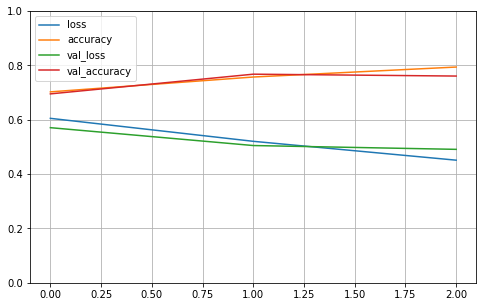

Train set ones/size 5500 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 592 / 869
Range of scores: 0.016443672 to 0.9937343
Score threshold 0.5
Prediction set ones/size 624 / 869


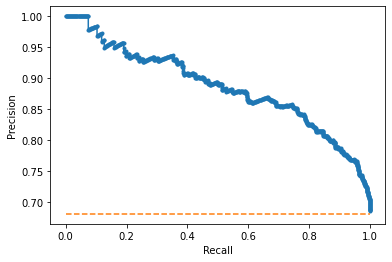

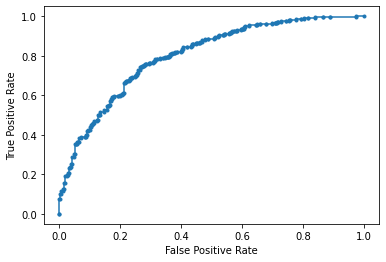

Accuracy: 76.06% Precision: 80.77% Recall: 85.14%
F1: 82.89% AUPRC: 88.65% AUROC: 80.13%
2023-02-07 14:42:31.709399
Fold 2
Bests [array([-0.68595531]), array([-0.65510913])]
RCI mean derived from training set: -0.08890415963673573
RCI threshold derived from training set: -0.6705322199427707
FIT
2023-02-07 14:42:37.655516
PREDICT
2023-02-07 14:42:49.984641


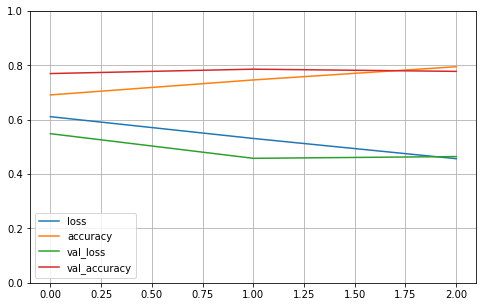

Train set ones/size 5456 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 630 / 869
Range of scores: 0.01916022 to 0.9944911
Score threshold 0.5
Prediction set ones/size 639 / 869


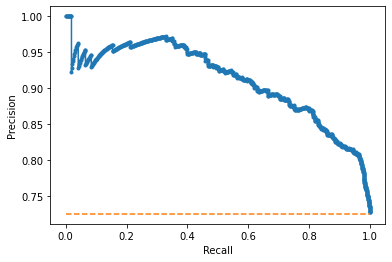

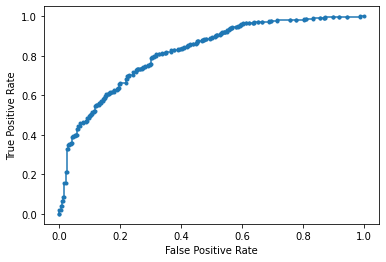

Accuracy: 77.79% Precision: 84.19% Recall: 85.40%
F1: 84.79% AUPRC: 91.12% AUROC: 81.82%
2023-02-07 14:42:51.053250
Fold 3
Bests [array([-0.70003289]), array([-0.6685689])]
RCI mean derived from training set: -0.08061058532361218
RCI threshold derived from training set: -0.6843008997057987
FIT
2023-02-07 14:42:56.006573
PREDICT
2023-02-07 14:43:07.299392


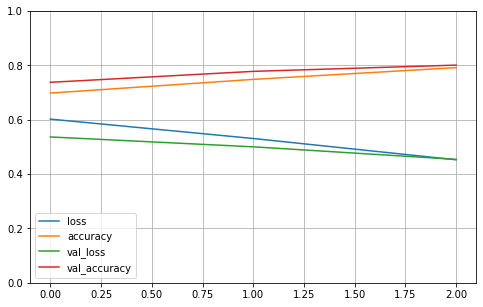

Train set ones/size 5469 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 623 / 869
Range of scores: 0.090217985 to 0.99489826
Score threshold 0.5
Prediction set ones/size 770 / 869


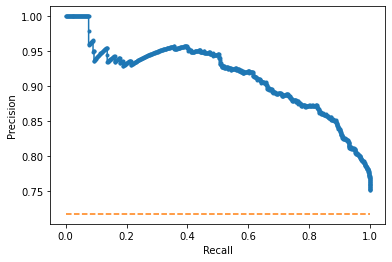

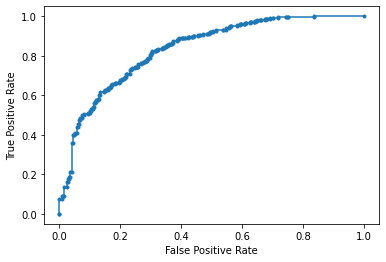

Accuracy: 80.09% Precision: 79.22% Recall: 97.91%
F1: 87.58% AUPRC: 91.46% AUROC: 83.43%
2023-02-07 14:43:07.947336
Fold 4
Bests [array([-0.75163782]), array([-0.71973158])]
RCI mean derived from training set: -0.07163159574827323
RCI threshold derived from training set: -0.7356847014499448
FIT
2023-02-07 14:43:12.512789
PREDICT
2023-02-07 14:43:21.170127


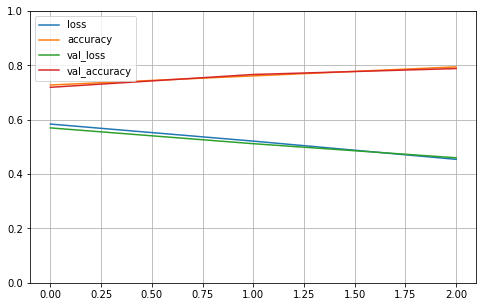

Train set ones/size 5706 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 624 / 869
Range of scores: 0.027532281 to 0.99081475
Score threshold 0.5
Prediction set ones/size 706 / 869


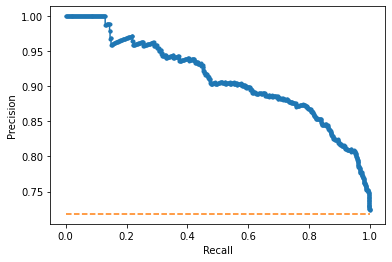

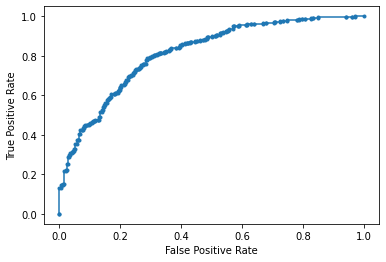

Accuracy: 78.83% Precision: 81.16% Recall: 91.83%
F1: 86.17% AUPRC: 91.11% AUROC: 81.39%
2023-02-07 14:43:21.792480
Fold 5
Bests [array([-0.74794327]), array([-0.71592388])]
RCI mean derived from training set: -0.07909441939498593
RCI threshold derived from training set: -0.7319335761476518
FIT
2023-02-07 14:43:26.417374
PREDICT
2023-02-07 14:43:35.182379


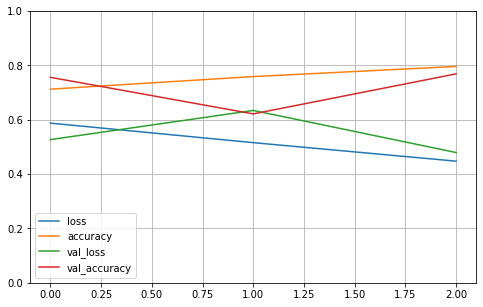

Train set ones/size 5533 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 607 / 869
Range of scores: 0.01214875 to 0.99028754
Score threshold 0.5
Prediction set ones/size 618 / 869


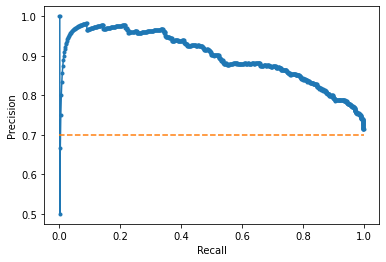

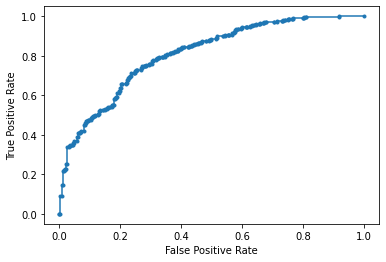

Accuracy: 76.87% Precision: 82.85% Recall: 84.35%
F1: 83.59% AUPRC: 89.72% AUROC: 80.94%
2023-02-07 14:43:35.830587
Fold 6
Bests [array([-0.71022088]), array([-0.67960608])]
RCI mean derived from training set: -0.08340265725249423
RCI threshold derived from training set: -0.69491347993902
FIT
2023-02-07 14:43:40.160649
PREDICT
2023-02-07 14:43:51.457050


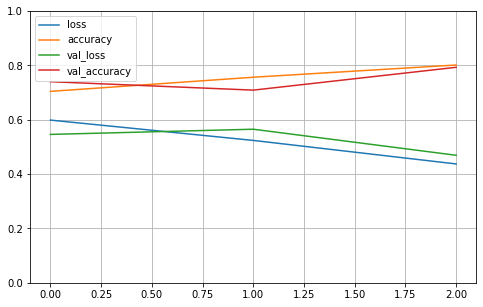

Train set ones/size 5486 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 624 / 869
Range of scores: 0.013878975 to 0.9991646
Score threshold 0.5
Prediction set ones/size 708 / 869


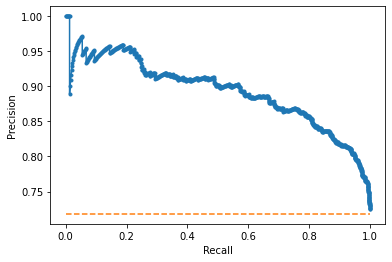

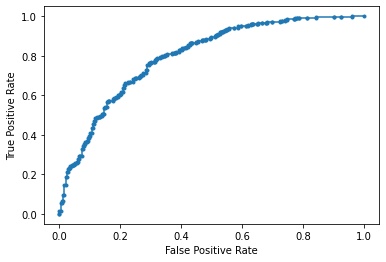

Accuracy: 79.29% Precision: 81.36% Recall: 92.31%
F1: 86.49% AUPRC: 89.34% AUROC: 79.83%
2023-02-07 14:43:52.104204
Fold 7
Bests [array([-0.64783751]), array([-0.61738325])]
RCI mean derived from training set: -0.07222989336019443
RCI threshold derived from training set: -0.6326103794450307
FIT
2023-02-07 14:43:57.780955
PREDICT
2023-02-07 14:44:09.184317


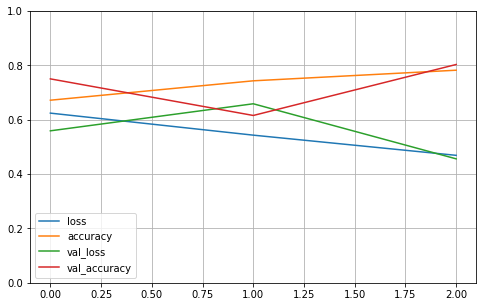

Train set ones/size 5167 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 570 / 869
Range of scores: 0.029127965 to 0.9980519
Score threshold 0.5
Prediction set ones/size 665 / 869


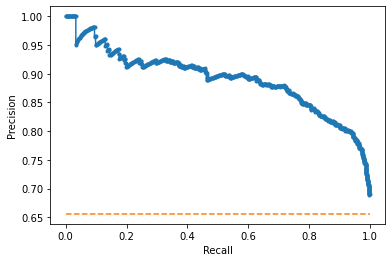

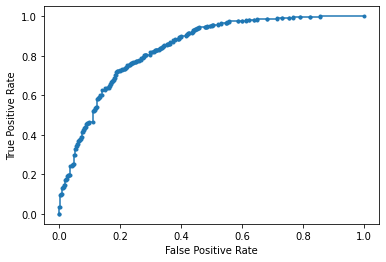

Accuracy: 80.32% Precision: 80.00% Recall: 93.33%
F1: 86.15% AUPRC: 89.07% AUROC: 83.99%
2023-02-07 14:44:10.256322
Fold 8
Bests [array([-0.75761228]), array([-0.72564695])]
RCI mean derived from training set: -0.07443658561580764
RCI threshold derived from training set: -0.7416296150637323
FIT
2023-02-07 14:44:14.601315
PREDICT
2023-02-07 14:44:23.228973


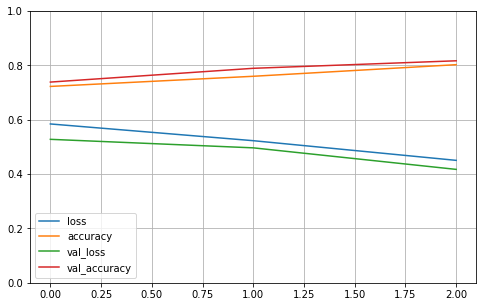

Train set ones/size 5702 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 635 / 868
Range of scores: 0.022279365 to 0.99597895
Score threshold 0.5
Prediction set ones/size 708 / 868


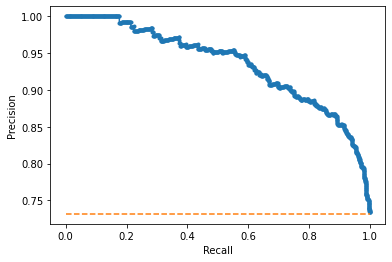

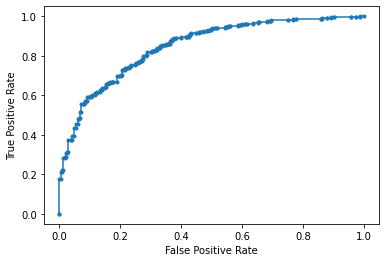

Accuracy: 81.68% Precision: 83.62% Recall: 93.23%
F1: 88.16% AUPRC: 93.53% AUROC: 84.76%
2023-02-07 14:44:24.137689
Fold 9
Bests [array([-0.743955]), array([-0.71214537])]
RCI mean derived from training set: -0.08124539040798057
RCI threshold derived from training set: -0.7280501854603341
FIT
2023-02-07 14:44:28.620082
PREDICT
2023-02-07 14:44:39.939347


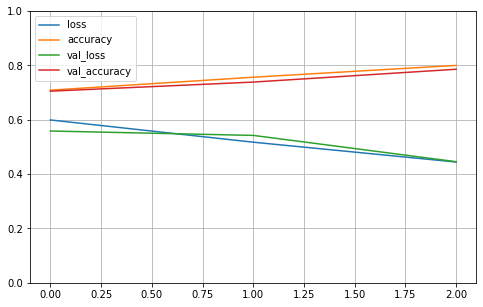

Train set ones/size 5545 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 595 / 868
Range of scores: 0.028209718 to 0.995704
Score threshold 0.5
Prediction set ones/size 711 / 868


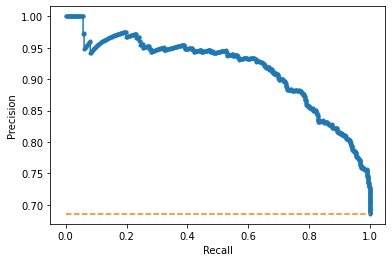

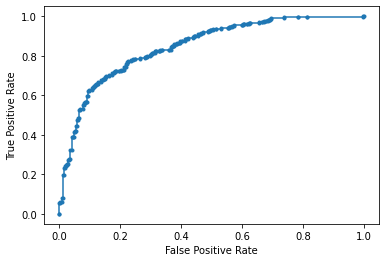

Accuracy: 78.57% Precision: 78.76% Recall: 94.12%
F1: 85.76% AUPRC: 91.56% AUROC: 84.87%
2023-02-07 14:44:40.606442
Fold 10
Bests [array([-0.70715458]), array([-0.67548878])]
RCI mean derived from training set: -0.07852757553011895
RCI threshold derived from training set: -0.6913216809584486
FIT
2023-02-07 14:44:45.262379
PREDICT
2023-02-07 14:44:56.543851


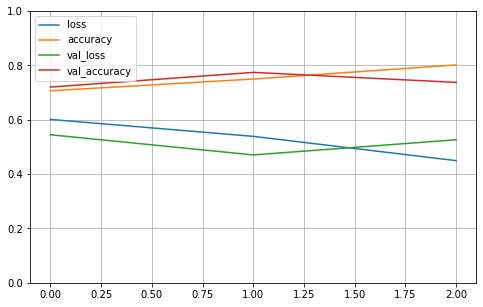

Train set ones/size 5495 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 614 / 868
Range of scores: 0.005144199 to 0.99296016
Score threshold 0.5
Prediction set ones/size 494 / 868


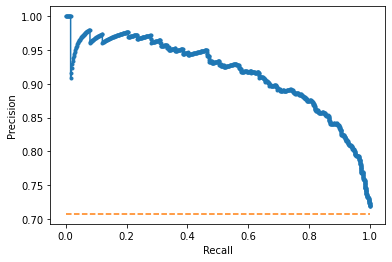

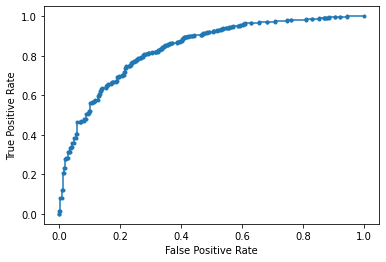

Accuracy: 73.73% Precision: 89.07% Recall: 71.66%
F1: 79.42% AUPRC: 91.64% AUROC: 83.80%
2023-02-07 14:44:57.214572

Completed cross validation 10 folds 3 epochs
 accuracy mean 78.32% +/- 2.31
 precision mean 82.10% +/- 3.03
 recall mean 88.93% +/- 7.54
 F1 mean 85.10% +/- 2.57
 AUPRC mean 90.72% +/- 1.50
 AUROC mean 82.50% +/- 1.90
Finished cell Line 0 A549

2023-02-07 14:44:58.608199
Start cell Line 1 H1.hESC
Number of RCI values loaded 3327
Num RCI: 3327
Load sequence...
Cross validation...
2023-02-07 14:45:25.435119
splitting
Fold 1
Bests [array([-0.13064292]), array([-0.09728567])]
RCI mean derived from training set: -0.2860503863035882
RCI threshold derived from training set: -0.11396429369910344
FIT
2023-02-07 14:45:32.695549
PREDICT
2023-02-07 14:45:54.674321


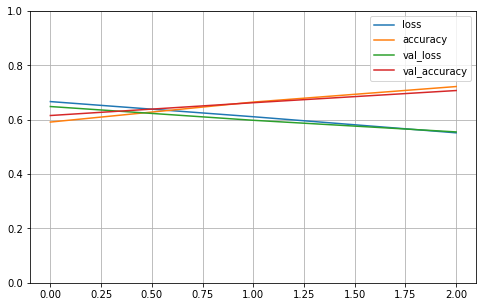

Train set ones/size 6614 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 742 / 1654
Range of scores: 0.009396735 to 0.9935086
Score threshold 0.5
Prediction set ones/size 770 / 1654


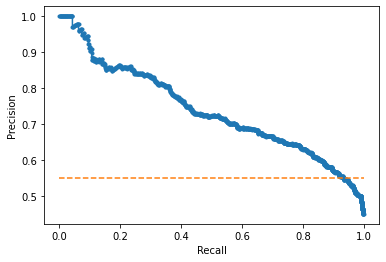

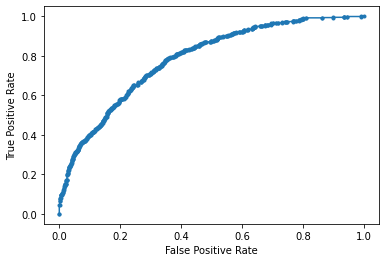

Accuracy: 70.74% Precision: 66.75% Recall: 69.27%
F1: 67.99% AUPRC: 73.97% AUROC: 78.27%
2023-02-07 14:45:55.735157
Fold 2
Bests [array([-0.05682716]), array([-0.02334942])]
RCI mean derived from training set: -0.2767828940834565
RCI threshold derived from training set: -0.04008829032382055
FIT
2023-02-07 14:46:02.511423
PREDICT
2023-02-07 14:46:18.246018


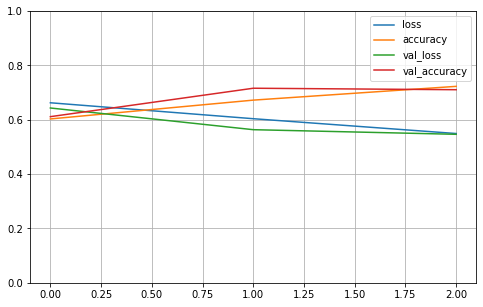

Train set ones/size 6406 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 689 / 1654
Range of scores: 0.011980837 to 0.98582596
Score threshold 0.5
Prediction set ones/size 704 / 1654


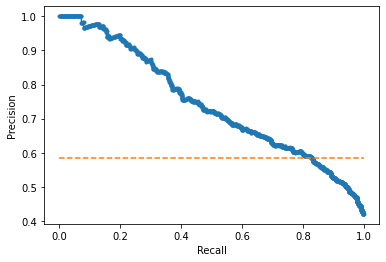

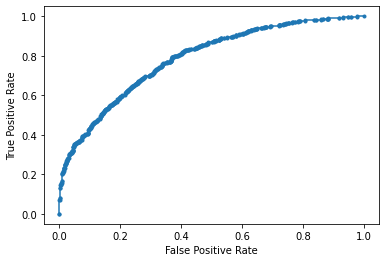

Accuracy: 71.04% Precision: 64.91% Recall: 66.33%
F1: 65.61% AUPRC: 74.31% AUROC: 78.62%
2023-02-07 14:46:19.110475
Fold 3
Bests [array([-0.09839409]), array([-0.06462127])]
RCI mean derived from training set: -0.2846416293146083
RCI threshold derived from training set: -0.08150768058492275
FIT
2023-02-07 14:46:27.739299
PREDICT
2023-02-07 14:46:43.145092


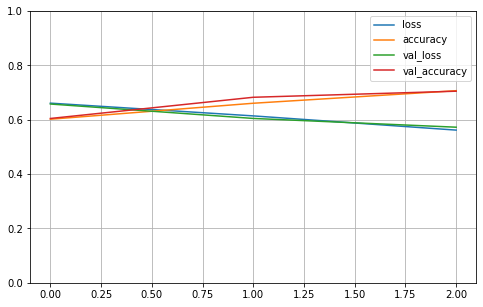

Train set ones/size 6473 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 731 / 1654
Range of scores: 0.0009849867 to 0.995144
Score threshold 0.5
Prediction set ones/size 701 / 1654


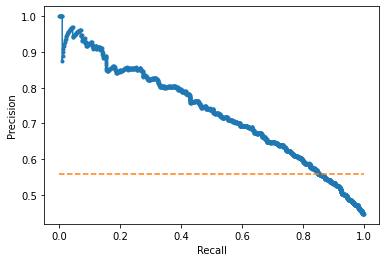

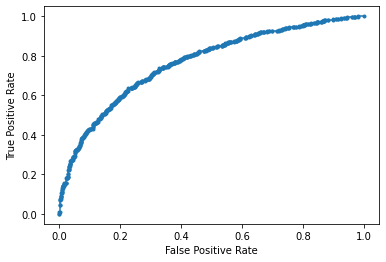

Accuracy: 70.50% Precision: 67.33% Recall: 64.57%
F1: 65.92% AUPRC: 73.09% AUROC: 76.69%
2023-02-07 14:46:44.022984
Fold 4
Bests [array([-0.06826039]), array([-0.03452582])]
RCI mean derived from training set: -0.2841060262625991
RCI threshold derived from training set: -0.05139310573834366
FIT
2023-02-07 14:46:52.672015
PREDICT
2023-02-07 14:47:14.641912


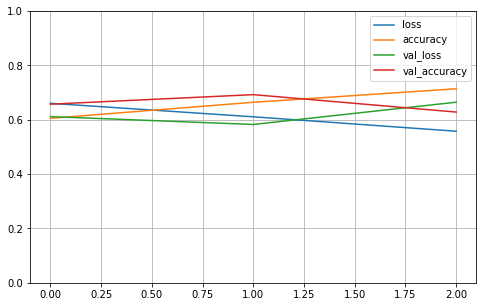

Train set ones/size 6409 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 720 / 1654
Range of scores: 0.009395164 to 0.99319893
Score threshold 0.5
Prediction set ones/size 1209 / 1654


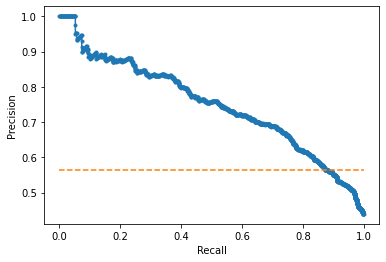

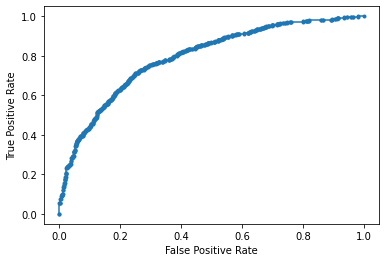

Accuracy: 62.82% Precision: 54.34% Recall: 91.25%
F1: 68.12% AUPRC: 74.91% AUROC: 79.33%
2023-02-07 14:47:15.751745
Fold 5
Bests [array([-0.0695538]), array([-0.03607098])]
RCI mean derived from training set: -0.2888123344866282
RCI threshold derived from training set: -0.052812390964857236
FIT
2023-02-07 14:47:23.079574
PREDICT
2023-02-07 14:47:38.771110


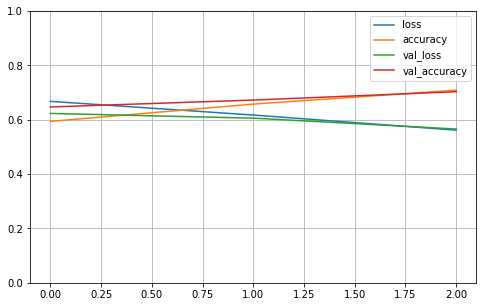

Train set ones/size 6387 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 743 / 1654
Range of scores: 0.006983089 to 0.9750787
Score threshold 0.5
Prediction set ones/size 558 / 1654


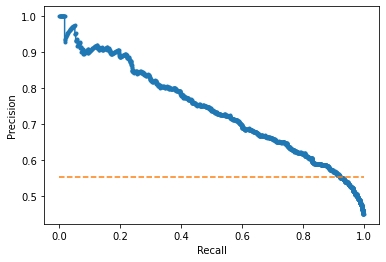

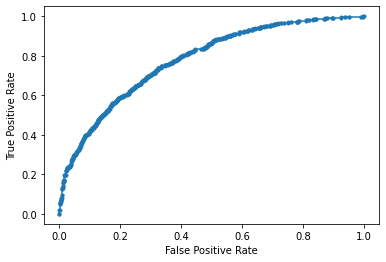

Accuracy: 70.31% Precision: 72.58% Recall: 54.51%
F1: 62.26% AUPRC: 74.20% AUROC: 77.94%
2023-02-07 14:47:39.556200
Fold 6
Bests [array([-0.0716416]), array([-0.03777091])]
RCI mean derived from training set: -0.2858548136823007
RCI threshold derived from training set: -0.05470625676681384
FIT
2023-02-07 14:47:47.740258
PREDICT
2023-02-07 14:48:09.680831


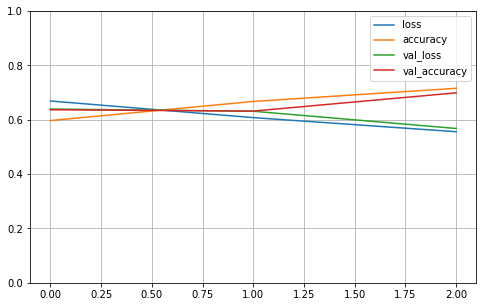

Train set ones/size 6399 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 731 / 1654
Range of scores: 0.006299119 to 0.96541756
Score threshold 0.5
Prediction set ones/size 535 / 1654


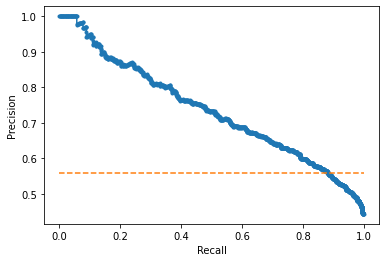

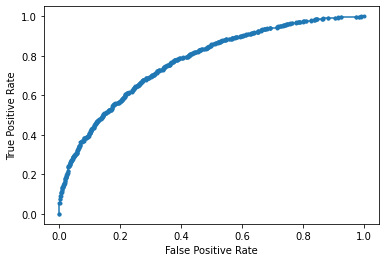

Accuracy: 69.89% Precision: 71.78% Recall: 52.53%
F1: 60.66% AUPRC: 73.68% AUROC: 77.28%
2023-02-07 14:48:10.588019
Fold 7
Bests [array([-0.09861517]), array([-0.06488718])]
RCI mean derived from training set: -0.28354508167439363
RCI threshold derived from training set: -0.08175117741773996
FIT
2023-02-07 14:48:17.694161
PREDICT
2023-02-07 14:48:33.295062


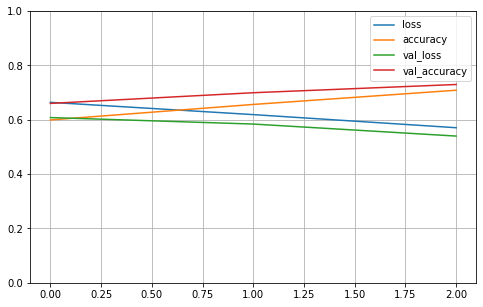

Train set ones/size 6486 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 718 / 1653
Range of scores: 0.004166412 to 0.9927487
Score threshold 0.5
Prediction set ones/size 675 / 1653


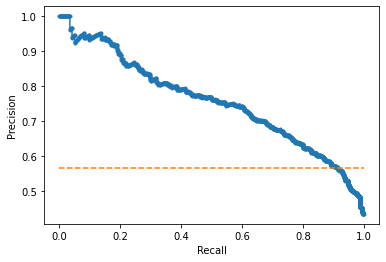

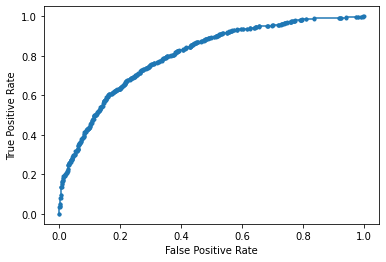

Accuracy: 72.96% Precision: 70.07% Recall: 65.88%
F1: 67.91% AUPRC: 75.65% AUROC: 80.20%
2023-02-07 14:48:34.447647
Fold 8
Bests [array([-0.25060252]), array([-0.21697589])]
RCI mean derived from training set: -0.27972968674662363
RCI threshold derived from training set: -0.23378920433920203
FIT
2023-02-07 14:48:41.637544
PREDICT
2023-02-07 14:48:57.277361


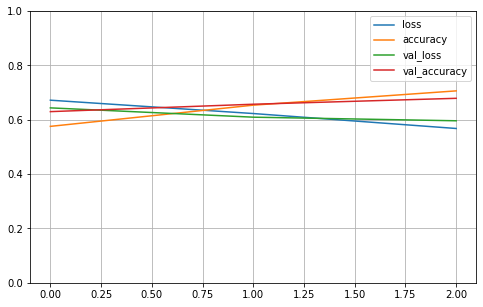

Train set ones/size 7162 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 777 / 1653
Range of scores: 0.028991062 to 0.99276346
Score threshold 0.5
Prediction set ones/size 946 / 1653


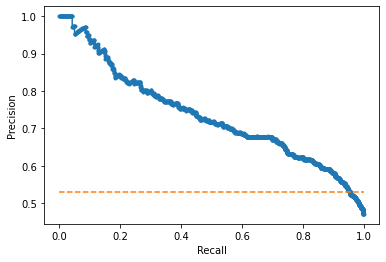

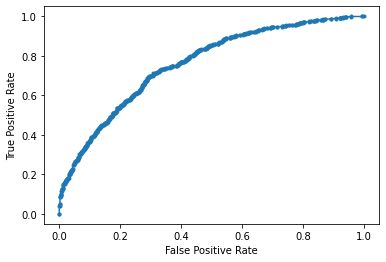

Accuracy: 67.88% Precision: 63.00% Recall: 76.71%
F1: 69.18% AUPRC: 73.56% AUROC: 76.01%
2023-02-07 14:48:58.062645
Fold 9
Bests [array([-0.13567295]), array([-0.1022433])]
RCI mean derived from training set: -0.2802676957286837
RCI threshold derived from training set: -0.11895812643420178
FIT
2023-02-07 14:49:05.755399
PREDICT
2023-02-07 14:49:21.378728


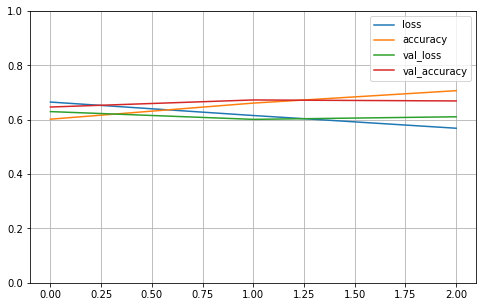

Train set ones/size 6675 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 715 / 1653
Range of scores: 0.022612015 to 0.9933076
Score threshold 0.5
Prediction set ones/size 986 / 1653


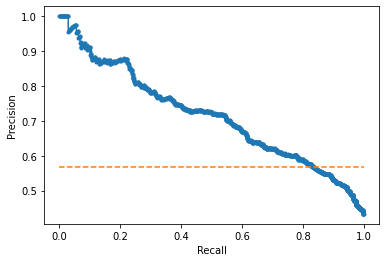

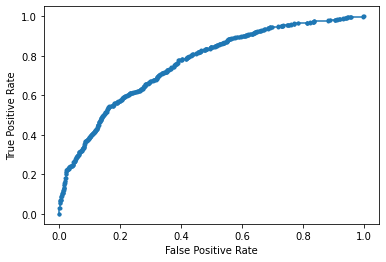

Accuracy: 66.91% Precision: 58.52% Recall: 80.70%
F1: 67.84% AUPRC: 71.48% AUROC: 76.26%
2023-02-07 14:49:22.276003
Fold 10
Bests [array([-0.10145506]), array([-0.06797595])]
RCI mean derived from training set: -0.28432212661761747
RCI threshold derived from training set: -0.08471550375636805
FIT
2023-02-07 14:49:31.014787
PREDICT
2023-02-07 14:49:53.006070


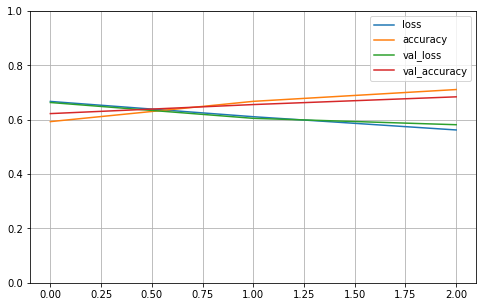

Train set ones/size 6496 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 714 / 1653
Range of scores: 0.033024717 to 0.97033274
Score threshold 0.5
Prediction set ones/size 694 / 1653


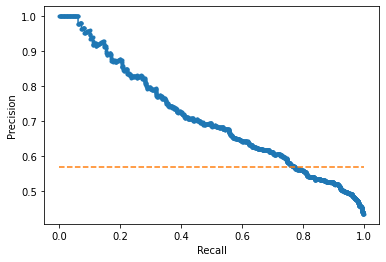

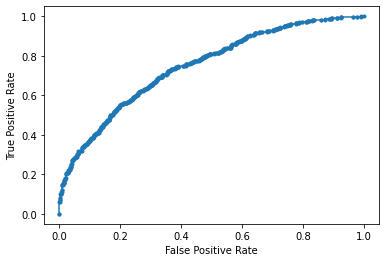

Accuracy: 68.42% Precision: 63.83% Recall: 62.04%
F1: 62.93% AUPRC: 70.80% AUROC: 74.80%
2023-02-07 14:49:54.106902

Completed cross validation 10 folds 3 epochs
 accuracy mean 69.15% +/- 2.82
 precision mean 65.31% +/- 5.75
 recall mean 68.38% +/- 11.80
 F1 mean 65.84% +/- 2.93
 AUPRC mean 73.57% +/- 1.47
 AUROC mean 77.54% +/- 1.65
Finished cell Line 1 H1.hESC

2023-02-07 14:49:55.892679
Start cell Line 2 HeLa.S3
Number of RCI values loaded 919
Num RCI: 919
Load sequence...
Cross validation...
2023-02-07 14:50:04.023535
splitting
Fold 1
Bests [array([-0.64649118]), array([-0.62343326])]
RCI mean derived from training set: -1.283539943874046
RCI threshold derived from training set: -0.6349622221457876
FIT
2023-02-07 14:50:07.428202
PREDICT
2023-02-07 14:50:13.815540


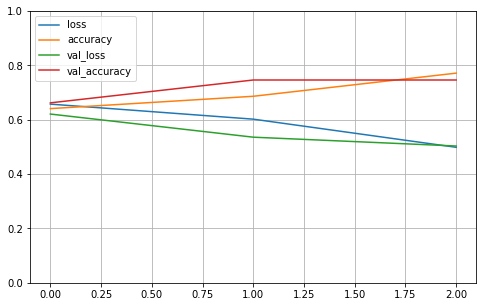

Train set ones/size 1823 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 197 / 583
Range of scores: 0.00078129576 to 0.8924493
Score threshold 0.5
Prediction set ones/size 57 / 583


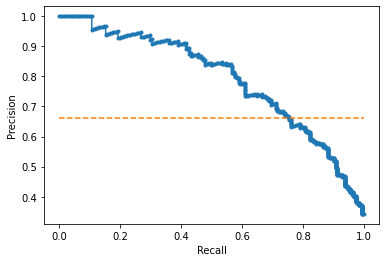

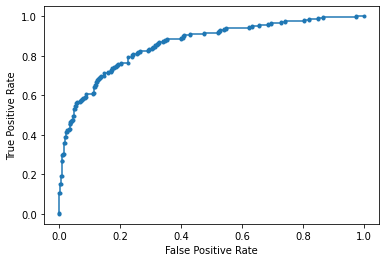

Accuracy: 74.61% Precision: 92.98% Recall: 26.90%
F1: 41.73% AUPRC: 79.16% AUROC: 85.87%
2023-02-07 14:50:14.397192
Fold 2
Bests [array([-0.60325557]), array([-0.58038351])]
RCI mean derived from training set: -1.2804343327099237
RCI threshold derived from training set: -0.5918195388274958
FIT
2023-02-07 14:50:17.779279
PREDICT
2023-02-07 14:50:28.986868


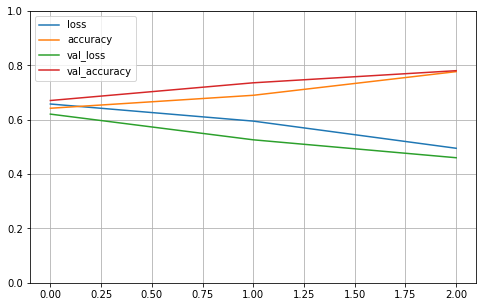

Train set ones/size 1773 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 192 / 583
Range of scores: 0.0043073376 to 0.96529305
Score threshold 0.5
Prediction set ones/size 114 / 583


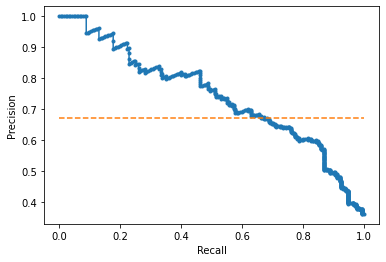

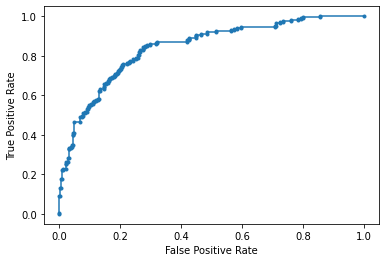

Accuracy: 78.04% Precision: 78.07% Recall: 46.35%
F1: 58.17% AUPRC: 74.30% AUROC: 84.38%
2023-02-07 14:50:29.600133
Fold 3
Bests [array([-0.58548137]), array([-0.56228419])]
RCI mean derived from training set: -1.2776195288549619
RCI threshold derived from training set: -0.5738827777356423
FIT
2023-02-07 14:50:34.286107
PREDICT
2023-02-07 14:50:45.622177


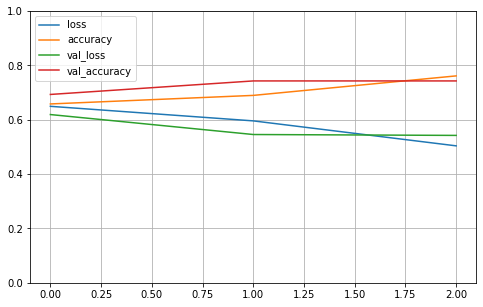

Train set ones/size 1762 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 186 / 583
Range of scores: 0.002281815 to 0.8713502
Score threshold 0.5
Prediction set ones/size 40 / 583


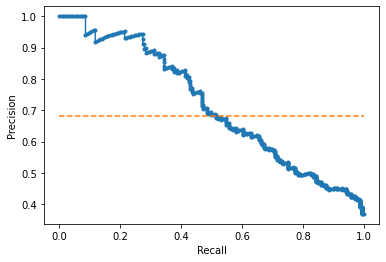

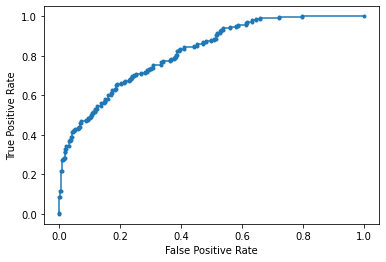

Accuracy: 74.27% Precision: 95.00% Recall: 20.43%
F1: 33.63% AUPRC: 71.64% AUROC: 81.97%
2023-02-07 14:50:46.483526
Fold 4
Bests [array([-0.62445523]), array([-0.60164625])]
RCI mean derived from training set: -1.2759836982064492
RCI threshold derived from training set: -0.6130507383923895
FIT
2023-02-07 14:50:50.176193
PREDICT
2023-02-07 14:51:01.359979


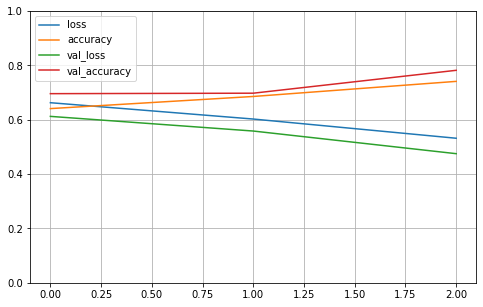

Train set ones/size 1804 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 176 / 582
Range of scores: 0.007129818 to 0.9190197
Score threshold 0.5
Prediction set ones/size 83 / 582


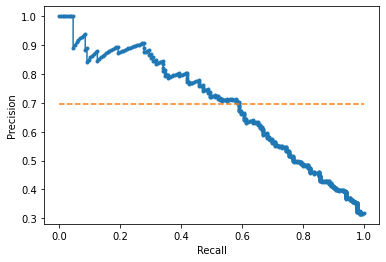

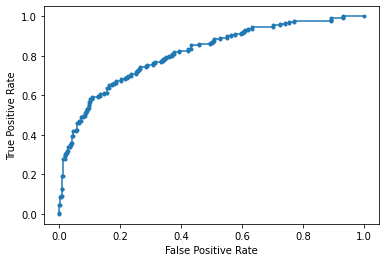

Accuracy: 78.18% Precision: 79.52% Recall: 37.50%
F1: 50.97% AUPRC: 69.63% AUROC: 81.38%
2023-02-07 14:51:01.966607
Fold 5
Bests [array([-0.60649574]), array([-0.58371451])]
RCI mean derived from training set: -1.2879645047891624
RCI threshold derived from training set: -0.5951051253466547
FIT
2023-02-07 14:51:05.455357
PREDICT
2023-02-07 14:51:16.603444


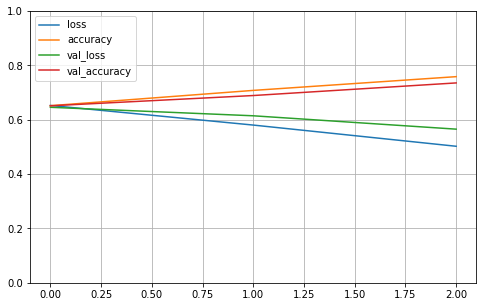

Train set ones/size 1762 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 203 / 582
Range of scores: 0.0036668761 to 0.9473412
Score threshold 0.5
Prediction set ones/size 59 / 582


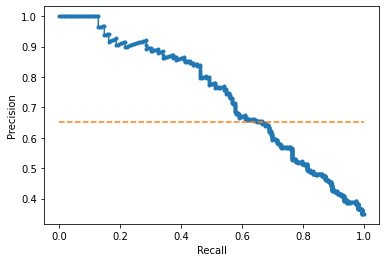

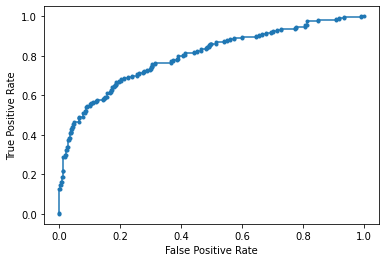

Accuracy: 73.54% Precision: 91.53% Recall: 26.60%
F1: 41.22% AUPRC: 73.80% AUROC: 79.95%
2023-02-07 14:51:17.185318
Fold 6
Bests [array([-0.61546732]), array([-0.59229357])]
RCI mean derived from training set: -1.285638432093112
RCI threshold derived from training set: -0.6038804476317977
FIT
2023-02-07 14:51:20.752839
PREDICT
2023-02-07 14:51:31.888558


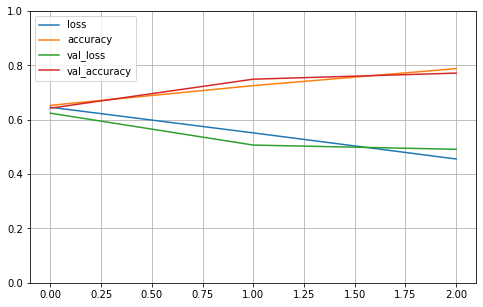

Train set ones/size 1763 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 208 / 582
Range of scores: 0.0008117422 to 0.9467991
Score threshold 0.5
Prediction set ones/size 95 / 582


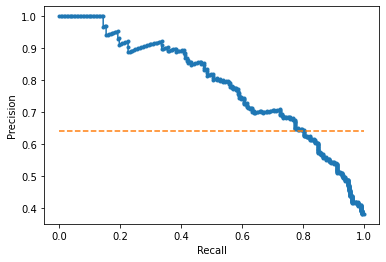

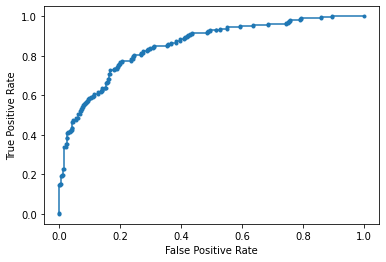

Accuracy: 77.15% Precision: 89.47% Recall: 40.87%
F1: 56.11% AUPRC: 78.59% AUROC: 85.22%
2023-02-07 14:51:32.525059
Fold 7
Bests [array([-0.63548158]), array([-0.61242672])]
RCI mean derived from training set: -1.3007761754245373
RCI threshold derived from training set: -0.6239541516969592
FIT
2023-02-07 14:51:36.618850
PREDICT
2023-02-07 14:51:43.089762


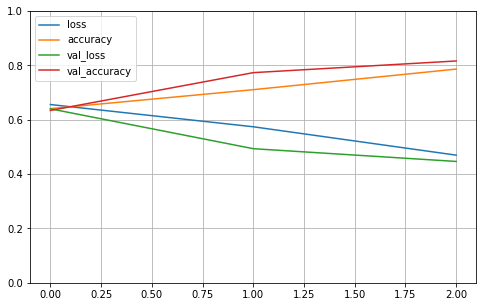

Train set ones/size 1807 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 212 / 582
Range of scores: 0.007451814 to 0.9913215
Score threshold 0.5
Prediction set ones/size 211 / 582


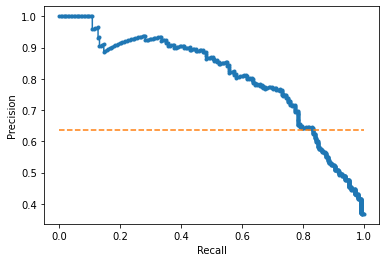

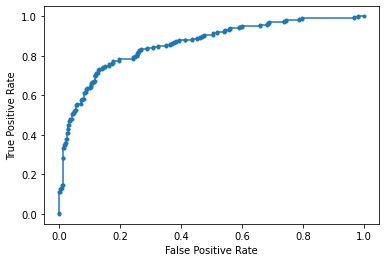

Accuracy: 81.62% Precision: 74.88% Recall: 74.53%
F1: 74.70% AUPRC: 80.59% AUROC: 86.08%
2023-02-07 14:51:43.653708
Fold 8
Bests [array([-0.61557907]), array([-0.59302998])]
RCI mean derived from training set: -1.278800849303568
RCI threshold derived from training set: -0.6043045240737904
FIT
2023-02-07 14:51:47.038261
PREDICT
2023-02-07 14:51:53.412845


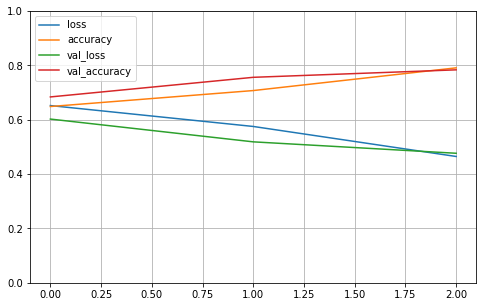

Train set ones/size 1787 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 184 / 582
Range of scores: 0.0007702932 to 0.9347841
Score threshold 0.5
Prediction set ones/size 96 / 582


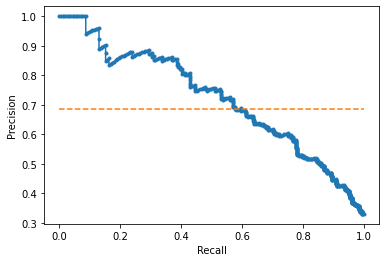

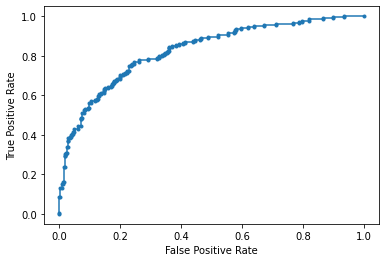

Accuracy: 78.35% Precision: 80.21% Recall: 41.85%
F1: 55.00% AUPRC: 72.16% AUROC: 82.73%
2023-02-07 14:51:54.052142
Fold 9
Bests [array([-0.58394032]), array([-0.56083218])]
RCI mean derived from training set: -1.2968693947910706
RCI threshold derived from training set: -0.5723862495826525
FIT
2023-02-07 14:51:57.463370
PREDICT
2023-02-07 14:52:08.614147


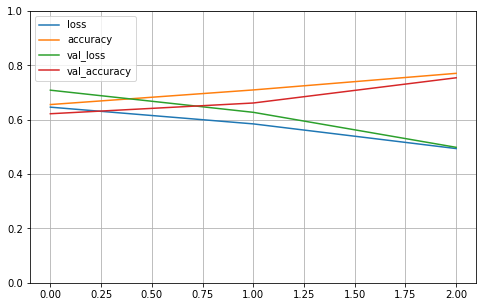

Train set ones/size 1728 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 220 / 582
Range of scores: 0.006153657 to 0.9737888
Score threshold 0.5
Prediction set ones/size 225 / 582


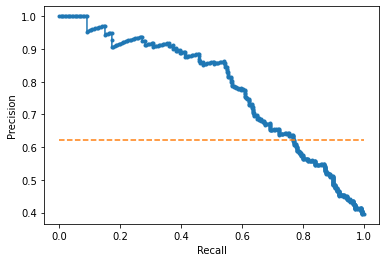

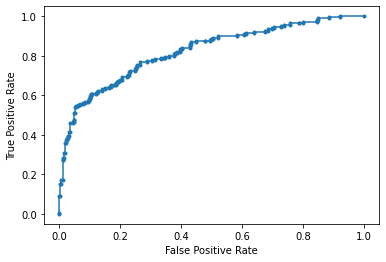

Accuracy: 75.43% Precision: 67.11% Recall: 68.64%
F1: 67.87% AUPRC: 77.88% AUROC: 82.28%
2023-02-07 14:52:09.218098
Fold 10
Bests [array([-0.66659336]), array([-0.64278008])]
RCI mean derived from training set: -1.2907133534439992
RCI threshold derived from training set: -0.654686716633811
FIT
2023-02-07 14:52:12.543561
PREDICT
2023-02-07 14:52:23.689249


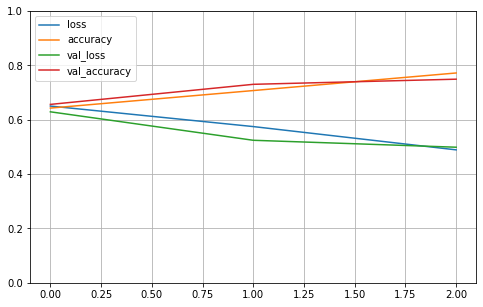

Train set ones/size 1852 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 203 / 582
Range of scores: 0.005550585 to 0.95996445
Score threshold 0.5
Prediction set ones/size 121 / 582


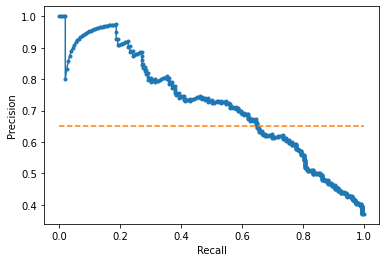

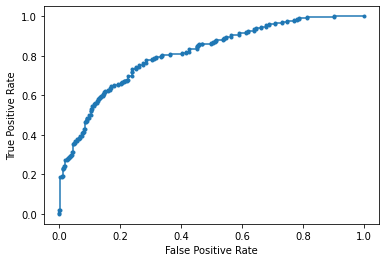

Accuracy: 74.91% Precision: 73.55% Recall: 43.84%
F1: 54.94% AUPRC: 71.77% AUROC: 81.06%
2023-02-07 14:52:24.290740

Completed cross validation 10 folds 3 epochs
 accuracy mean 76.61% +/- 2.50
 precision mean 82.23% +/- 9.45
 recall mean 42.75% +/- 17.44
 F1 mean 53.43% +/- 12.38
 AUPRC mean 74.95% +/- 3.80
 AUROC mean 83.09% +/- 2.16
Finished cell Line 2 HeLa.S3

2023-02-07 14:52:25.650079
Start cell Line 3 HepG2
Number of RCI values loaded 1362
Num RCI: 1362
Load sequence...
Cross validation...
2023-02-07 14:52:39.335573
splitting
Fold 1
Bests [array([-0.46419695]), array([-0.43026427])]
RCI mean derived from training set: -1.0839654720302832
RCI threshold derived from training set: -0.4472306107570776
FIT
2023-02-07 14:52:42.621366
PREDICT
2023-02-07 14:52:54.234453


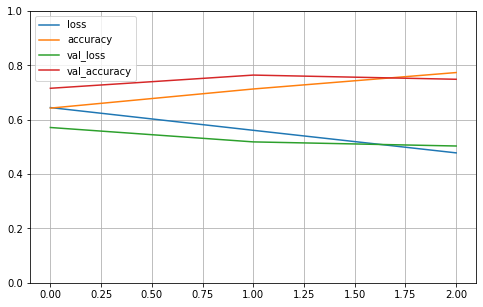

Train set ones/size 2676 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 295 / 844
Range of scores: 0.0033983577 to 0.9887989
Score threshold 0.5
Prediction set ones/size 337 / 844


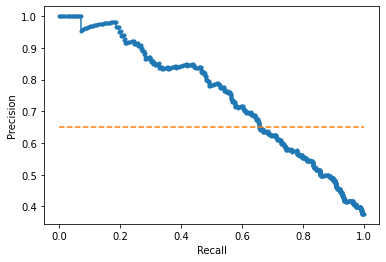

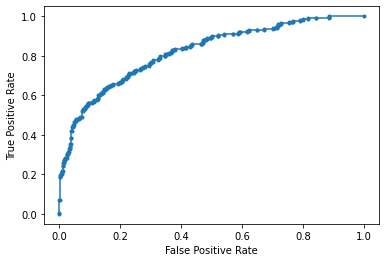

Accuracy: 74.88% Precision: 62.31% Recall: 71.19%
F1: 66.46% AUPRC: 74.93% AUROC: 82.07%
2023-02-07 14:52:54.891590
Fold 2
Bests [array([-0.4747057]), array([-0.44078858])]
RCI mean derived from training set: -1.0801516686556945
RCI threshold derived from training set: -0.4577471378596857
FIT
2023-02-07 14:53:00.216622
PREDICT
2023-02-07 14:53:11.512801


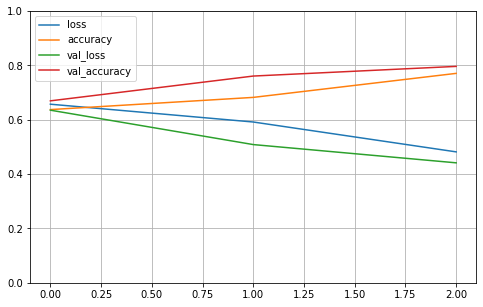

Train set ones/size 2689 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 292 / 844
Range of scores: 0.0065943087 to 0.9828728
Score threshold 0.5
Prediction set ones/size 184 / 844


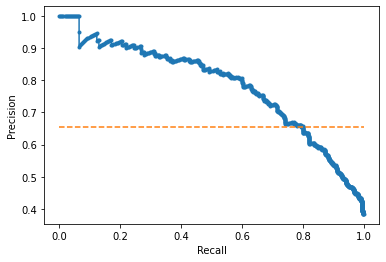

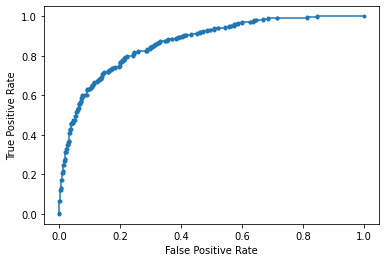

Accuracy: 79.62% Precision: 82.61% Recall: 52.05%
F1: 63.87% AUPRC: 78.47% AUROC: 86.68%
2023-02-07 14:53:12.149097
Fold 3
Bests [array([-0.49988739]), array([-0.46512241])]
RCI mean derived from training set: -1.0755342854325212
RCI threshold derived from training set: -0.4825048999341618
FIT
2023-02-07 14:53:16.665955
PREDICT
2023-02-07 14:53:27.960753


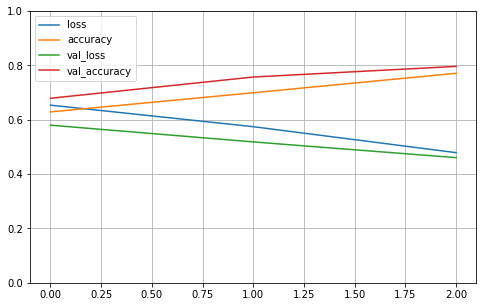

Train set ones/size 2776 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 292 / 844
Range of scores: 0.0045540314 to 0.98329115
Score threshold 0.5
Prediction set ones/size 244 / 844


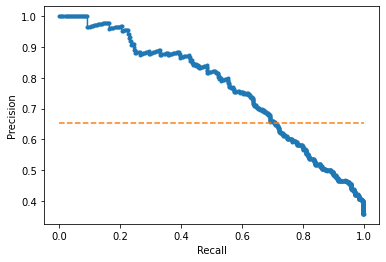

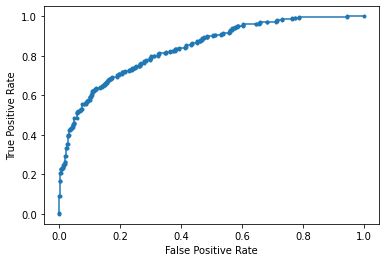

Accuracy: 79.62% Precision: 74.59% Recall: 62.33%
F1: 67.91% AUPRC: 76.80% AUROC: 83.94%
2023-02-07 14:53:28.615859
Fold 4
Bests [array([-0.50697381]), array([-0.47332939])]
RCI mean derived from training set: -1.07985061436208
RCI threshold derived from training set: -0.49015160165948224
FIT
2023-02-07 14:53:32.874739
PREDICT
2023-02-07 14:53:41.561376


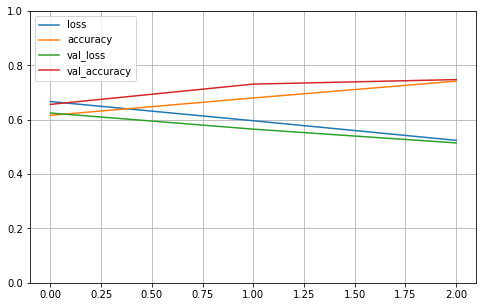

Train set ones/size 2798 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 293 / 844
Range of scores: 0.0079437485 to 0.9680301
Score threshold 0.5
Prediction set ones/size 188 / 844


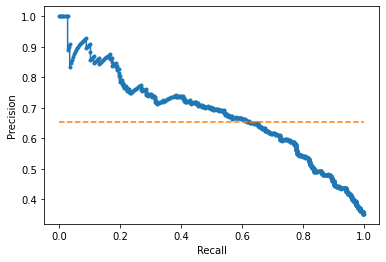

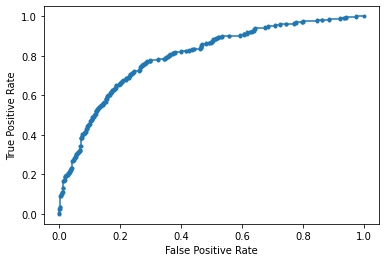

Accuracy: 74.76% Precision: 71.28% Recall: 45.73%
F1: 55.72% AUPRC: 67.99% AUROC: 79.71%
2023-02-07 14:53:42.172930
Fold 5
Bests [array([-0.46510015]), array([-0.43260473])]
RCI mean derived from training set: -1.0818529347004608
RCI threshold derived from training set: -0.44885244091446863
FIT
2023-02-07 14:53:46.267001
PREDICT
2023-02-07 14:53:57.706493


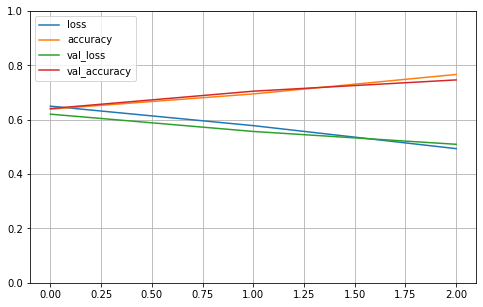

Train set ones/size 2663 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 313 / 844
Range of scores: 0.0010468789 to 0.97677714
Score threshold 0.5
Prediction set ones/size 187 / 844


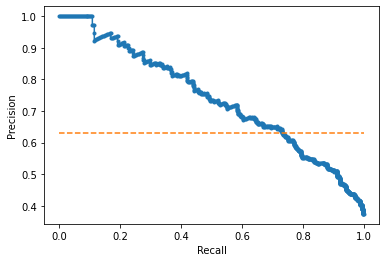

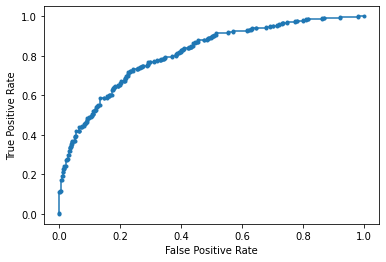

Accuracy: 74.64% Precision: 76.47% Recall: 45.69%
F1: 57.20% AUPRC: 74.17% AUROC: 81.22%
2023-02-07 14:53:58.346274
Fold 6
Bests [array([-0.44449309]), array([-0.41075961])]
RCI mean derived from training set: -1.0809142119407504
RCI threshold derived from training set: -0.42762635308211316
FIT
2023-02-07 14:54:04.150242
PREDICT
2023-02-07 14:54:12.316107


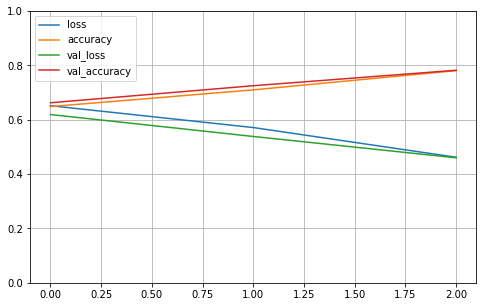

Train set ones/size 2610 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 304 / 844
Range of scores: 0.008454109 to 0.9898601
Score threshold 0.5
Prediction set ones/size 270 / 844


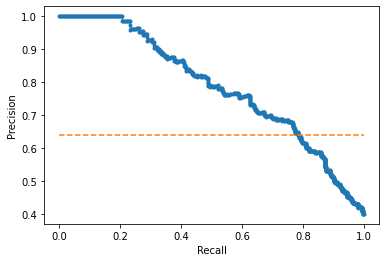

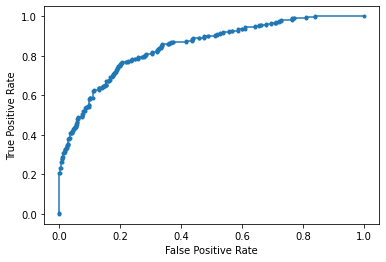

Accuracy: 78.20% Precision: 72.22% Recall: 64.14%
F1: 67.94% AUPRC: 78.66% AUROC: 84.60%
2023-02-07 14:54:12.965489
Fold 7
Bests [array([-0.52884628]), array([-0.49437829])]
RCI mean derived from training set: -1.0826895800434497
RCI threshold derived from training set: -0.5116122880243397
FIT
2023-02-07 14:54:18.201066
PREDICT
2023-02-07 14:54:26.332214


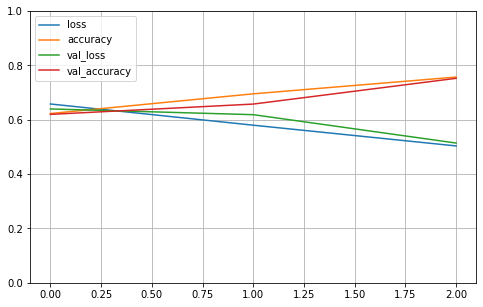

Train set ones/size 2816 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 305 / 844
Range of scores: 0.005436724 to 0.96422046
Score threshold 0.5
Prediction set ones/size 208 / 844


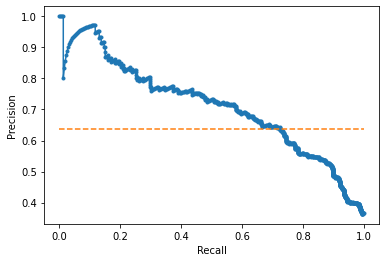

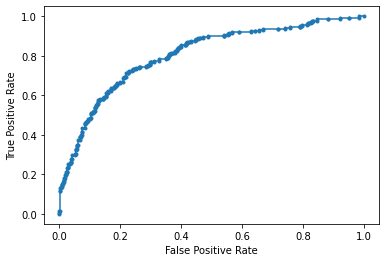

Accuracy: 75.24% Precision: 73.08% Recall: 49.84%
F1: 59.26% AUPRC: 71.14% AUROC: 80.50%
2023-02-07 14:54:27.067590
Fold 8
Bests [array([-0.54724724]), array([-0.51247933])]
RCI mean derived from training set: -1.0882789068571428
RCI threshold derived from training set: -0.5298632849041578
FIT
2023-02-07 14:54:31.963918
PREDICT
2023-02-07 14:54:40.161107


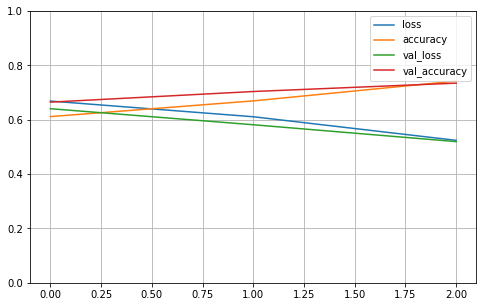

Train set ones/size 2816 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 333 / 844
Range of scores: 0.0020413664 to 0.976398
Score threshold 0.5
Prediction set ones/size 169 / 844


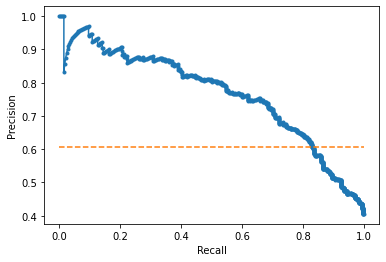

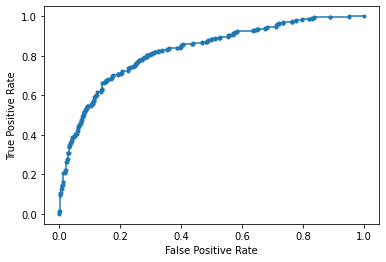

Accuracy: 73.46% Precision: 82.25% Recall: 41.74%
F1: 55.38% AUPRC: 76.62% AUROC: 82.67%
2023-02-07 14:54:41.044111
Fold 9
Bests [array([-0.46967271]), array([-0.43512881])]
RCI mean derived from training set: -1.0822446985661618
RCI threshold derived from training set: -0.45240076217440617
FIT
2023-02-07 14:54:45.413756
PREDICT
2023-02-07 14:54:53.619924


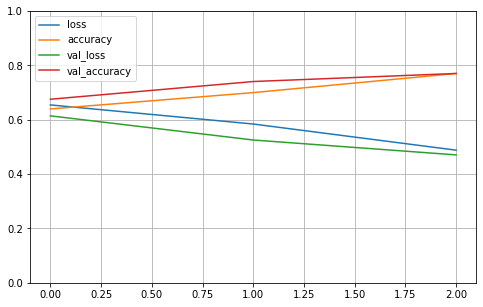

Train set ones/size 2681 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 298 / 844
Range of scores: 0.003955648 to 0.9670738
Score threshold 0.5
Prediction set ones/size 188 / 844


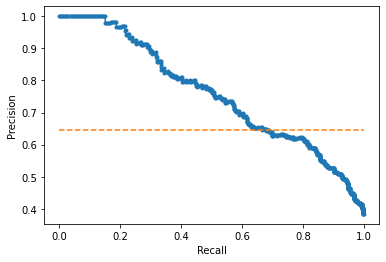

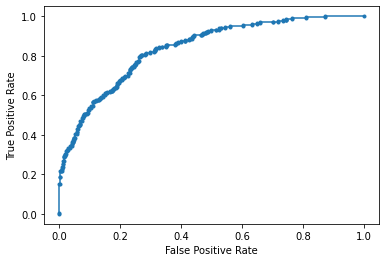

Accuracy: 77.01% Precision: 77.66% Recall: 48.99%
F1: 60.08% AUPRC: 75.93% AUROC: 83.79%
2023-02-07 14:54:54.478891
Fold 10
Bests [array([-0.44949575]), array([-0.41500334])]
RCI mean derived from training set: -1.0828875017048445
RCI threshold derived from training set: -0.4322495475049506
FIT
2023-02-07 14:54:58.919553
PREDICT
2023-02-07 14:55:10.245964


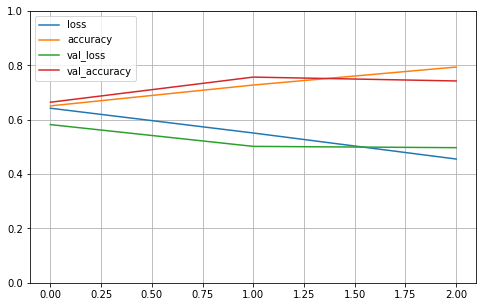

Train set ones/size 2617 / 7596
Compute valiation accuracy
Valid sizes (843, 4997) (843,)
Valid set ones/size 297 / 843
Range of scores: 0.0033292212 to 0.9675742
Score threshold 0.5
Prediction set ones/size 120 / 843


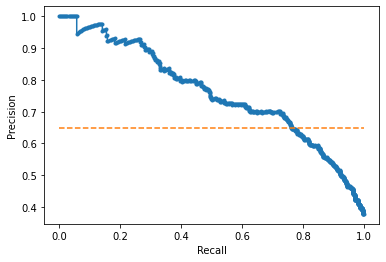

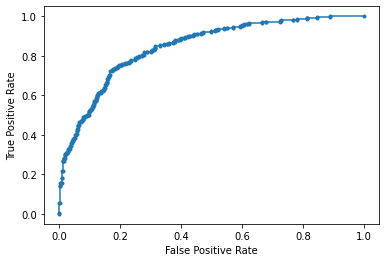

Accuracy: 74.26% Precision: 83.33% Recall: 33.67%
F1: 47.96% AUPRC: 76.14% AUROC: 84.64%
2023-02-07 14:55:10.932901

Completed cross validation 10 folds 3 epochs
 accuracy mean 76.17% +/- 2.27
 precision mean 75.58% +/- 6.43
 recall mean 51.54% +/- 11.32
 F1 mean 60.18% +/- 6.46
 AUPRC mean 75.08% +/- 3.30
 AUROC mean 82.98% +/- 2.15
Finished cell Line 3 HepG2

2023-02-07 14:55:12.327180
Start cell Line 4 HT1080
Number of RCI values loaded 936
Num RCI: 936
Load sequence...
Cross validation...
2023-02-07 14:55:24.050964
splitting
Fold 1
Bests [array([0.09046974]), array([0.11811812])]
RCI mean derived from training set: -0.2837299268113891
RCI threshold derived from training set: 0.1042939279966858
FIT
2023-02-07 14:55:27.046069
PREDICT
2023-02-07 14:55:38.263908


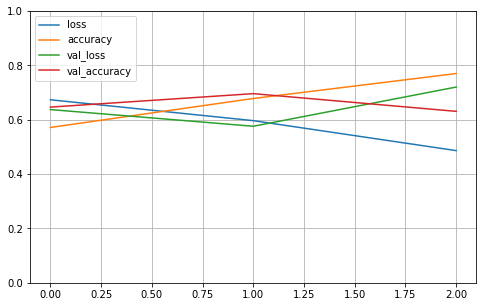

Train set ones/size 2685 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 297 / 707
Range of scores: 0.0036866409 to 0.99922574
Score threshold 0.5
Prediction set ones/size 500 / 707


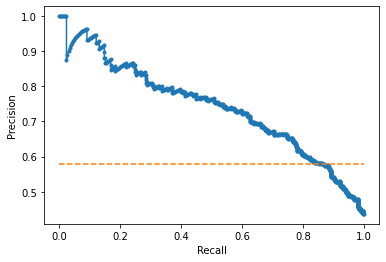

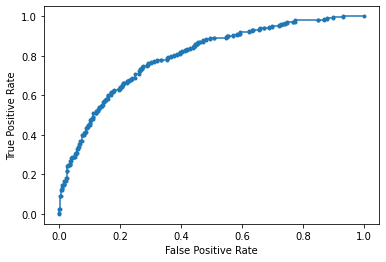

Accuracy: 63.08% Precision: 53.60% Recall: 90.24%
F1: 67.25% AUPRC: 74.15% AUROC: 79.85%
2023-02-07 14:55:38.901656
Fold 2
Bests [array([0.10039532]), array([0.12787362])]
RCI mean derived from training set: -0.2753148000880919
RCI threshold derived from training set: 0.11413447047166603
FIT
2023-02-07 14:55:42.799931
PREDICT
2023-02-07 14:55:54.030187


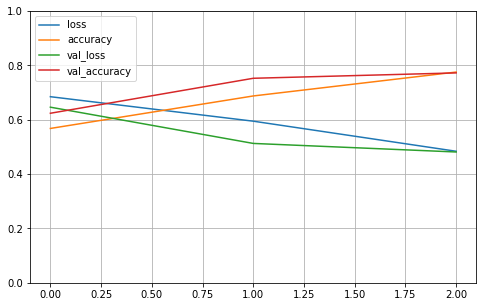

Train set ones/size 2678 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 293 / 707
Range of scores: 0.002023162 to 0.99255496
Score threshold 0.5
Prediction set ones/size 348 / 707


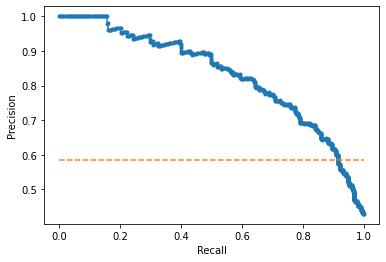

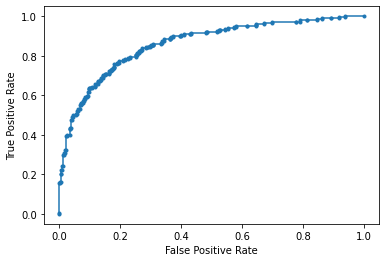

Accuracy: 77.23% Precision: 68.97% Recall: 81.91%
F1: 74.88% AUPRC: 83.13% AUROC: 86.08%
2023-02-07 14:55:54.705099
Fold 3
Bests [array([0.14476914]), array([0.17053436])]
RCI mean derived from training set: -0.2789730485228881
RCI threshold derived from training set: 0.15765175227124162
FIT
2023-02-07 14:55:59.204375
PREDICT
2023-02-07 14:56:06.675529


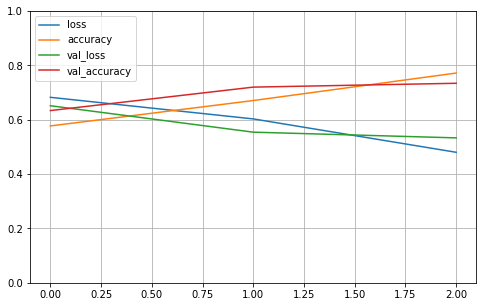

Train set ones/size 2650 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 286 / 707
Range of scores: 0.0031606713 to 0.9942924
Score threshold 0.5
Prediction set ones/size 402 / 707


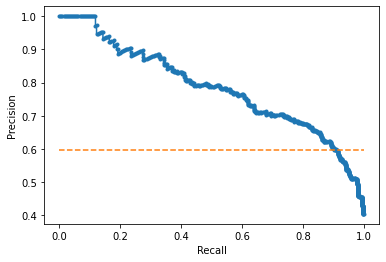

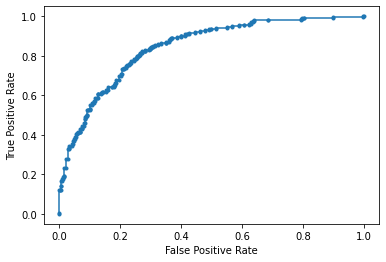

Accuracy: 73.41% Precision: 62.19% Recall: 87.41%
F1: 72.67% AUPRC: 78.57% AUROC: 84.40%
2023-02-07 14:56:07.297634
Fold 4
Bests [array([0.15177318]), array([0.17839662])]
RCI mean derived from training set: -0.2888440364338524
RCI threshold derived from training set: 0.1650848977870467
FIT
2023-02-07 14:56:11.356509
PREDICT
2023-02-07 14:56:18.924191


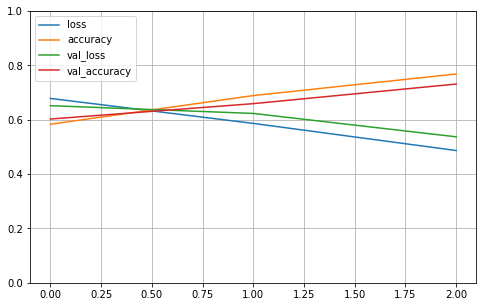

Train set ones/size 2614 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 319 / 707
Range of scores: 0.00095073855 to 0.98598933
Score threshold 0.5
Prediction set ones/size 209 / 707


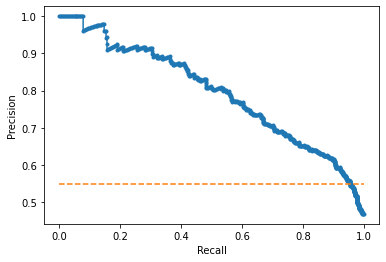

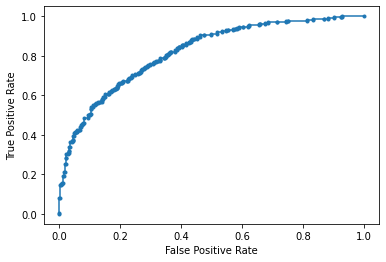

Accuracy: 73.13% Precision: 80.86% Recall: 52.98%
F1: 64.02% AUPRC: 79.57% AUROC: 81.87%
2023-02-07 14:56:19.565705
Fold 5
Bests [array([0.14578331]), array([0.17233566])]
RCI mean derived from training set: -0.2832924759452658
RCI threshold derived from training set: 0.1590594844603611
FIT
2023-02-07 14:56:23.446653
PREDICT
2023-02-07 14:56:30.876275


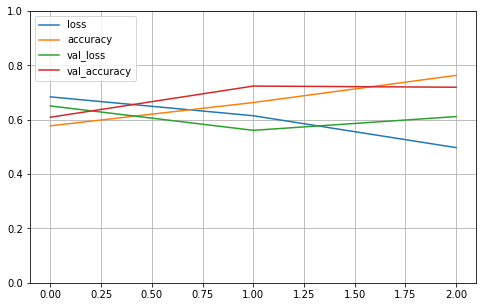

Train set ones/size 2641 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 295 / 706
Range of scores: 0.0014665868 to 0.9410229
Score threshold 0.5
Prediction set ones/size 111 / 706


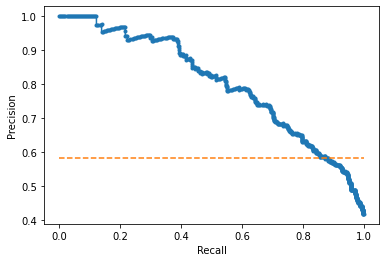

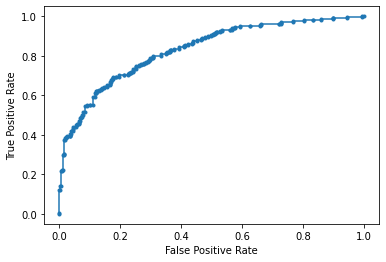

Accuracy: 71.95% Precision: 93.69% Recall: 35.25%
F1: 51.23% AUPRC: 80.37% AUROC: 83.16%
2023-02-07 14:56:31.517445
Fold 6
Bests [array([0.14575725]), array([0.17245982])]
RCI mean derived from training set: -0.28163197472161056
RCI threshold derived from training set: 0.15910853848794015
FIT
2023-02-07 14:56:35.296300
PREDICT
2023-02-07 14:56:42.755973


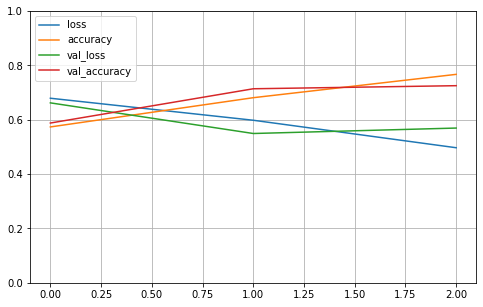

Train set ones/size 2641 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 295 / 706
Range of scores: 0.00044267165 to 0.9622396
Score threshold 0.5
Prediction set ones/size 155 / 706


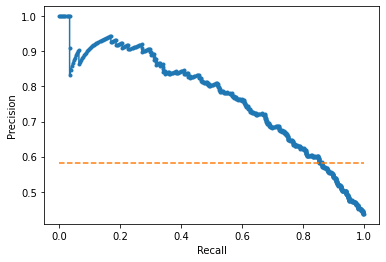

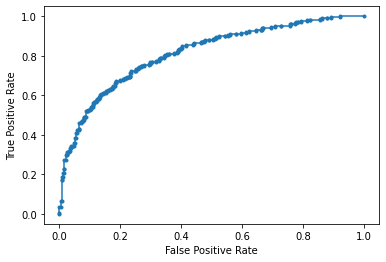

Accuracy: 72.52% Precision: 82.58% Recall: 43.39%
F1: 56.89% AUPRC: 76.75% AUROC: 81.27%
2023-02-07 14:56:43.419765
Fold 7
Bests [array([0.13559703]), array([0.16219614])]
RCI mean derived from training set: -0.28862815410978293
RCI threshold derived from training set: 0.1488965818274719
FIT
2023-02-07 14:56:47.195444
PREDICT
2023-02-07 14:56:54.504669


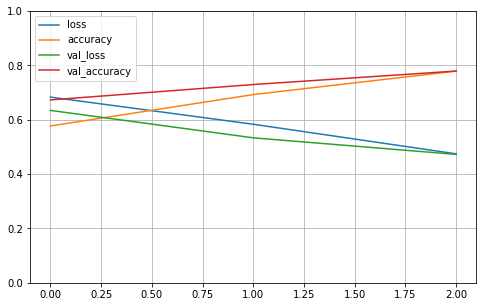

Train set ones/size 2632 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 306 / 706
Range of scores: 0.0044882437 to 0.9907623
Score threshold 0.5
Prediction set ones/size 288 / 706


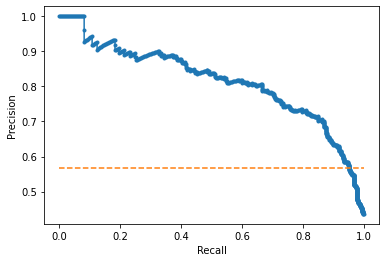

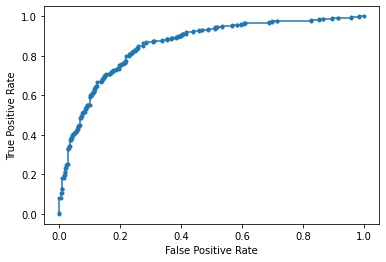

Accuracy: 77.90% Precision: 76.04% Recall: 71.57%
F1: 73.74% AUPRC: 81.51% AUROC: 85.64%
2023-02-07 14:56:55.228678
Fold 8
Bests [array([0.13523721]), array([0.16170299])]
RCI mean derived from training set: -0.28006548551116706
RCI threshold derived from training set: 0.1484700956934104
FIT
2023-02-07 14:56:59.389793
PREDICT
2023-02-07 14:57:06.627783


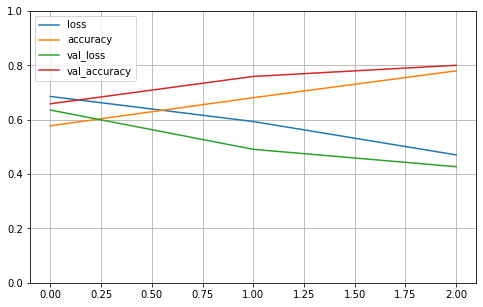

Train set ones/size 2663 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 275 / 706
Range of scores: 0.0016023855 to 0.9944435
Score threshold 0.5
Prediction set ones/size 284 / 706


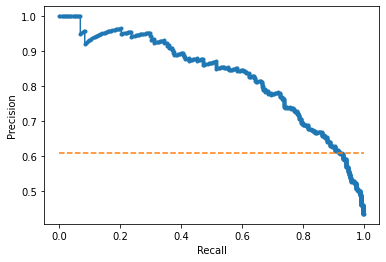

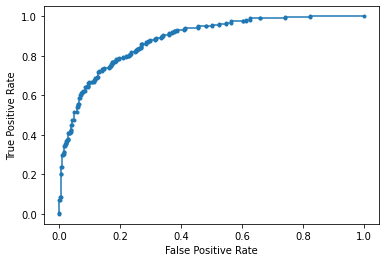

Accuracy: 80.03% Precision: 73.59% Recall: 76.00%
F1: 74.78% AUPRC: 83.07% AUROC: 88.30%
2023-02-07 14:57:07.504407
Fold 9
Bests [array([0.10841374]), array([0.13547719])]
RCI mean derived from training set: -0.28685858487889276
RCI threshold derived from training set: 0.12194546544969043
FIT
2023-02-07 14:57:11.357341
PREDICT
2023-02-07 14:57:18.396403


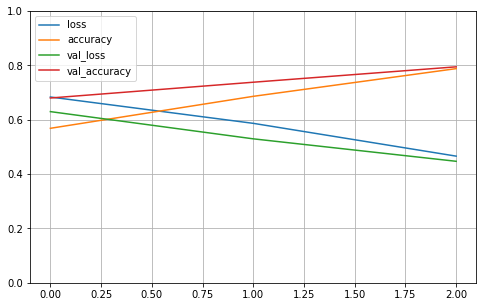

Train set ones/size 2679 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 291 / 706
Range of scores: 0.0014747466 to 0.98715055
Score threshold 0.5
Prediction set ones/size 264 / 706


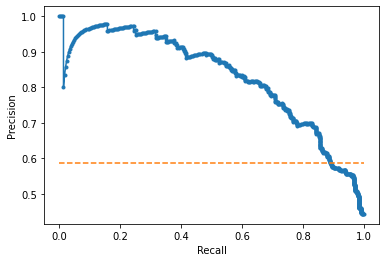

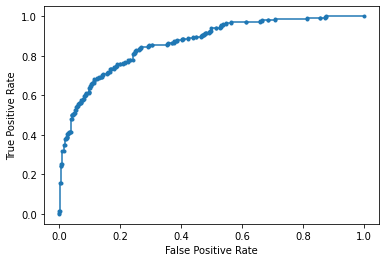

Accuracy: 79.46% Precision: 77.65% Recall: 70.45%
F1: 73.87% AUPRC: 82.88% AUROC: 86.59%
2023-02-07 14:57:19.251727
Fold 10
Bests [array([0.14686357]), array([0.17329647])]
RCI mean derived from training set: -0.28572198597986787
RCI threshold derived from training set: 0.16008002051174575
FIT
2023-02-07 14:57:23.335047
PREDICT
2023-02-07 14:57:30.241829


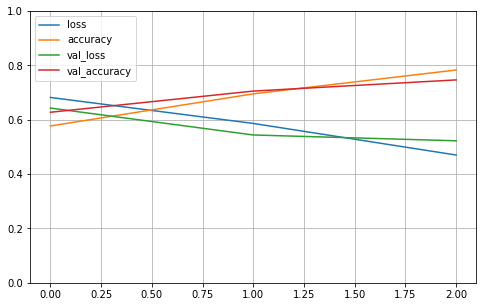

Train set ones/size 2643 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 293 / 706
Range of scores: 0.00055965275 to 0.9884875
Score threshold 0.5
Prediction set ones/size 166 / 706


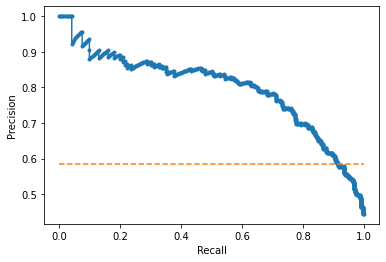

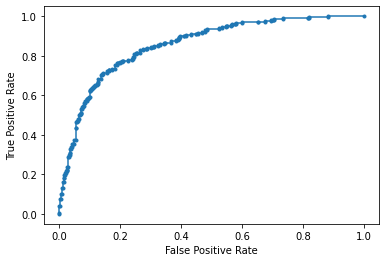

Accuracy: 74.65% Precision: 84.34% Recall: 47.78%
F1: 61.00% AUPRC: 79.79% AUROC: 85.65%
2023-02-07 14:57:30.845355

Completed cross validation 10 folds 3 epochs
 accuracy mean 74.34% +/- 4.92
 precision mean 75.35% +/- 11.53
 recall mean 65.70% +/- 19.46
 F1 mean 67.03% +/- 8.45
 AUPRC mean 79.98% +/- 2.92
 AUROC mean 84.28% +/- 2.67
Finished cell Line 4 HT1080

2023-02-07 14:57:32.195843
Start cell Line 5 HUVEC
Number of RCI values loaded 1488
Num RCI: 1488
Load sequence...
Cross validation...
2023-02-07 14:57:48.432132
splitting
Fold 1
Bests [array([-1.40518103]), array([-1.36967121])]
RCI mean derived from training set: -0.9598692552699883
RCI threshold derived from training set: -1.3874261187909365
FIT
2023-02-07 14:57:51.642084
PREDICT
2023-02-07 14:58:02.974967


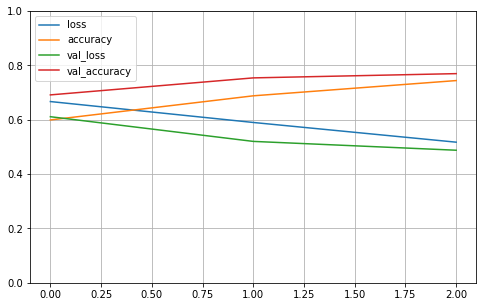

Train set ones/size 5061 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 573 / 959
Range of scores: 0.0024721387 to 0.9834969
Score threshold 0.5
Prediction set ones/size 590 / 959


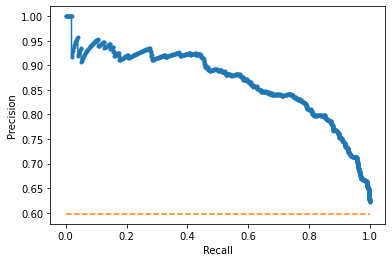

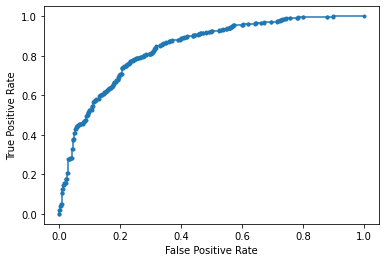

Accuracy: 76.96% Precision: 79.83% Recall: 82.20%
F1: 81.00% AUPRC: 86.85% AUROC: 83.83%
2023-02-07 14:58:03.651344
Fold 2
Bests [array([-1.41552945]), array([-1.37990774])]
RCI mean derived from training set: -0.9636234434704518
RCI threshold derived from training set: -1.3977185929758003
FIT
2023-02-07 14:58:08.176479
PREDICT
2023-02-07 14:58:19.569957


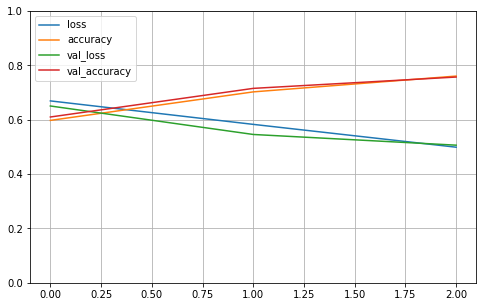

Train set ones/size 5056 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 579 / 959
Range of scores: 0.0036271769 to 0.9950552
Score threshold 0.5
Prediction set ones/size 682 / 959


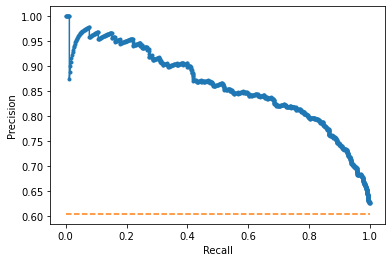

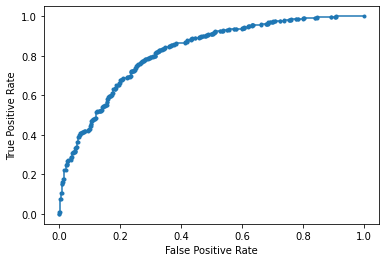

Accuracy: 75.70% Precision: 75.37% Recall: 88.77%
F1: 81.52% AUPRC: 86.09% AUROC: 81.88%
2023-02-07 14:58:20.240690
Fold 3
Bests [array([-1.41969863]), array([-1.38392517])]
RCI mean derived from training set: -0.9593738715434531
RCI threshold derived from training set: -1.4018118992619732
FIT
2023-02-07 14:58:24.943501
PREDICT
2023-02-07 14:58:34.547236


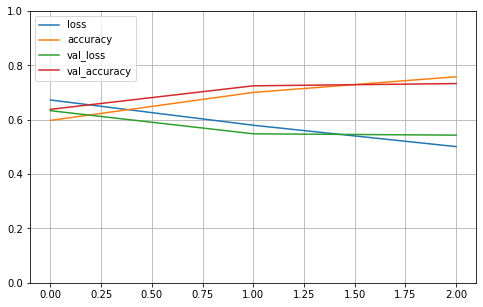

Train set ones/size 5066 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 569 / 959
Range of scores: 0.007638259 to 0.98895407
Score threshold 0.5
Prediction set ones/size 723 / 959


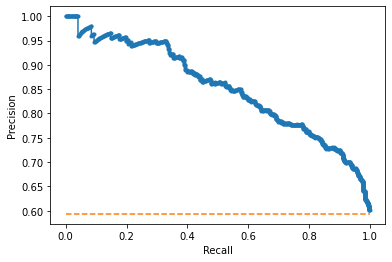

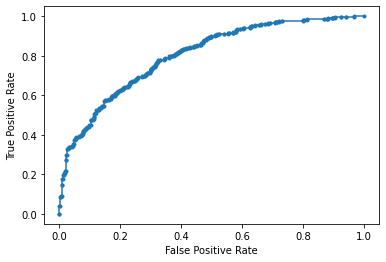

Accuracy: 73.31% Precision: 71.65% Recall: 91.04%
F1: 80.19% AUPRC: 85.31% AUROC: 80.31%
2023-02-07 14:58:35.216817
Fold 4
Bests [array([-1.50523889]), array([-1.46961127])]
RCI mean derived from training set: -0.9491514312294321
RCI threshold derived from training set: -1.4874250780229223
FIT
2023-02-07 14:58:41.369249
PREDICT
2023-02-07 14:58:52.738698


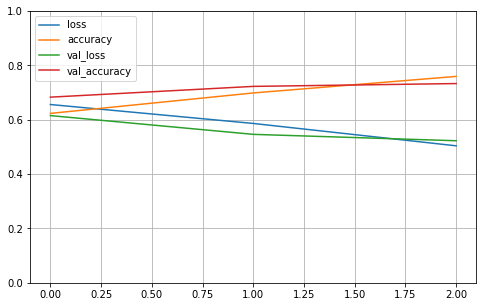

Train set ones/size 5402 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 570 / 959
Range of scores: 0.026656399 to 0.9876409
Score threshold 0.5
Prediction set ones/size 760 / 959


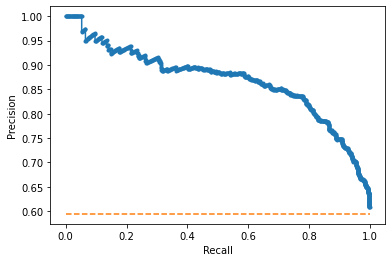

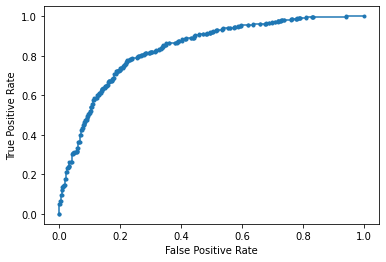

Accuracy: 73.31% Precision: 70.66% Recall: 94.21%
F1: 80.75% AUPRC: 86.80% AUROC: 83.62%
2023-02-07 14:58:53.692207
Fold 5
Bests [array([-1.38354734]), array([-1.34820522])]
RCI mean derived from training set: -0.96778603597219
RCI threshold derived from training set: -1.3658762800858617
FIT
2023-02-07 14:58:58.413565
PREDICT
2023-02-07 14:59:09.787634


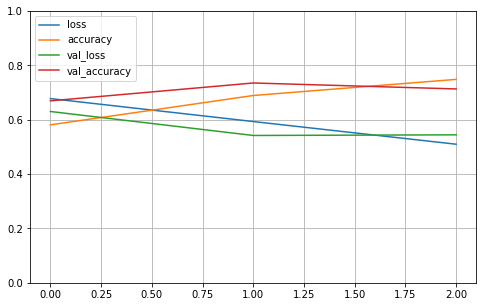

Train set ones/size 4991 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 586 / 959
Range of scores: 0.0026898626 to 0.9938199
Score threshold 0.5
Prediction set ones/size 435 / 959


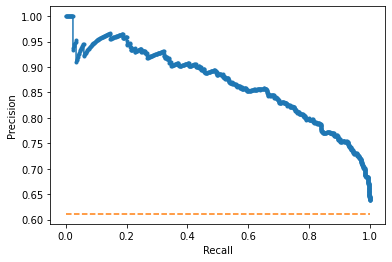

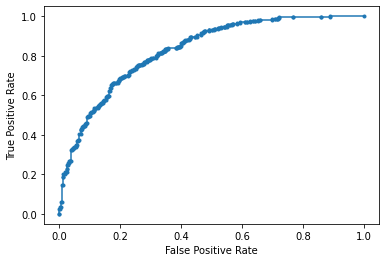

Accuracy: 71.32% Precision: 85.75% Recall: 63.65%
F1: 73.07% AUPRC: 86.91% AUROC: 82.89%
2023-02-07 14:59:10.457591
Fold 6
Bests [array([-1.47086152]), array([-1.43536781])]
RCI mean derived from training set: -0.9634300983429895
RCI threshold derived from training set: -1.4531146624625868
FIT
2023-02-07 14:59:15.126499
PREDICT
2023-02-07 14:59:26.483903


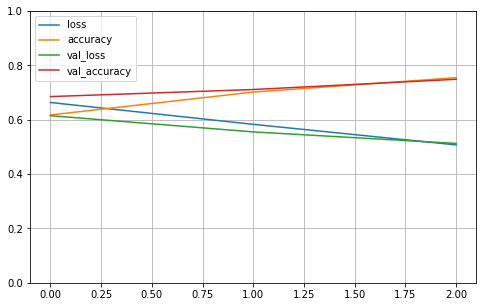

Train set ones/size 5350 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 594 / 959
Range of scores: 0.0054656416 to 0.9805172
Score threshold 0.5
Prediction set ones/size 545 / 959


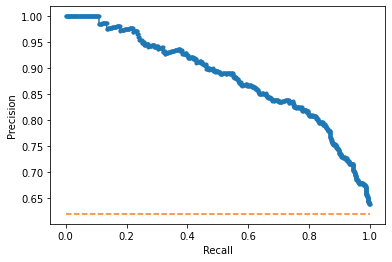

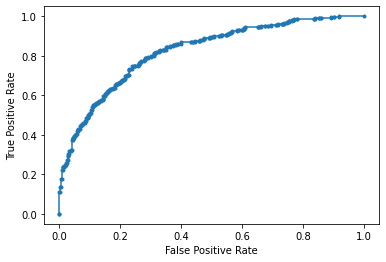

Accuracy: 74.87% Precision: 82.39% Recall: 75.59%
F1: 78.84% AUPRC: 88.20% AUROC: 82.33%
2023-02-07 14:59:27.166661
Fold 7
Bests [array([-1.36247112]), array([-1.32777253])]
RCI mean derived from training set: -0.9433161291993047
RCI threshold derived from training set: -1.345121825930911
FIT
2023-02-07 14:59:33.048126
PREDICT
2023-02-07 14:59:44.499500


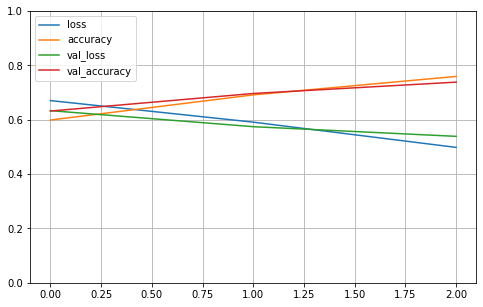

Train set ones/size 4996 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 515 / 959
Range of scores: 0.0068496815 to 0.99614173
Score threshold 0.5
Prediction set ones/size 688 / 959


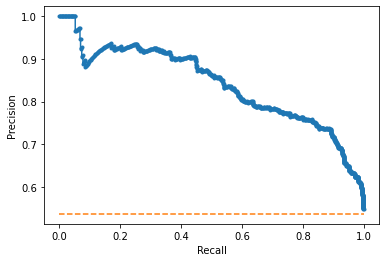

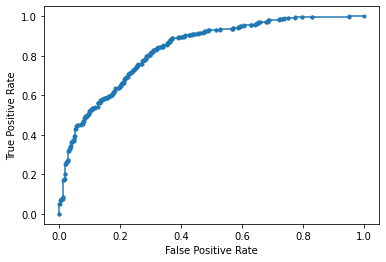

Accuracy: 73.83% Precision: 69.19% Recall: 92.43%
F1: 79.14% AUPRC: 84.06% AUROC: 83.31%
2023-02-07 14:59:45.560124
Fold 8
Bests [array([-1.40644081]), array([-1.37131015])]
RCI mean derived from training set: -0.951527679225956
RCI threshold derived from training set: -1.388875481235909
FIT
2023-02-07 14:59:50.473640
PREDICT
2023-02-07 15:00:00.079183


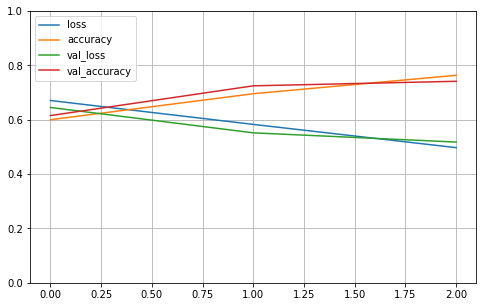

Train set ones/size 5074 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 560 / 959
Range of scores: 0.0037220642 to 0.994802
Score threshold 0.5
Prediction set ones/size 644 / 959


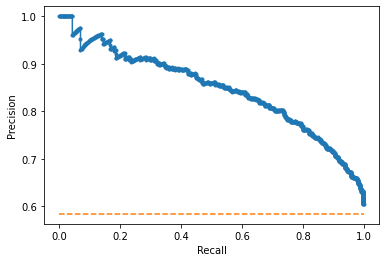

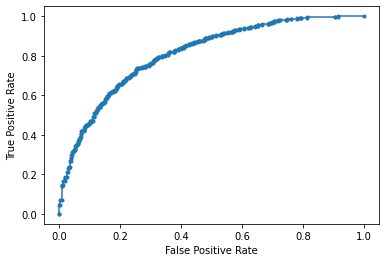

Accuracy: 74.14% Precision: 74.22% Recall: 85.36%
F1: 79.40% AUPRC: 84.71% AUROC: 81.08%
2023-02-07 15:00:00.753902
Fold 9
Bests [array([-1.36967468]), array([-1.33491752])]
RCI mean derived from training set: -0.9602096008389339
RCI threshold derived from training set: -1.3522960987533867
FIT
2023-02-07 15:00:05.635582
PREDICT
2023-02-07 15:00:15.157627


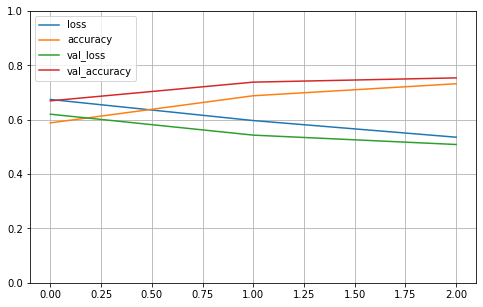

Train set ones/size 4997 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 552 / 959
Range of scores: 0.00051768526 to 0.9750377
Score threshold 0.5
Prediction set ones/size 498 / 959


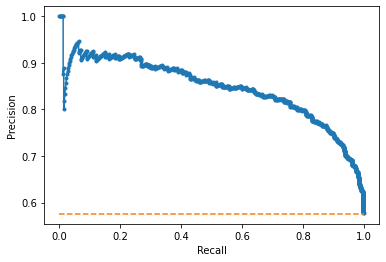

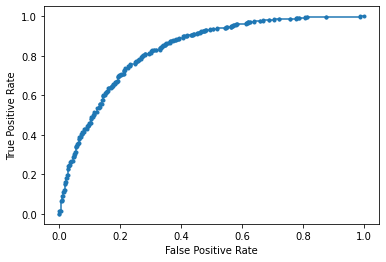

Accuracy: 75.39% Precision: 81.73% Recall: 73.73%
F1: 77.52% AUPRC: 84.61% AUROC: 83.22%
2023-02-07 15:00:15.806569
Fold 10
Bests [array([-1.44026726]), array([-1.40529856])]
RCI mean derived from training set: -0.9577084034526707
RCI threshold derived from training set: -1.422782906585374
FIT
2023-02-07 15:00:20.366735
PREDICT
2023-02-07 15:00:29.995499


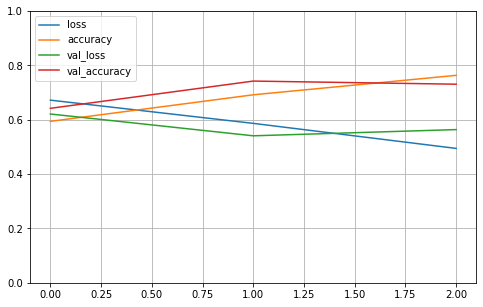

Train set ones/size 5123 / 8631
Compute valiation accuracy
Valid sizes (958, 4997) (958,)
Valid set ones/size 577 / 958
Range of scores: 0.0077498434 to 0.99665594
Score threshold 0.5
Prediction set ones/size 771 / 958


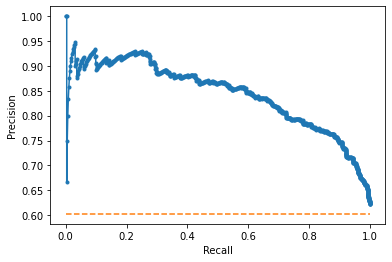

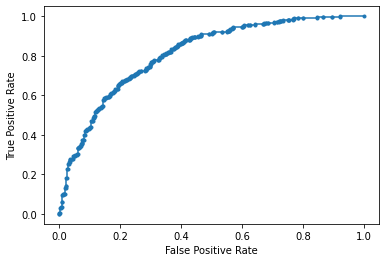

Accuracy: 73.07% Precision: 70.69% Recall: 94.45%
F1: 80.86% AUPRC: 84.40% AUROC: 81.11%
2023-02-07 15:00:30.696013

Completed cross validation 10 folds 3 epochs
 accuracy mean 74.19% +/- 1.60
 precision mean 76.15% +/- 5.86
 recall mean 84.14% +/- 10.28
 F1 mean 79.23% +/- 2.48
 AUPRC mean 85.79% +/- 1.37
 AUROC mean 82.36% +/- 1.22
Finished cell Line 5 HUVEC

2023-02-07 15:00:32.123164
Start cell Line 6 MCF.7
Number of RCI values loaded 2156
Num RCI: 2156
Load sequence...
Cross validation...
2023-02-07 15:00:49.857677
splitting
Fold 1
Bests [array([-1.97870682]), array([-1.93306207])]
RCI mean derived from training set: -1.1349753646536942
RCI threshold derived from training set: -1.9558844445119619
FIT
2023-02-07 15:00:55.531079
PREDICT
2023-02-07 15:01:07.014419


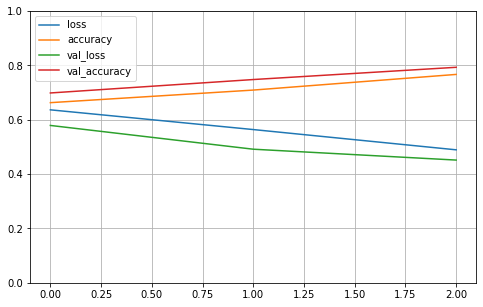

Train set ones/size 6877 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 799 / 1154
Range of scores: 0.005920561 to 0.98931926
Score threshold 0.5
Prediction set ones/size 852 / 1154


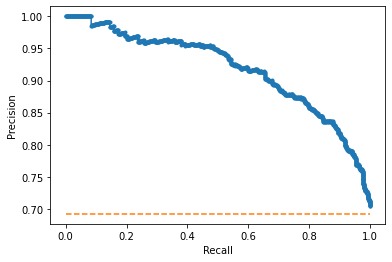

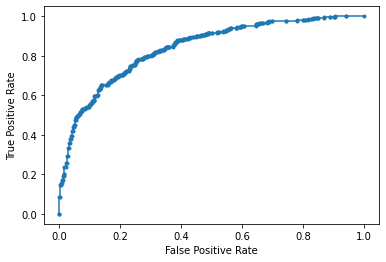

Accuracy: 79.29% Precision: 82.86% Recall: 88.36%
F1: 85.52% AUPRC: 91.81% AUROC: 83.97%
2023-02-07 15:01:07.868047
Fold 2
Bests [array([-2.12631489]), array([-2.08017407])]
RCI mean derived from training set: -1.1299156250621327
RCI threshold derived from training set: -2.103244483760185
FIT
2023-02-07 15:01:13.392353
PREDICT
2023-02-07 15:01:24.958096


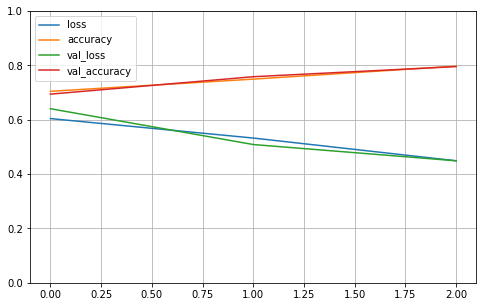

Train set ones/size 7326 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 799 / 1154
Range of scores: 0.0010152115 to 0.9964858
Score threshold 0.5
Prediction set ones/size 903 / 1154


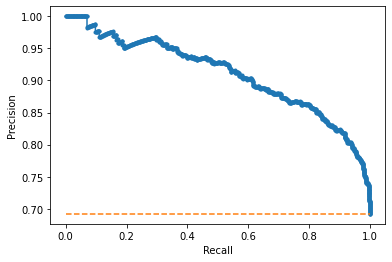

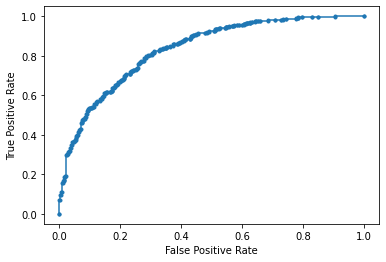

Accuracy: 79.55% Precision: 81.17% Recall: 91.74%
F1: 86.13% AUPRC: 91.03% AUROC: 83.32%
2023-02-07 15:01:25.672114
Fold 3
Bests [array([-2.00504892]), array([-1.96012518])]
RCI mean derived from training set: -1.1188958279423948
RCI threshold derived from training set: -1.9825870460704316
FIT
2023-02-07 15:01:32.034697
PREDICT
2023-02-07 15:01:43.826864


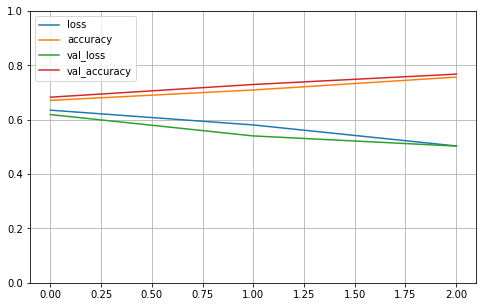

Train set ones/size 6990 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 776 / 1154
Range of scores: 0.024443002 to 0.9797472
Score threshold 0.5
Prediction set ones/size 892 / 1154


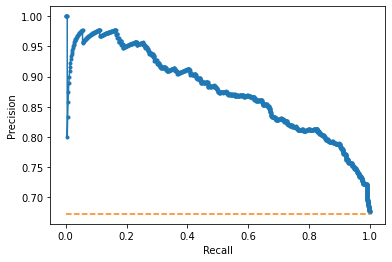

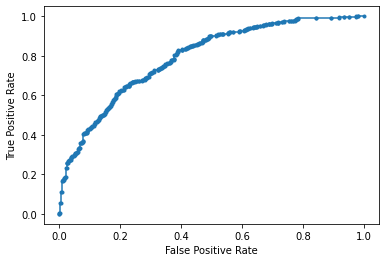

Accuracy: 76.78% Precision: 78.48% Recall: 90.21%
F1: 83.93% AUPRC: 87.63% AUROC: 79.19%
2023-02-07 15:01:44.884826
Fold 4
Bests [array([-1.97367448]), array([-1.92847165])]
RCI mean derived from training set: -1.1232048012686637
RCI threshold derived from training set: -1.951073065712393
FIT
2023-02-07 15:01:50.150001
PREDICT
2023-02-07 15:02:11.859666


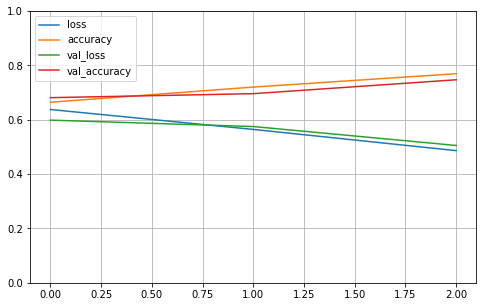

Train set ones/size 6897 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 770 / 1154
Range of scores: 0.0049338257 to 0.99178785
Score threshold 0.5
Prediction set ones/size 812 / 1154


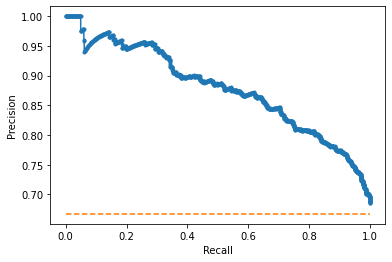

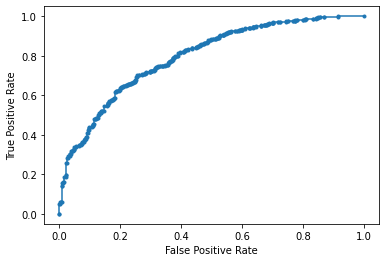

Accuracy: 74.70% Precision: 79.43% Recall: 83.77%
F1: 81.54% AUPRC: 87.84% AUROC: 79.49%
2023-02-07 15:02:12.561523
Fold 5
Bests [array([-2.13148436]), array([-2.08544339])]
RCI mean derived from training set: -1.118375560225412
RCI threshold derived from training set: -2.10846387182867
FIT
2023-02-07 15:02:17.643229
PREDICT
2023-02-07 15:02:29.137088


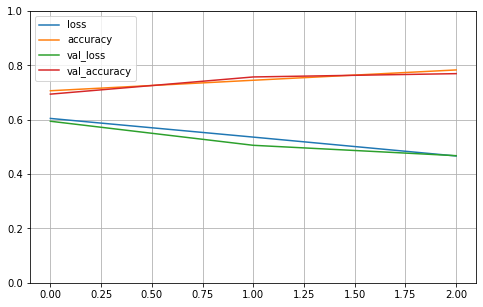

Train set ones/size 7353 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 788 / 1154
Range of scores: 0.0025541368 to 0.9958003
Score threshold 0.5
Prediction set ones/size 896 / 1154


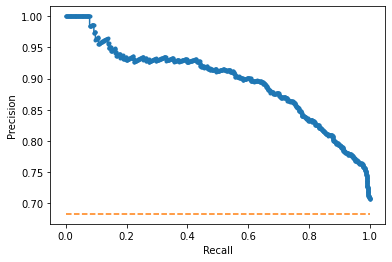

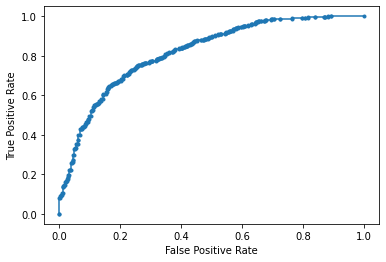

Accuracy: 76.95% Precision: 79.13% Recall: 89.97%
F1: 84.20% AUPRC: 89.61% AUROC: 81.88%
2023-02-07 15:02:29.849421
Fold 6
Bests [array([-2.01217886]), array([-1.96695116])]
RCI mean derived from training set: -1.1163208856453477
RCI threshold derived from training set: -1.9895650124687956
FIT
2023-02-07 15:02:35.024151
PREDICT
2023-02-07 15:02:46.720194


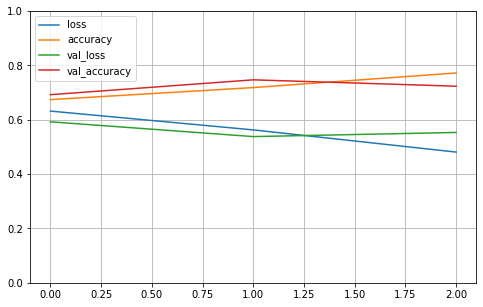

Train set ones/size 7026 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 754 / 1153
Range of scores: 0.005719249 to 0.9878335
Score threshold 0.5
Prediction set ones/size 585 / 1153


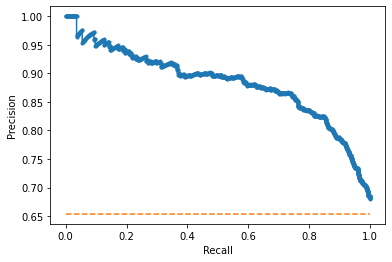

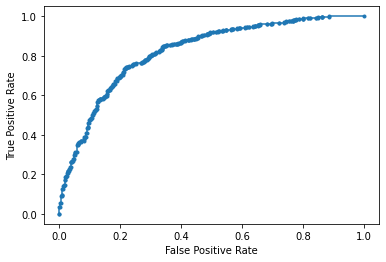

Accuracy: 72.33% Precision: 87.18% Recall: 67.64%
F1: 76.18% AUPRC: 88.32% AUROC: 82.19%
2023-02-07 15:02:47.570074
Fold 7
Bests [array([-2.05817564]), array([-2.01266803])]
RCI mean derived from training set: -1.1271018489664804
RCI threshold derived from training set: -2.035421838040996
FIT
2023-02-07 15:02:53.739828
PREDICT
2023-02-07 15:03:05.002788


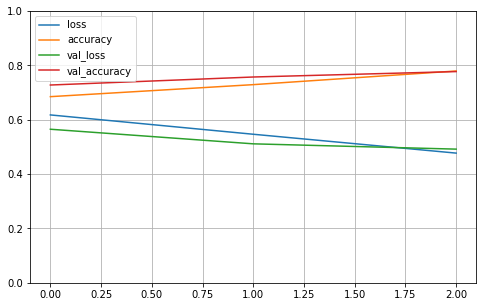

Train set ones/size 7097 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 810 / 1153
Range of scores: 0.010217341 to 0.9986727
Score threshold 0.5
Prediction set ones/size 989 / 1153


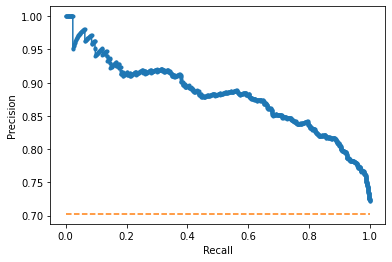

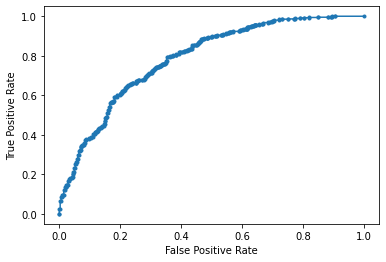

Accuracy: 77.71% Precision: 77.96% Recall: 95.19%
F1: 85.71% AUPRC: 88.08% AUROC: 78.66%
2023-02-07 15:03:05.856285
Fold 8
Bests [array([-2.08232469]), array([-2.03608834])]
RCI mean derived from training set: -1.1243382103515702
RCI threshold derived from training set: -2.0592065152003
FIT
2023-02-07 15:03:11.635587
PREDICT
2023-02-07 15:03:23.956246


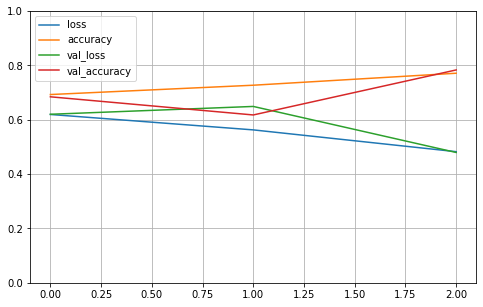

Train set ones/size 7206 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 813 / 1153
Range of scores: 0.027861014 to 0.9897267
Score threshold 0.5
Prediction set ones/size 979 / 1153


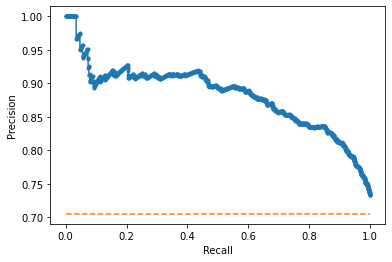

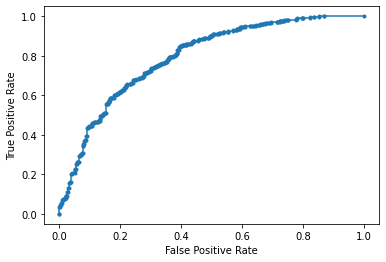

Accuracy: 78.32% Precision: 78.75% Recall: 94.83%
F1: 86.05% AUPRC: 88.24% AUROC: 79.34%
2023-02-07 15:03:24.669006
Fold 9
Bests [array([-1.95814267]), array([-1.91314348])]
RCI mean derived from training set: -1.1209396478010016
RCI threshold derived from training set: -1.9356430777563065
FIT
2023-02-07 15:03:30.052489
PREDICT
2023-02-07 15:03:41.353021


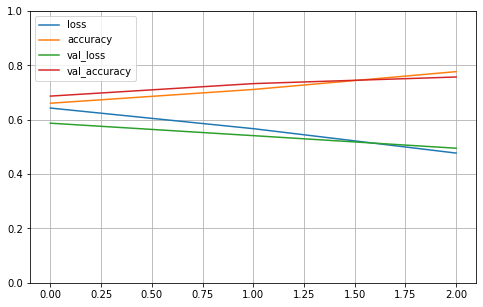

Train set ones/size 6887 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 773 / 1153
Range of scores: 0.003861903 to 0.9923603
Score threshold 0.5
Prediction set ones/size 889 / 1153


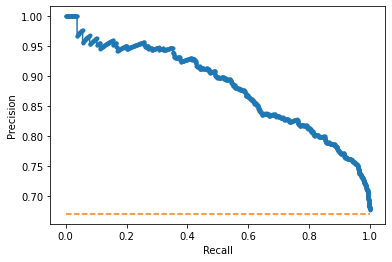

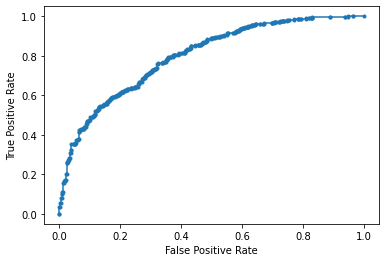

Accuracy: 75.72% Precision: 77.73% Recall: 89.39%
F1: 83.15% AUPRC: 88.26% AUROC: 79.91%
2023-02-07 15:03:42.059575
Fold 10
Bests [array([-2.06154835]), array([-2.01584771])]
RCI mean derived from training set: -1.1235682388817185
RCI threshold derived from training set: -2.038698030504217
FIT
2023-02-07 15:03:48.459989
PREDICT
2023-02-07 15:03:59.887922


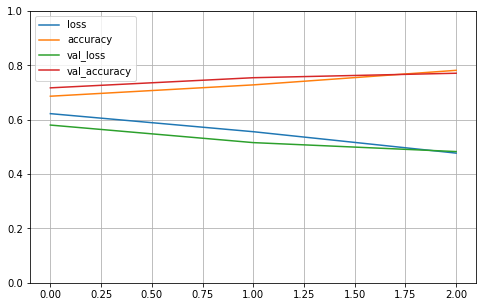

Train set ones/size 7125 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 783 / 1153
Range of scores: 0.00915038 to 0.9939558
Score threshold 0.5
Prediction set ones/size 821 / 1153


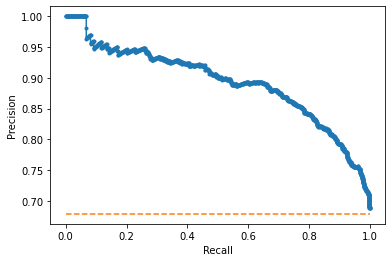

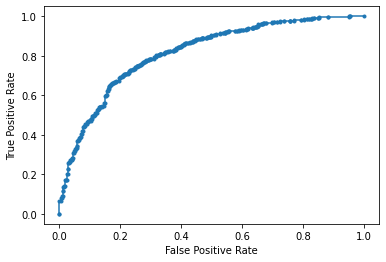

Accuracy: 77.10% Precision: 81.61% Recall: 85.57%
F1: 83.54% AUPRC: 89.28% AUROC: 81.55%
2023-02-07 15:04:00.581580

Completed cross validation 10 folds 3 epochs
 accuracy mean 76.84% +/- 2.17
 precision mean 80.43% +/- 2.91
 recall mean 87.67% +/- 7.89
 F1 mean 83.60% +/- 2.99
 AUPRC mean 89.01% +/- 1.42
 AUROC mean 80.95% +/- 1.88
Finished cell Line 6 MCF.7

2023-02-07 15:04:02.038594
Start cell Line 7 NCI.H460
Number of RCI values loaded 610
Num RCI: 610
Load sequence...
Cross validation...
2023-02-07 15:04:09.336298
splitting
Fold 1
Bests [array([-2.46525744]), array([-2.41961708]), array([1.27725186]), array([1.32289222])]
RCI mean derived from training set: -1.3083752442899723
RCI threshold derived from training set: -0.5711826107185083
FIT
2023-02-07 15:04:13.299877
PREDICT
2023-02-07 15:04:18.817619


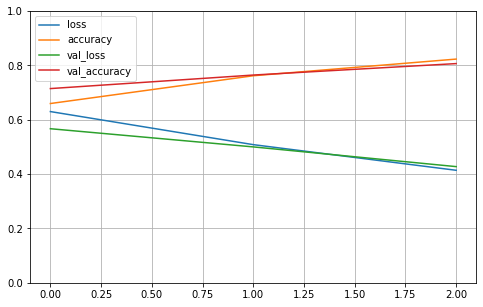

Train set ones/size 1541 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 171 / 522
Range of scores: 0.01377199 to 0.994269
Score threshold 0.5
Prediction set ones/size 178 / 522


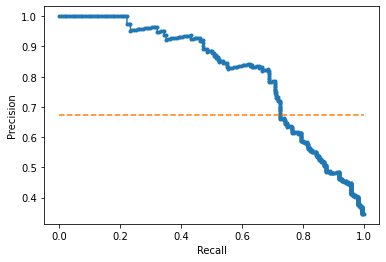

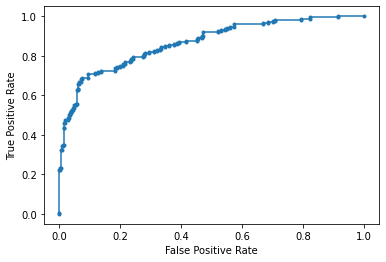

Accuracy: 80.65% Precision: 69.66% Recall: 72.51%
F1: 71.06% AUPRC: 81.27% AUROC: 86.67%
2023-02-07 15:04:19.432129
Fold 2
Bests [array([-2.45433818]), array([-2.40809846]), array([1.38355829]), array([1.429798])]
RCI mean derived from training set: -1.297517116314669
RCI threshold derived from training set: -0.5122700880886171
FIT
2023-02-07 15:04:22.940872
PREDICT
2023-02-07 15:04:29.225207


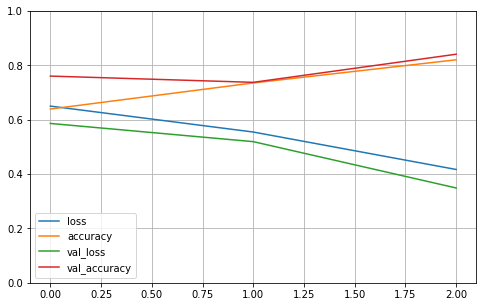

Train set ones/size 1561 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 143 / 522
Range of scores: 0.002580833 to 0.97421646
Score threshold 0.5
Prediction set ones/size 92 / 522


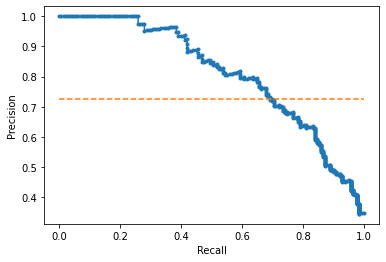

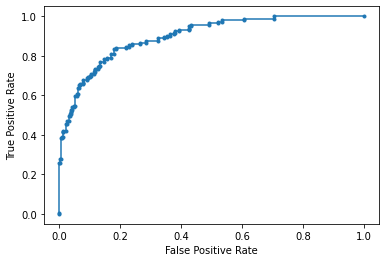

Accuracy: 84.10% Precision: 82.61% Recall: 53.15%
F1: 64.68% AUPRC: 81.07% AUROC: 89.91%
2023-02-07 15:04:29.839753
Fold 3
Bests [array([-2.44446036]), array([-2.39926263]), array([1.26175281]), array([1.30695053])]
RCI mean derived from training set: -1.3034471971535022
RCI threshold derived from training set: -0.5687549125897247
FIT
2023-02-07 15:04:33.284278
PREDICT
2023-02-07 15:04:39.123807


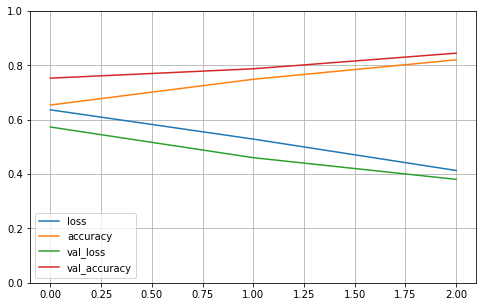

Train set ones/size 1544 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 168 / 522
Range of scores: 0.012284847 to 0.9916619
Score threshold 0.5
Prediction set ones/size 169 / 522


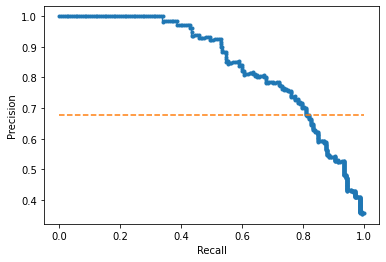

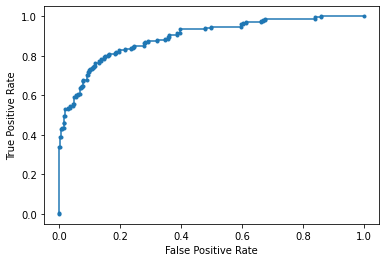

Accuracy: 84.48% Precision: 75.74% Recall: 76.19%
F1: 75.96% AUPRC: 84.42% AUROC: 89.39%
2023-02-07 15:04:39.780652
Fold 4
Bests [array([-2.90861911]), array([-2.86142257])]
RCI mean derived from training set: -1.2912956771833086
RCI threshold derived from training set: -2.8850208371821444
FIT
2023-02-07 15:04:43.181401
PREDICT
2023-02-07 15:04:49.184610


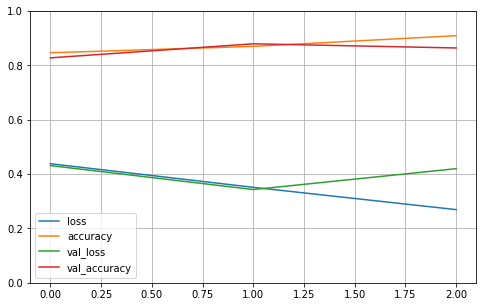

Train set ones/size 4007 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 432 / 522
Range of scores: 0.055938534 to 0.99994576
Score threshold 0.5
Prediction set ones/size 503 / 522


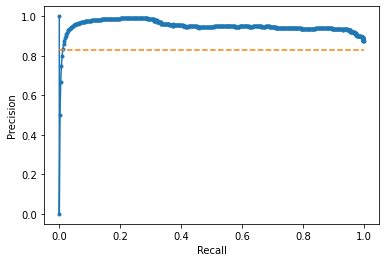

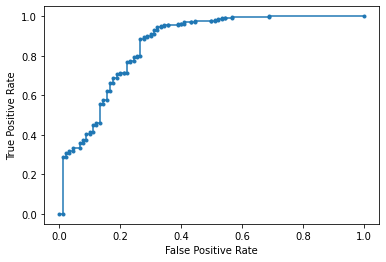

Accuracy: 86.40% Precision: 85.88% Recall: 100.00%
F1: 92.41% AUPRC: 94.96% AUROC: 85.86%
2023-02-07 15:04:50.043085
Fold 5
Bests [array([-2.41523802]), array([-2.36929378]), array([1.35218935]), array([1.39813359])]
RCI mean derived from training set: -1.3037518440344902
RCI threshold derived from training set: -0.5085522165584941
FIT
2023-02-07 15:04:53.948016
PREDICT
2023-02-07 15:04:59.966179


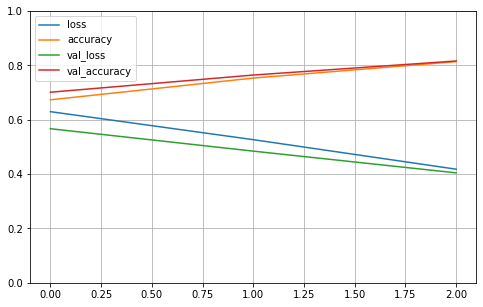

Train set ones/size 1527 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 177 / 522
Range of scores: 0.0031399361 to 0.99192274
Score threshold 0.5
Prediction set ones/size 137 / 522


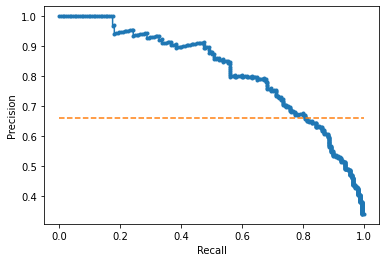

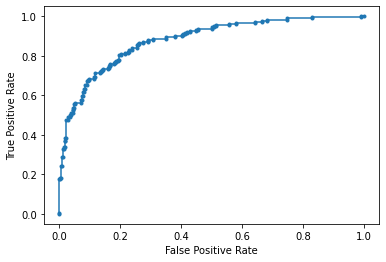

Accuracy: 81.61% Precision: 79.56% Recall: 61.58%
F1: 69.43% AUPRC: 81.67% AUROC: 88.02%
2023-02-07 15:05:00.568479
Fold 6
RCI mean derived from training set: -1.3049483705556737
RCI threshold derived from training set: -1.3049483705556737
FIT
2023-02-07 15:05:05.391376
PREDICT
2023-02-07 15:05:11.073209


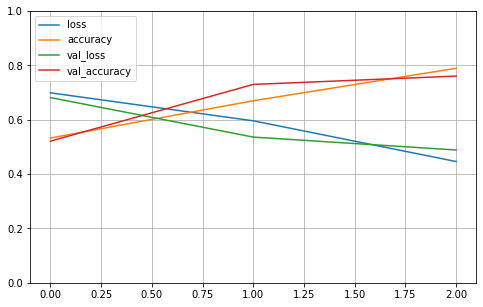

Train set ones/size 2414 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 261 / 522
Range of scores: 0.0027957123 to 0.9924126
Score threshold 0.5
Prediction set ones/size 192 / 522


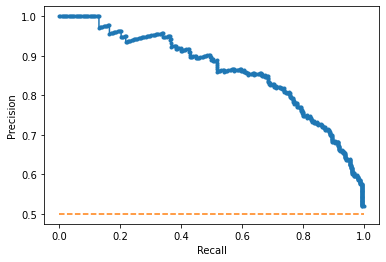

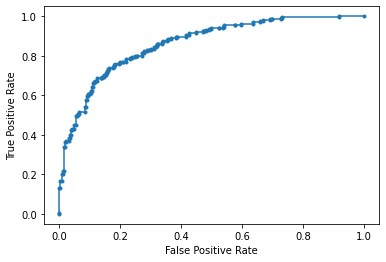

Accuracy: 76.05% Precision: 85.42% Recall: 62.84%
F1: 72.41% AUPRC: 86.39% AUROC: 86.28%
2023-02-07 15:05:11.746436
Fold 7
RCI mean derived from training set: -1.3032546083947198
RCI threshold derived from training set: -1.3032546083947198
FIT
2023-02-07 15:05:15.223957
PREDICT
2023-02-07 15:05:21.403847


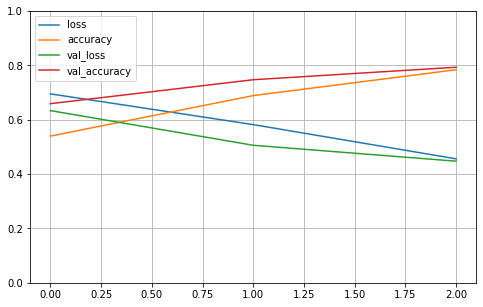

Train set ones/size 2406 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 269 / 522
Range of scores: 0.00547031 to 0.99506086
Score threshold 0.5
Prediction set ones/size 309 / 522


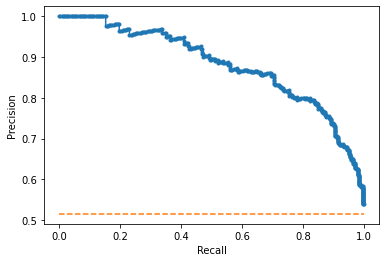

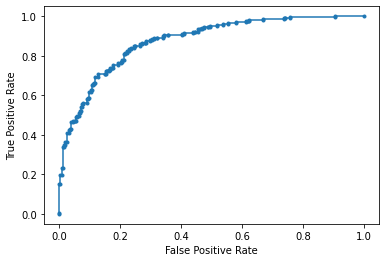

Accuracy: 79.31% Precision: 76.05% Recall: 87.36%
F1: 81.31% AUPRC: 88.18% AUROC: 87.53%
2023-02-07 15:05:22.083259
Fold 8
Bests [array([-2.44325081]), array([-2.3978974]), array([1.27572824]), array([1.32108164])]
RCI mean derived from training set: -1.3093740925122417
RCI threshold derived from training set: -0.561084581029597
FIT
2023-02-07 15:05:25.629952
PREDICT
2023-02-07 15:05:31.618847


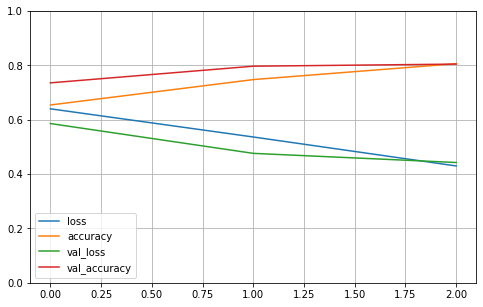

Train set ones/size 1554 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 158 / 522
Range of scores: 0.015448111 to 0.9948515
Score threshold 0.5
Prediction set ones/size 136 / 522


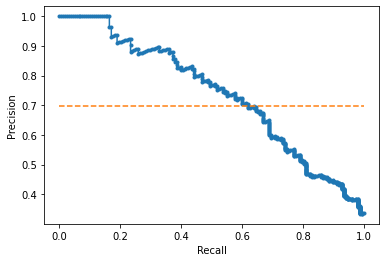

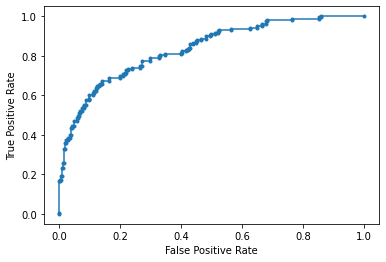

Accuracy: 80.46% Precision: 70.59% Recall: 60.76%
F1: 65.31% AUPRC: 73.82% AUROC: 83.62%
2023-02-07 15:05:32.463507
Fold 9
RCI mean derived from training set: -1.3158440667511175
RCI threshold derived from training set: -1.3158440667511175
FIT
2023-02-07 15:05:36.100371
PREDICT
2023-02-07 15:05:42.106822


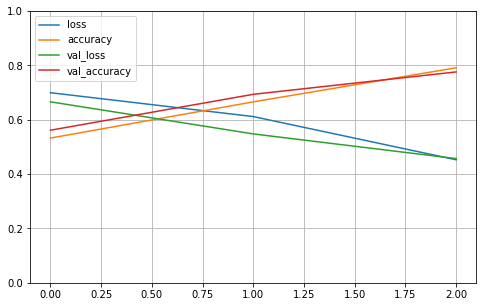

Train set ones/size 2387 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 289 / 522
Range of scores: 0.003454116 to 0.9965405
Score threshold 0.5
Prediction set ones/size 310 / 522


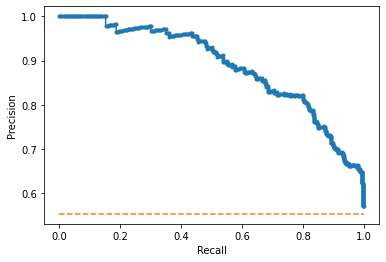

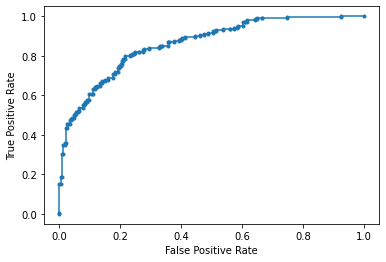

Accuracy: 77.59% Precision: 77.74% Recall: 83.39%
F1: 80.47% AUPRC: 88.86% AUROC: 86.12%
2023-02-07 15:05:42.830597
Fold 10
RCI mean derived from training set: -1.312804497835249
RCI threshold derived from training set: -1.312804497835249
FIT
2023-02-07 15:05:46.895440
PREDICT
2023-02-07 15:05:52.434980


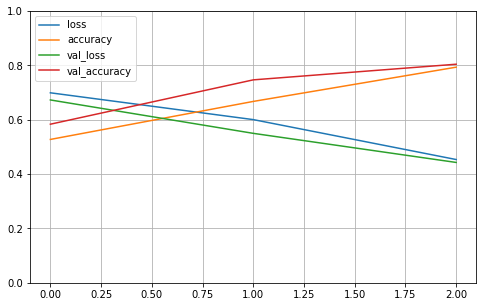

Train set ones/size 2392 / 4698
Compute valiation accuracy
Valid sizes (521, 4997) (521,)
Valid set ones/size 283 / 521
Range of scores: 0.0098324185 to 0.9964833
Score threshold 0.5
Prediction set ones/size 281 / 521


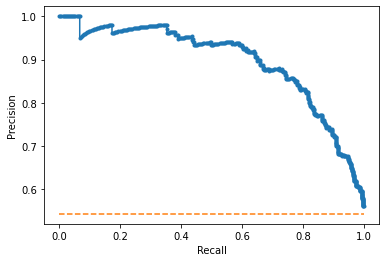

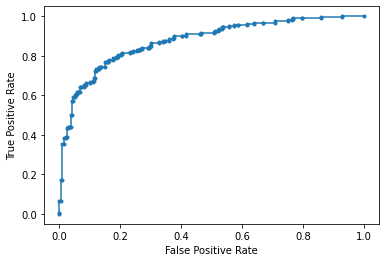

Accuracy: 80.42% Precision: 82.21% Recall: 81.63%
F1: 81.91% AUPRC: 89.68% AUROC: 87.55%
2023-02-07 15:05:53.078676

Completed cross validation 10 folds 3 epochs
 accuracy mean 81.11% +/- 3.18
 precision mean 78.55% +/- 5.67
 recall mean 73.94% +/- 14.52
 F1 mean 75.49% +/- 8.65
 AUPRC mean 85.03% +/- 5.90
 AUROC mean 87.09% +/- 1.82
Finished cell Line 7 NCI.H460

2023-02-07 15:05:54.397957
Start cell Line 8 NHEK
Number of RCI values loaded 1080
Num RCI: 1080
Load sequence...
Cross validation...
2023-02-07 15:06:07.765796
splitting
Fold 1
Bests [array([-1.16022825]), array([-1.12544813])]
RCI mean derived from training set: -0.653079659387811
RCI threshold derived from training set: -1.1428381874133302
FIT
2023-02-07 15:06:11.907588
PREDICT
2023-02-07 15:06:20.037121


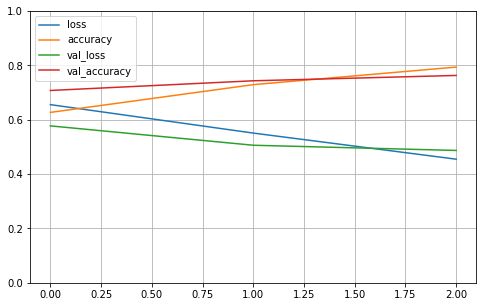

Train set ones/size 4567 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 520 / 814
Range of scores: 0.003348472 to 0.9949891
Score threshold 0.5
Prediction set ones/size 623 / 814


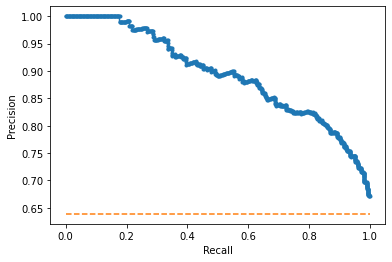

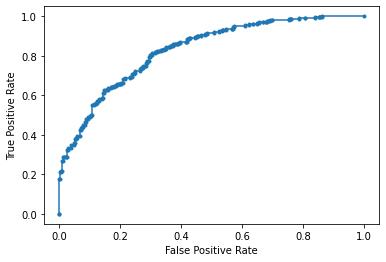

Accuracy: 76.29% Precision: 76.24% Recall: 91.35%
F1: 83.11% AUPRC: 89.37% AUROC: 82.97%
2023-02-07 15:06:20.725635
Fold 2
Bests [array([-1.05838436]), array([-1.0234474])]
RCI mean derived from training set: -0.6412958734216999
RCI threshold derived from training set: -1.0409158799365157
FIT
2023-02-07 15:06:26.834198
PREDICT
2023-02-07 15:06:34.743836


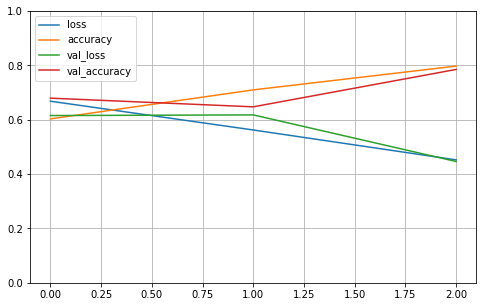

Train set ones/size 4322 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 479 / 814
Range of scores: 0.0030069891 to 0.9948714
Score threshold 0.5
Prediction set ones/size 538 / 814


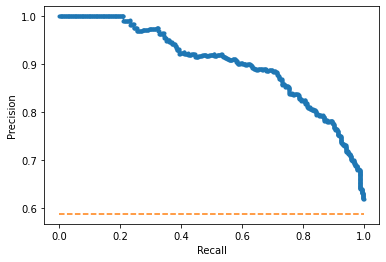

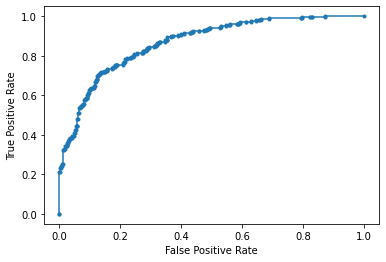

Accuracy: 78.50% Precision: 78.25% Recall: 87.89%
F1: 82.79% AUPRC: 90.23% AUROC: 86.72%
2023-02-07 15:06:35.404093
Fold 3
Bests [array([-1.10285142]), array([-1.06861577])]
RCI mean derived from training set: -0.6430724309195246
RCI threshold derived from training set: -1.0857335936056383
FIT
2023-02-07 15:06:40.672663
PREDICT
2023-02-07 15:06:51.969471


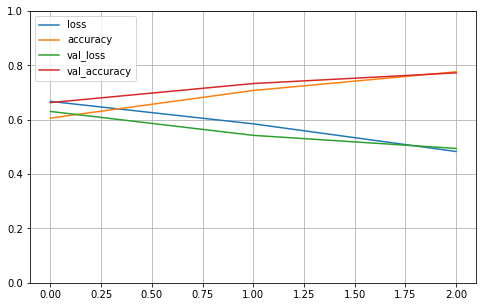

Train set ones/size 4483 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 504 / 813
Range of scores: 0.0062867017 to 0.98438
Score threshold 0.5
Prediction set ones/size 461 / 813


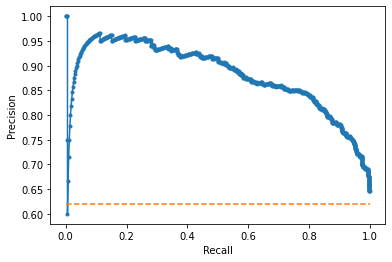

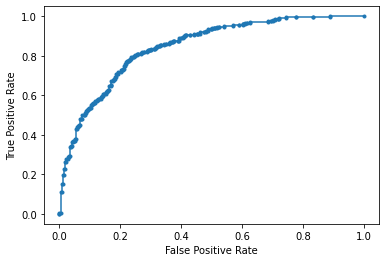

Accuracy: 77.24% Precision: 84.60% Recall: 77.38%
F1: 80.83% AUPRC: 88.09% AUROC: 84.51%
2023-02-07 15:06:52.648184
Fold 4
Bests [array([-1.25157366]), array([-1.2159644])]
RCI mean derived from training set: -0.6520008468916518
RCI threshold derived from training set: -1.2337690323217538
FIT
2023-02-07 15:06:57.112971
PREDICT
2023-02-07 15:07:08.421893


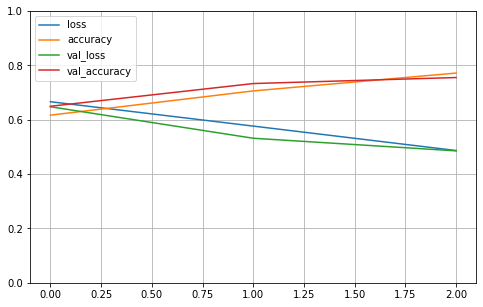

Train set ones/size 4660 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 512 / 813
Range of scores: 0.010752403 to 0.9978759
Score threshold 0.5
Prediction set ones/size 519 / 813


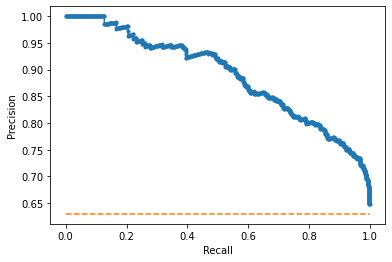

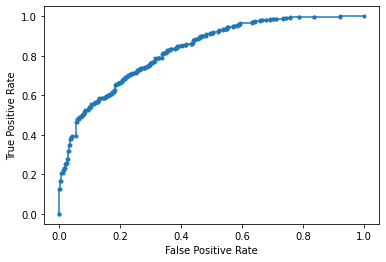

Accuracy: 75.52% Precision: 80.15% Recall: 81.25%
F1: 80.70% AUPRC: 88.95% AUROC: 82.97%
2023-02-07 15:07:09.110177
Fold 5
Bests [array([-1.21697341]), array([-1.18165036])]
RCI mean derived from training set: -0.6458179012979914
RCI threshold derived from training set: -1.1993118833737648
FIT
2023-02-07 15:07:13.433610
PREDICT
2023-02-07 15:07:21.746909


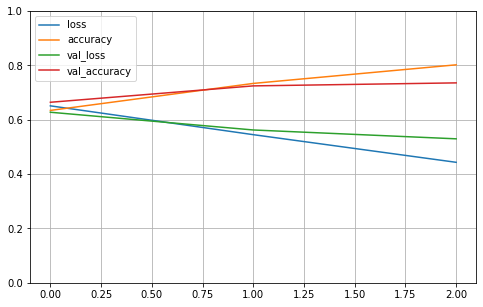

Train set ones/size 4655 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 503 / 813
Range of scores: 0.0037747533 to 0.99142694
Score threshold 0.5
Prediction set ones/size 410 / 813


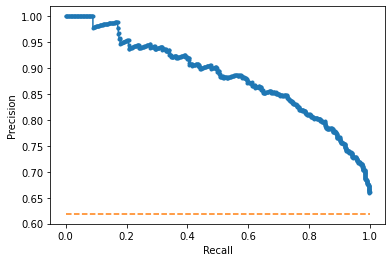

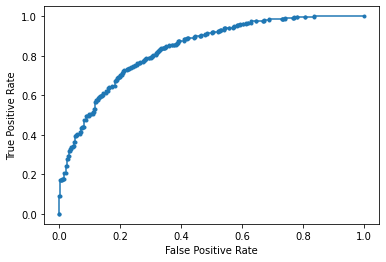

Accuracy: 73.55% Precision: 85.12% Recall: 69.38%
F1: 76.45% AUPRC: 88.36% AUROC: 83.45%
2023-02-07 15:07:22.398242
Fold 6
Bests [array([-1.11563264]), array([-1.08083813])]
RCI mean derived from training set: -0.6456534287470966
RCI threshold derived from training set: -1.0982353839879682
FIT
2023-02-07 15:07:26.753810
PREDICT
2023-02-07 15:07:35.066011


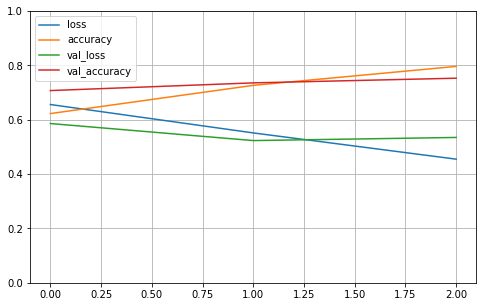

Train set ones/size 4479 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 509 / 813
Range of scores: 0.029099997 to 0.9989568
Score threshold 0.5
Prediction set ones/size 670 / 813


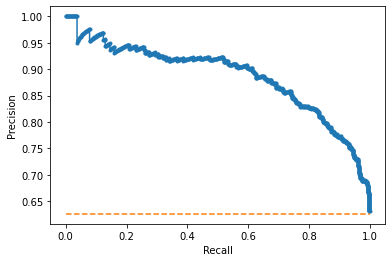

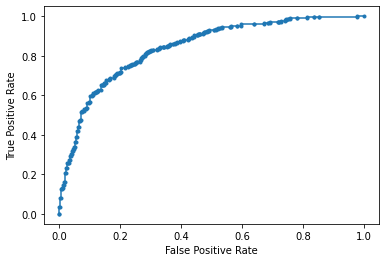

Accuracy: 75.28% Precision: 72.99% Recall: 96.07%
F1: 82.95% AUPRC: 88.65% AUROC: 84.04%
2023-02-07 15:07:35.756888
Fold 7
Bests [array([-1.18422666]), array([-1.14942381])]
RCI mean derived from training set: -0.662971660841645
RCI threshold derived from training set: -1.16682523935168
FIT
2023-02-07 15:07:39.944936
PREDICT
2023-02-07 15:07:48.210290


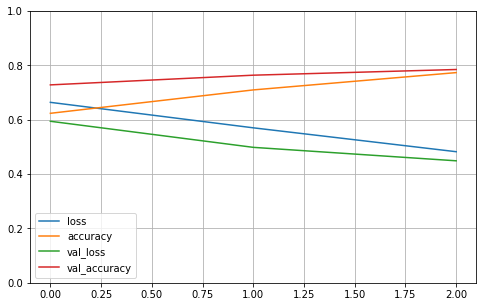

Train set ones/size 4609 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 535 / 813
Range of scores: 0.013568422 to 0.99543625
Score threshold 0.5
Prediction set ones/size 646 / 813


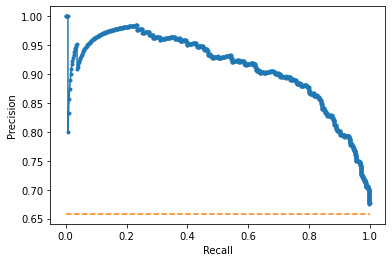

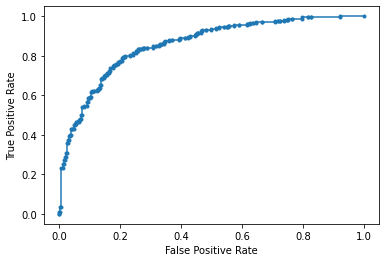

Accuracy: 78.47% Precision: 77.86% Recall: 94.02%
F1: 85.18% AUPRC: 91.08% AUROC: 85.84%
2023-02-07 15:07:48.867372
Fold 8
Bests [array([-1.21741589]), array([-1.18209039])]
RCI mean derived from training set: -0.6438629646946304
RCI threshold derived from training set: -1.199753140787669
FIT
2023-02-07 15:07:53.201434
PREDICT
2023-02-07 15:08:01.519257


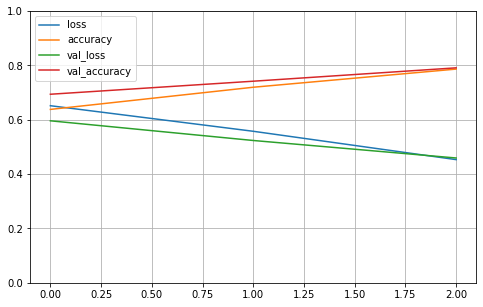

Train set ones/size 4649 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 509 / 813
Range of scores: 0.0055512856 to 0.9934616
Score threshold 0.5
Prediction set ones/size 603 / 813


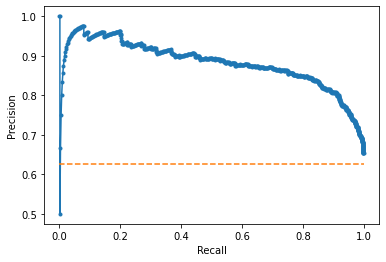

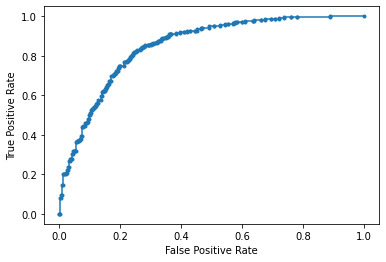

Accuracy: 79.09% Precision: 78.11% Recall: 92.53%
F1: 84.71% AUPRC: 88.20% AUROC: 84.96%
2023-02-07 15:08:02.166369
Fold 9
Bests [array([-1.14906934]), array([-1.11380093])]
RCI mean derived from training set: -0.6443524139226671
RCI threshold derived from training set: -1.1314351330432828
FIT
2023-02-07 15:08:06.473882
PREDICT
2023-02-07 15:08:14.744934


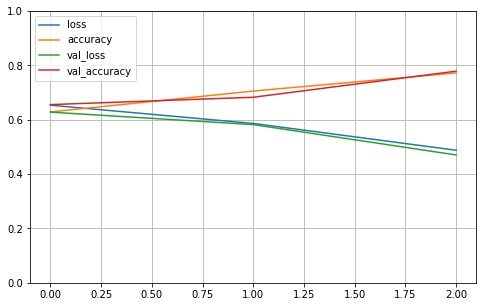

Train set ones/size 4582 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 504 / 813
Range of scores: 0.00461268 to 0.9864776
Score threshold 0.5
Prediction set ones/size 522 / 813


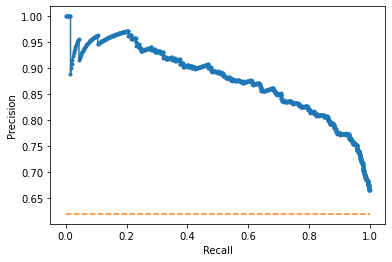

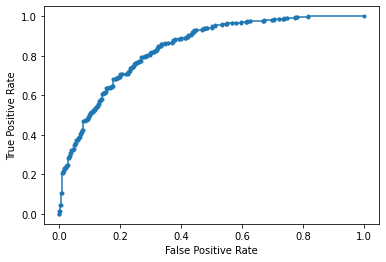

Accuracy: 77.86% Precision: 81.03% Recall: 83.93%
F1: 82.46% AUPRC: 87.95% AUROC: 83.99%
2023-02-07 15:08:15.426172
Fold 10
Bests [array([-1.30907307]), array([-1.27324964])]
RCI mean derived from training set: -0.6487705280639432
RCI threshold derived from training set: -1.291161354600024
FIT
2023-02-07 15:08:19.679360
PREDICT
2023-02-07 15:08:27.980797


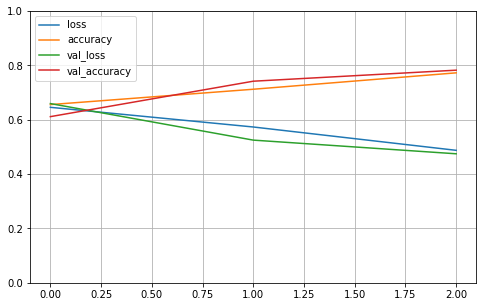

Train set ones/size 4798 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 513 / 813
Range of scores: 0.0038111052 to 0.9891121
Score threshold 0.5
Prediction set ones/size 508 / 813


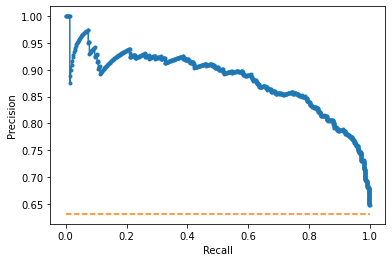

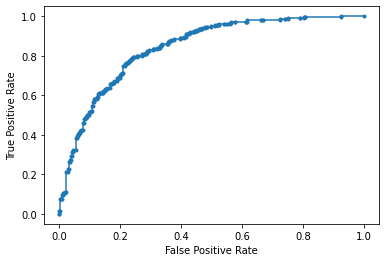

Accuracy: 78.23% Precision: 83.07% Recall: 82.26%
F1: 82.66% AUPRC: 88.09% AUROC: 84.28%
2023-02-07 15:08:28.672052

Completed cross validation 10 folds 3 epochs
 accuracy mean 77.00% +/- 1.78
 precision mean 79.74% +/- 3.83
 recall mean 85.61% +/- 8.37
 F1 mean 82.19% +/- 2.46
 AUPRC mean 88.90% +/- 1.04
 AUROC mean 84.37% +/- 1.21
Finished cell Line 8 NHEK

2023-02-07 15:08:30.075963
Start cell Line 9 SK.MEL.5
Number of RCI values loaded 534
Num RCI: 534
Load sequence...
Cross validation...
2023-02-07 15:08:39.342834
splitting
Fold 1
RCI mean derived from training set: -1.6097299827669693
RCI threshold derived from training set: -1.6097299827669693
FIT
2023-02-07 15:08:41.445035
PREDICT
2023-02-07 15:08:47.473820


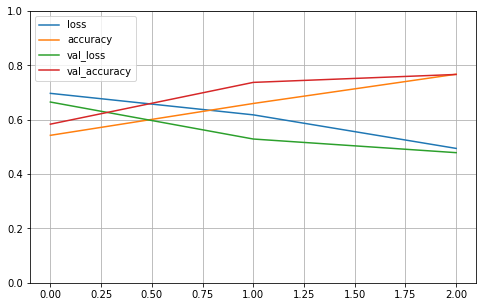

Train set ones/size 2434 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 260 / 514
Range of scores: 0.0012920253 to 0.9932173
Score threshold 0.5
Prediction set ones/size 244 / 514


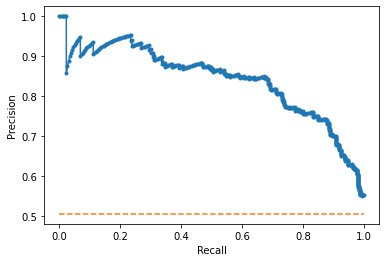

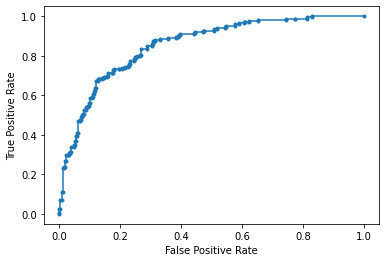

Accuracy: 76.65% Precision: 78.69% Recall: 73.85%
F1: 76.19% AUPRC: 84.18% AUROC: 85.41%
2023-02-07 15:08:48.165016
Fold 2
RCI mean derived from training set: -1.6072797641763945
RCI threshold derived from training set: -1.6072797641763945
FIT
2023-02-07 15:08:52.391564
PREDICT
2023-02-07 15:08:58.039538


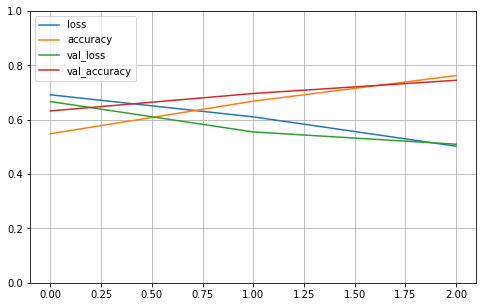

Train set ones/size 2414 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 279 / 514
Range of scores: 0.003789398 to 0.9910731
Score threshold 0.5
Prediction set ones/size 314 / 514


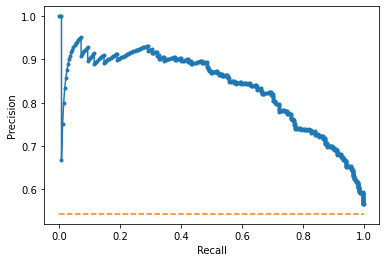

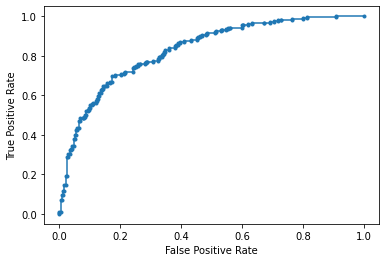

Accuracy: 74.51% Precision: 73.57% Recall: 82.80%
F1: 77.91% AUPRC: 83.57% AUROC: 82.97%
2023-02-07 15:08:58.917419
Fold 3
RCI mean derived from training set: -1.6086752521141374
RCI threshold derived from training set: -1.6086752521141374
FIT
2023-02-07 15:09:03.150173
PREDICT
2023-02-07 15:09:08.885105


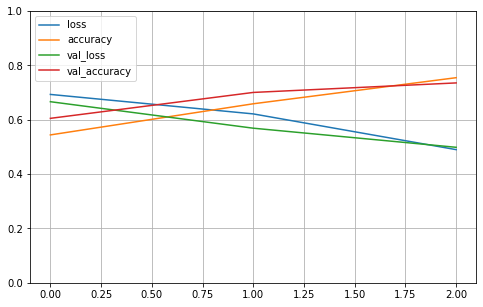

Train set ones/size 2427 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 266 / 514
Range of scores: 0.003280654 to 0.99105
Score threshold 0.5
Prediction set ones/size 258 / 514


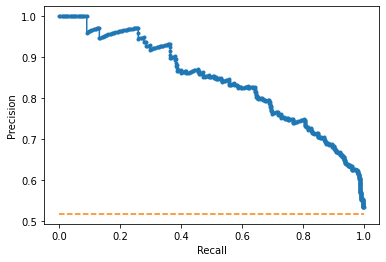

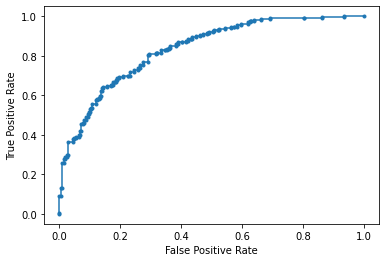

Accuracy: 73.54% Precision: 75.19% Recall: 72.93%
F1: 74.05% AUPRC: 84.29% AUROC: 83.48%
2023-02-07 15:09:09.515485
Fold 4
RCI mean derived from training set: -1.6067064599610894
RCI threshold derived from training set: -1.6067064599610894
FIT
2023-02-07 15:09:12.917848
PREDICT
2023-02-07 15:09:18.744129


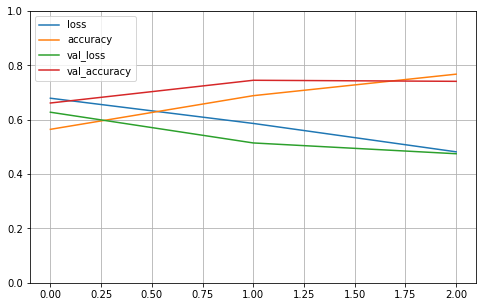

Train set ones/size 2428 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 265 / 514
Range of scores: 0.0022847827 to 0.98699373
Score threshold 0.5
Prediction set ones/size 252 / 514


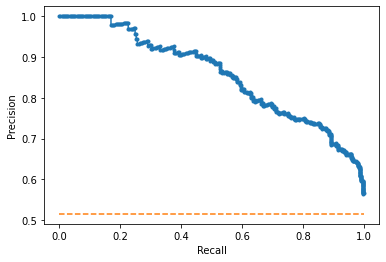

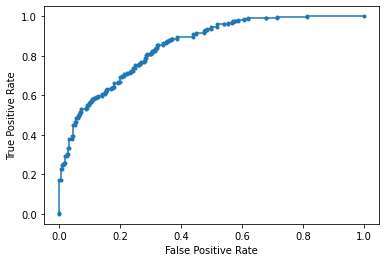

Accuracy: 74.12% Precision: 76.19% Recall: 72.45%
F1: 74.27% AUPRC: 85.75% AUROC: 85.00%
2023-02-07 15:09:19.383003
Fold 5
RCI mean derived from training set: -1.6148654526329445
RCI threshold derived from training set: -1.6148654526329445
FIT
2023-02-07 15:09:22.582955
PREDICT
2023-02-07 15:09:28.088442


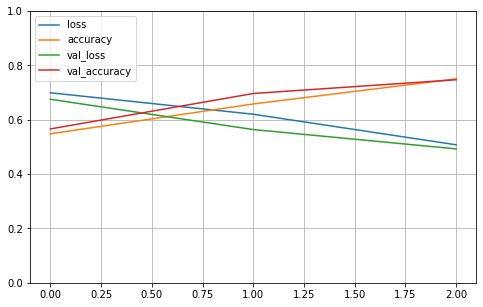

Train set ones/size 2428 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 275 / 514
Range of scores: 0.009108488 to 0.9960747
Score threshold 0.5
Prediction set ones/size 293 / 514


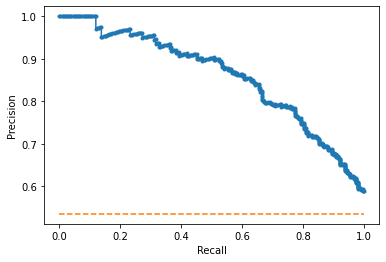

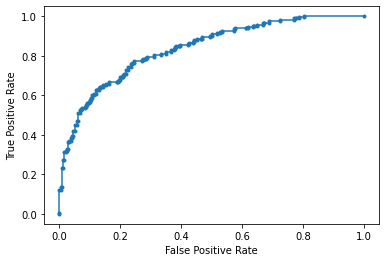

Accuracy: 74.71% Precision: 74.74% Recall: 79.64%
F1: 77.11% AUPRC: 85.95% AUROC: 83.67%
2023-02-07 15:09:28.990982
Fold 6
RCI mean derived from training set: -1.6097505674102894
RCI threshold derived from training set: -1.6097505674102894
FIT
2023-02-07 15:09:32.716538
PREDICT
2023-02-07 15:09:38.049137


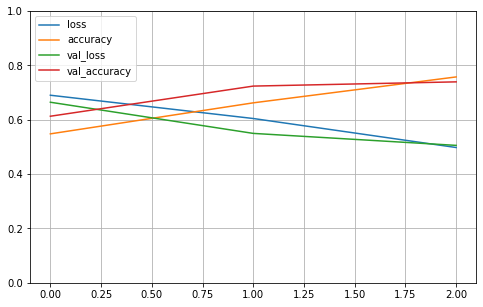

Train set ones/size 2424 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 270 / 514
Range of scores: 0.0063522495 to 0.9970805
Score threshold 0.5
Prediction set ones/size 306 / 514


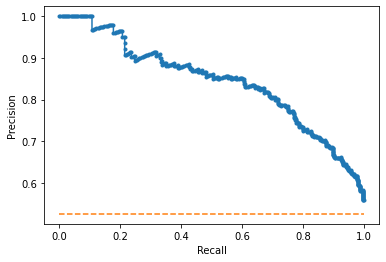

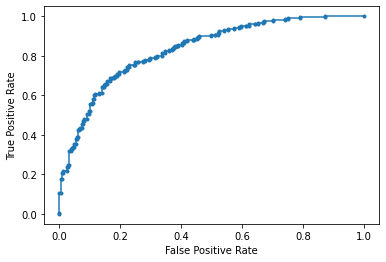

Accuracy: 73.93% Precision: 72.22% Recall: 81.85%
F1: 76.74% AUPRC: 84.37% AUROC: 83.28%
2023-02-07 15:09:38.664539
Fold 7
RCI mean derived from training set: -1.625522115170774
RCI threshold derived from training set: -1.625522115170774
FIT
2023-02-07 15:09:43.348037
PREDICT
2023-02-07 15:09:49.556306


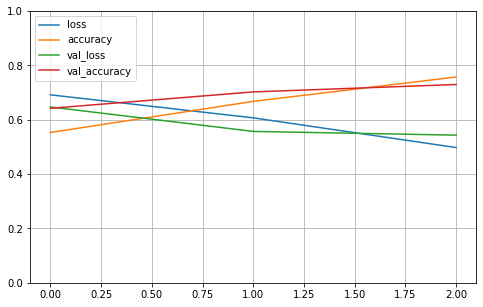

Train set ones/size 2421 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 282 / 514
Range of scores: 0.0019160943 to 0.9885959
Score threshold 0.5
Prediction set ones/size 253 / 514


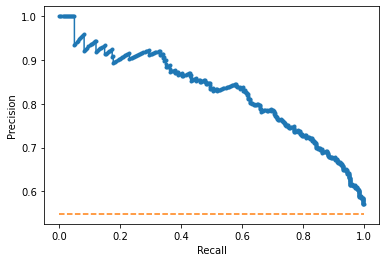

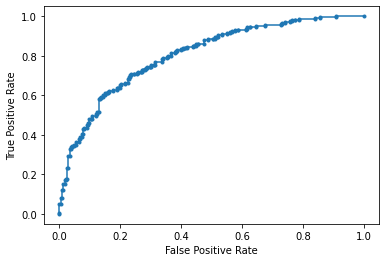

Accuracy: 72.96% Precision: 78.26% Recall: 70.21%
F1: 74.02% AUPRC: 82.79% AUROC: 80.63%
2023-02-07 15:09:50.177844
Fold 8
RCI mean derived from training set: -1.6139277325940338
RCI threshold derived from training set: -1.6139277325940338
FIT
2023-02-07 15:09:53.517580
PREDICT
2023-02-07 15:09:59.315953


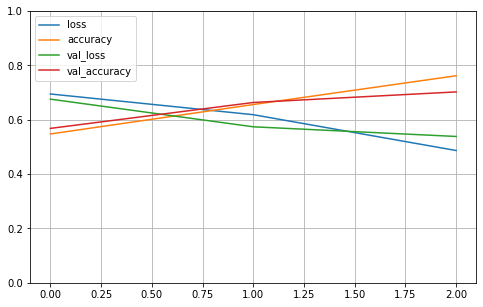

Train set ones/size 2442 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 261 / 514
Range of scores: 0.0037013153 to 0.98925775
Score threshold 0.5
Prediction set ones/size 226 / 514


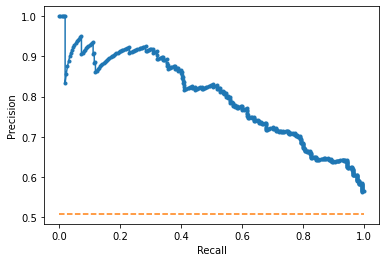

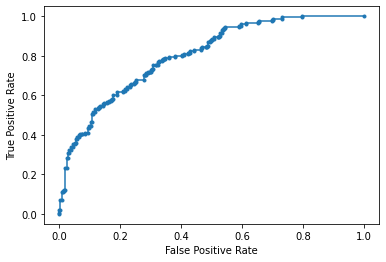

Accuracy: 70.23% Precision: 73.89% Recall: 63.98%
F1: 68.58% AUPRC: 79.76% AUROC: 80.32%
2023-02-07 15:09:59.979731
Fold 9
RCI mean derived from training set: -1.6240643330393427
RCI threshold derived from training set: -1.6240643330393427
FIT
2023-02-07 15:10:03.311857
PREDICT
2023-02-07 15:10:09.315695


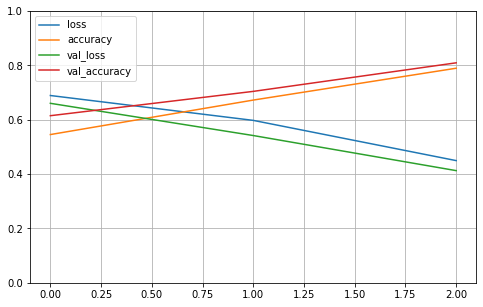

Train set ones/size 2415 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 288 / 514
Range of scores: 0.00032684402 to 0.9970824
Score threshold 0.5
Prediction set ones/size 282 / 514


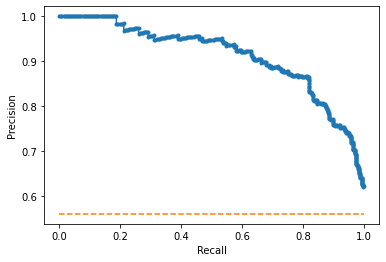

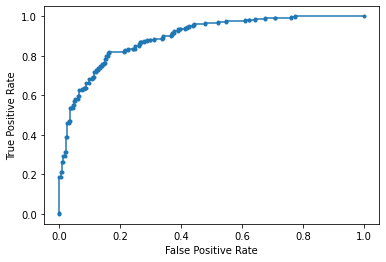

Accuracy: 80.93% Precision: 83.69% Recall: 81.94%
F1: 82.81% AUPRC: 91.22% AUROC: 89.31%
2023-02-07 15:10:10.171622
Fold 10
RCI mean derived from training set: -1.5917950430134025
RCI threshold derived from training set: -1.5917950430134025
FIT
2023-02-07 15:10:13.794294
PREDICT
2023-02-07 15:10:19.231588


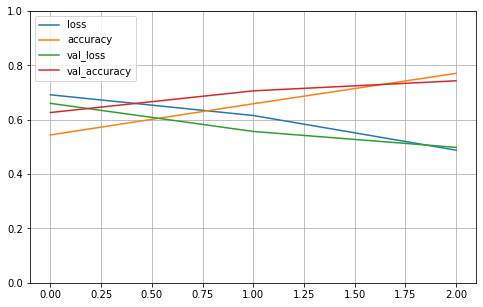

Train set ones/size 2403 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 250 / 514
Range of scores: 0.0033338857 to 0.99430746
Score threshold 0.5
Prediction set ones/size 288 / 514


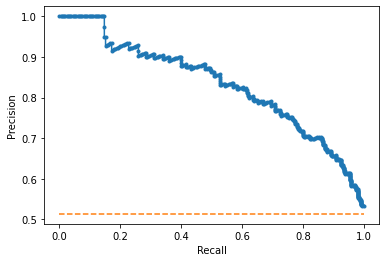

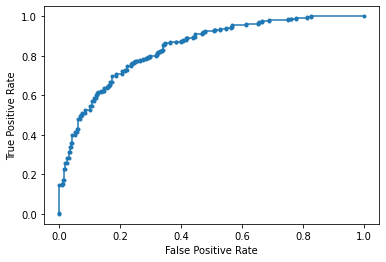

Accuracy: 74.32% Precision: 70.49% Recall: 81.20%
F1: 75.46% AUPRC: 83.34% AUROC: 84.15%
2023-02-07 15:10:19.852017

Completed cross validation 10 folds 3 epochs
 accuracy mean 74.59% +/- 2.75
 precision mean 75.69% +/- 3.77
 recall mean 76.09% +/- 6.33
 F1 mean 75.71% +/- 3.61
 AUPRC mean 84.52% +/- 2.92
 AUROC mean 83.82% +/- 2.53
Finished cell Line 9 SK.MEL.5

2023-02-07 15:10:21.185407
Start cell Line 10 SK.N.DZ
Number of RCI values loaded 603
Num RCI: 603
Load sequence...
Cross validation...
2023-02-07 15:10:30.759200
splitting
Fold 1
Bests [array([-1.96477926]), array([-1.92573942])]
RCI mean derived from training set: -0.6281296777050442
RCI threshold derived from training set: -1.9452593424532194
FIT
2023-02-07 15:10:33.143708
PREDICT
2023-02-07 15:10:44.315866


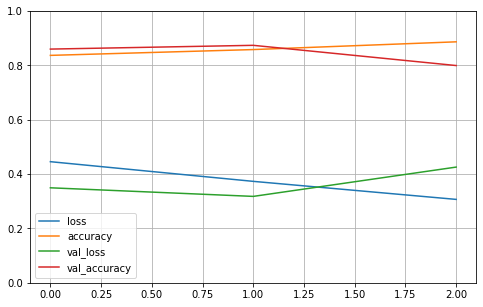

Train set ones/size 4366 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 497 / 578
Range of scores: 0.003674591 to 0.9981583
Score threshold 0.5
Prediction set ones/size 427 / 578


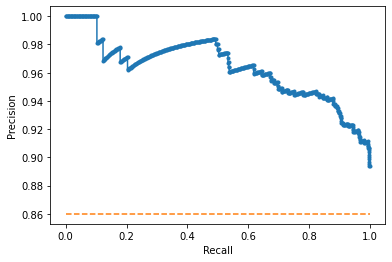

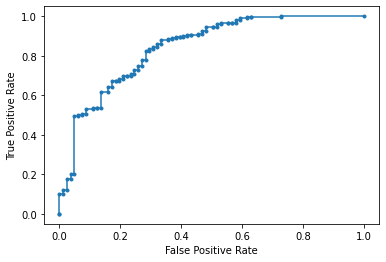

Accuracy: 79.93% Precision: 94.61% Recall: 81.29%
F1: 87.45% AUPRC: 96.34% AUROC: 84.26%
2023-02-07 15:10:44.961795
Fold 2
Bests [array([-1.96638807]), array([-1.92719085])]
RCI mean derived from training set: -0.6153963924797844
RCI threshold derived from training set: -1.9467894582104135
FIT
2023-02-07 15:10:49.229227
PREDICT
2023-02-07 15:10:55.569236


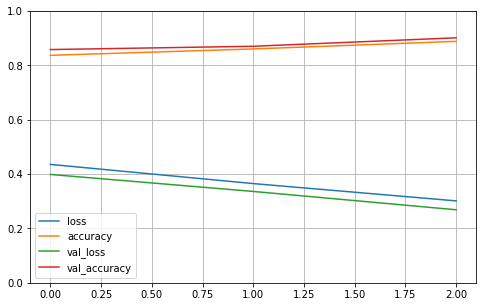

Train set ones/size 4373 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 490 / 578
Range of scores: 0.030716982 to 0.9991066
Score threshold 0.5
Prediction set ones/size 535 / 578


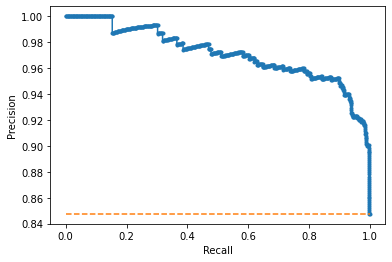

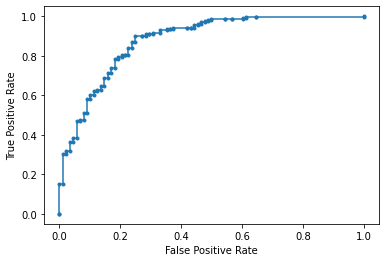

Accuracy: 90.14% Precision: 90.47% Recall: 98.78%
F1: 94.44% AUPRC: 97.14% AUROC: 88.00%
2023-02-07 15:10:56.205899
Fold 3
RCI mean derived from training set: -0.6143647613782484
RCI threshold derived from training set: -0.6143647613782484
FIT
2023-02-07 15:10:59.822734
PREDICT
2023-02-07 15:11:11.035837


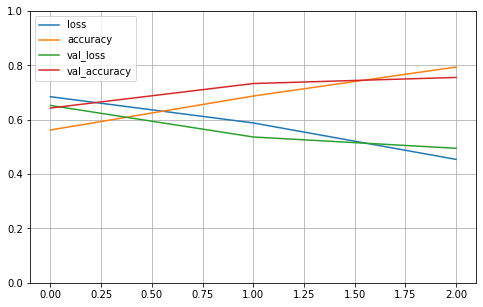

Train set ones/size 2976 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 326 / 577
Range of scores: 0.0036640305 to 0.9993185
Score threshold 0.5
Prediction set ones/size 421 / 577


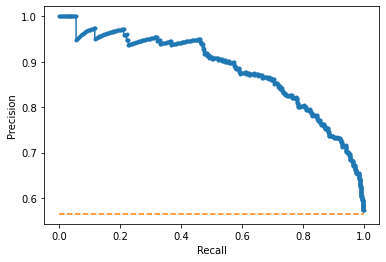

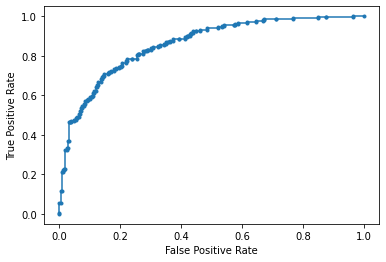

Accuracy: 75.56% Precision: 71.97% Recall: 92.94%
F1: 81.12% AUPRC: 88.32% AUROC: 85.94%
2023-02-07 15:11:11.671224
Fold 4
Bests [array([-1.96539158]), array([-1.92627051])]
RCI mean derived from training set: -0.6185031523464869
RCI threshold derived from training set: -1.9458310432827193
FIT
2023-02-07 15:11:15.553760
PREDICT
2023-02-07 15:11:21.980483


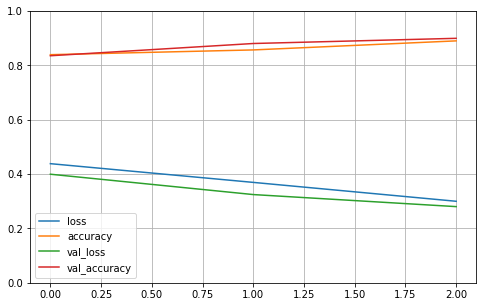

Train set ones/size 4381 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 482 / 577
Range of scores: 0.013956419 to 0.99955803
Score threshold 0.5
Prediction set ones/size 522 / 577


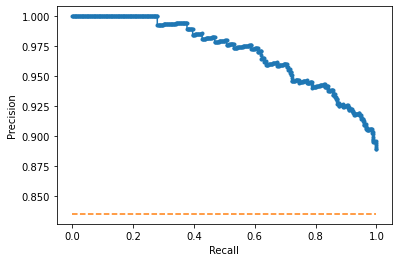

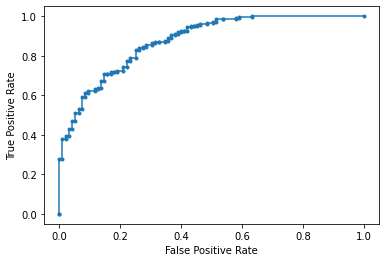

Accuracy: 89.95% Precision: 90.61% Recall: 98.13%
F1: 94.22% AUPRC: 97.07% AUROC: 87.72%
2023-02-07 15:11:22.658777
Fold 5
Bests [array([-2.01281064]), array([-1.97347912])]
RCI mean derived from training set: -0.6135521460789221
RCI threshold derived from training set: -1.9931448784856778
FIT
2023-02-07 15:11:26.438093
PREDICT
2023-02-07 15:11:32.843947


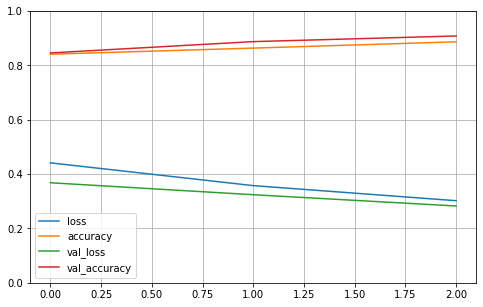

Train set ones/size 4374 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 491 / 577
Range of scores: 0.038974714 to 0.9998178
Score threshold 0.5
Prediction set ones/size 544 / 577


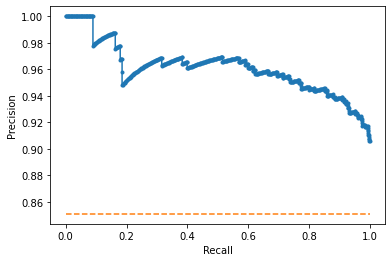

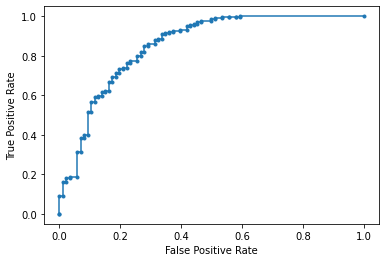

Accuracy: 90.81% Precision: 90.26% Recall: 100.00%
F1: 94.88% AUPRC: 96.11% AUROC: 85.33%
2023-02-07 15:11:33.557813
Fold 6
Bests [array([-1.91437812]), array([-1.87524201])]
RCI mean derived from training set: -0.6120151131145332
RCI threshold derived from training set: -1.894810061452673
FIT
2023-02-07 15:11:37.154932
PREDICT
2023-02-07 15:11:43.428254


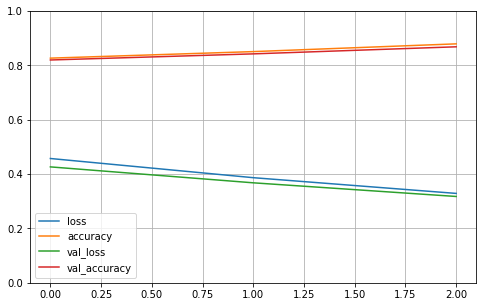

Train set ones/size 4318 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 473 / 577
Range of scores: 0.025599536 to 0.99911124
Score threshold 0.5
Prediction set ones/size 531 / 577


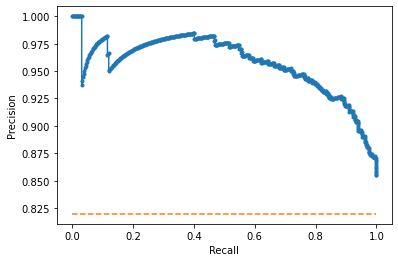

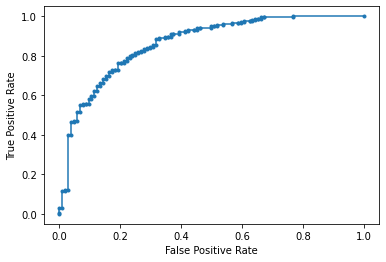

Accuracy: 86.83% Precision: 87.38% Recall: 98.10%
F1: 92.43% AUPRC: 95.71% AUROC: 86.37%
2023-02-07 15:11:44.364667
Fold 7
RCI mean derived from training set: -0.6226585323926853
RCI threshold derived from training set: -0.6226585323926853
FIT
2023-02-07 15:11:48.091066
PREDICT
2023-02-07 15:11:54.050589


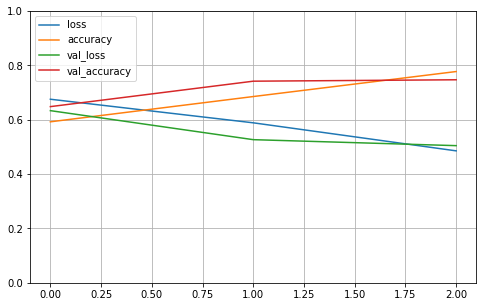

Train set ones/size 2978 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 327 / 577
Range of scores: 0.0025264204 to 0.9989115
Score threshold 0.5
Prediction set ones/size 439 / 577


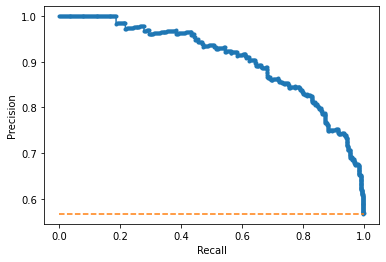

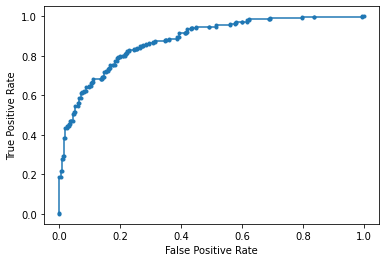

Accuracy: 74.70% Precision: 70.62% Recall: 94.80%
F1: 80.94% AUPRC: 90.58% AUROC: 87.86%
2023-02-07 15:11:54.722341
Fold 8
RCI mean derived from training set: -0.6264152809682387
RCI threshold derived from training set: -0.6264152809682387
FIT
2023-02-07 15:11:58.782019
PREDICT
2023-02-07 15:12:04.804376


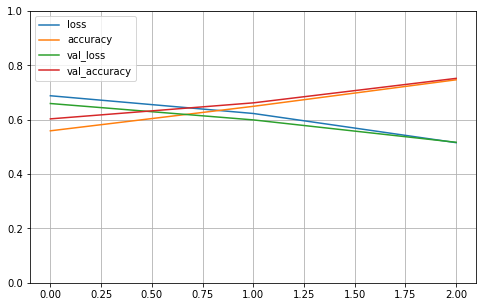

Train set ones/size 2957 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 348 / 577
Range of scores: 0.034089044 to 0.9958034
Score threshold 0.5
Prediction set ones/size 441 / 577


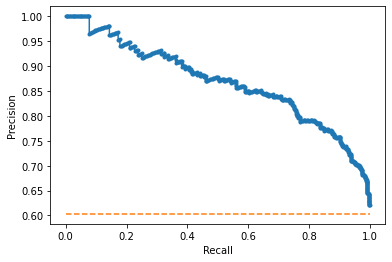

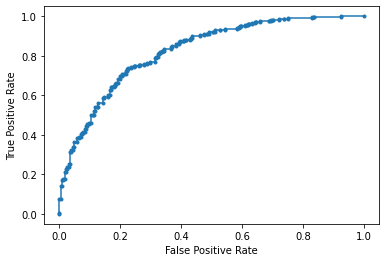

Accuracy: 75.22% Precision: 73.24% Recall: 92.82%
F1: 81.88% AUPRC: 86.85% AUROC: 82.54%
2023-02-07 15:12:05.495744
Fold 9
RCI mean derived from training set: -0.6273904246448507
RCI threshold derived from training set: -0.6273904246448507
FIT
2023-02-07 15:12:10.149565
PREDICT
2023-02-07 15:12:16.420944


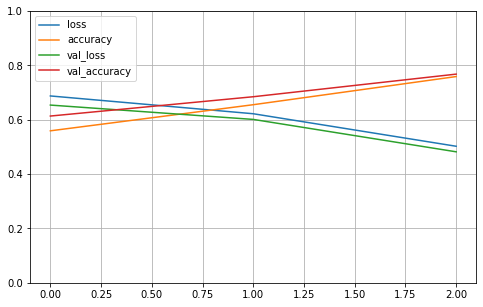

Train set ones/size 2965 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 340 / 577
Range of scores: 0.0003256186 to 0.9971674
Score threshold 0.5
Prediction set ones/size 418 / 577


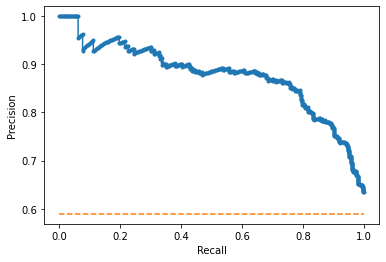

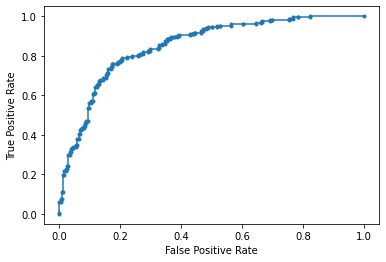

Accuracy: 76.78% Precision: 74.64% Recall: 91.76%
F1: 82.32% AUPRC: 87.73% AUROC: 85.17%
2023-02-07 15:12:17.079535
Fold 10
Bests [array([-1.91486343]), array([-1.87563191])]
RCI mean derived from training set: -0.6130283155322426
RCI threshold derived from training set: -1.8952476712748005
FIT
2023-02-07 15:12:20.865768
PREDICT
2023-02-07 15:12:32.347916


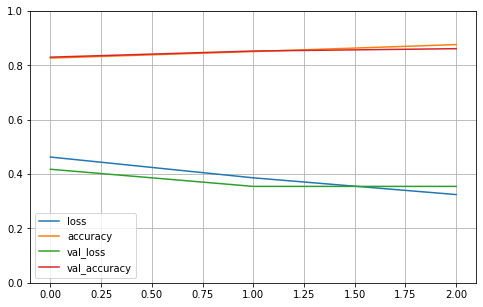

Train set ones/size 4312 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 479 / 577
Range of scores: 0.1397811 to 0.9998852
Score threshold 0.5
Prediction set ones/size 557 / 577


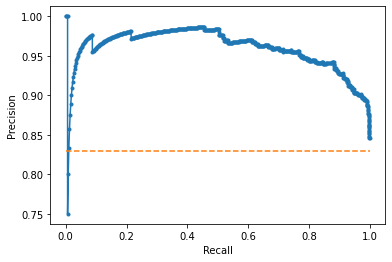

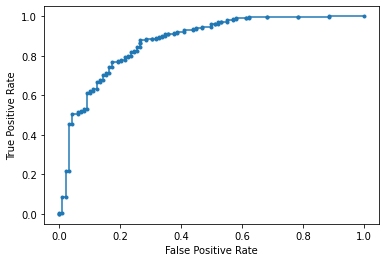

Accuracy: 86.14% Precision: 85.82% Recall: 99.79%
F1: 92.28% AUPRC: 95.91% AUROC: 87.29%
2023-02-07 15:12:33.074105

Completed cross validation 10 folds 3 epochs
 accuracy mean 82.60% +/- 6.80
 precision mean 82.96% +/- 9.24
 recall mean 94.84% +/- 5.67
 F1 mean 88.20% +/- 6.08
 AUPRC mean 93.18% +/- 4.26
 AUROC mean 86.05% +/- 1.78
Finished cell Line 10 SK.N.DZ

2023-02-07 15:12:34.423257
Start cell Line 11 SK.N.SH
Number of RCI values loaded 1647
Num RCI: 1647
Load sequence...
Cross validation...
2023-02-07 15:12:52.385539
splitting
Fold 1
Bests [array([-2.47137429]), array([-2.42239423])]
RCI mean derived from training set: -0.9625358854186823
RCI threshold derived from training set: -2.446884262020903
FIT
2023-02-07 15:12:55.750768
PREDICT
2023-02-07 15:13:07.188011


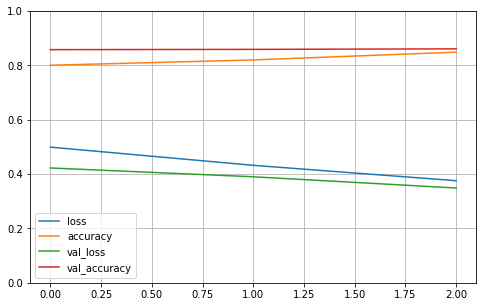

Train set ones/size 7457 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 840 / 1034
Range of scores: 0.021054609 to 0.9953435
Score threshold 0.5
Prediction set ones/size 954 / 1034


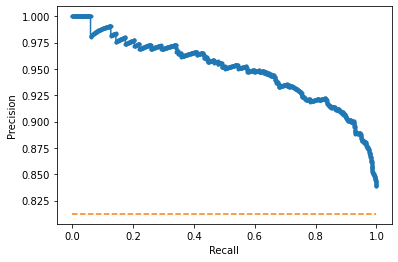

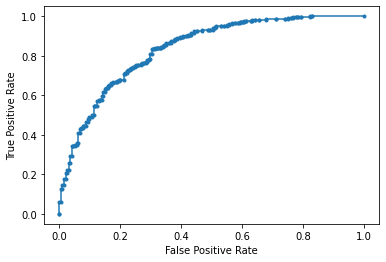

Accuracy: 86.07% Precision: 86.48% Recall: 98.21%
F1: 91.97% AUPRC: 94.90% AUROC: 83.65%
2023-02-07 15:13:07.883933
Fold 2
Bests [array([-2.44105154]), array([-2.39271572])]
RCI mean derived from training set: -0.9590621364119102
RCI threshold derived from training set: -2.4168836281261994
FIT
2023-02-07 15:13:12.767821
PREDICT
2023-02-07 15:13:23.051335


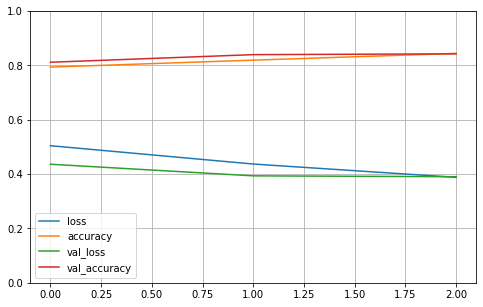

Train set ones/size 7437 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 841 / 1034
Range of scores: 0.02830409 to 0.9992078
Score threshold 0.5
Prediction set ones/size 996 / 1034


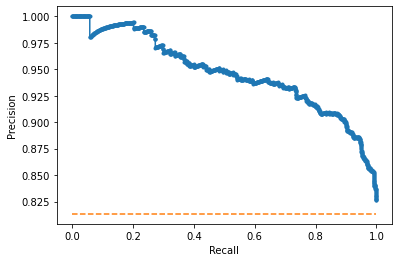

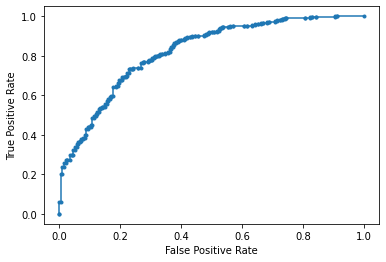

Accuracy: 84.24% Precision: 84.04% Recall: 99.52%
F1: 91.13% AUPRC: 94.65% AUROC: 82.16%
2023-02-07 15:13:23.768259
Fold 3
Bests [array([-2.3612326]), array([-2.31316334])]
RCI mean derived from training set: -0.9621559835676664
RCI threshold derived from training set: -2.3371979692290354
FIT
2023-02-07 15:13:28.876614
PREDICT
2023-02-07 15:13:39.317414


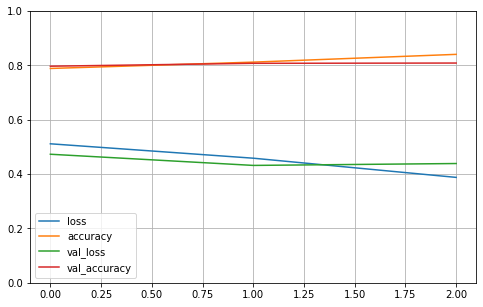

Train set ones/size 7370 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 820 / 1034
Range of scores: 0.008705362 to 0.9951207
Score threshold 0.5
Prediction set ones/size 786 / 1034


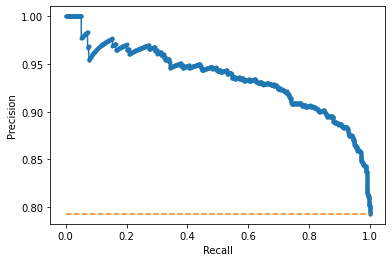

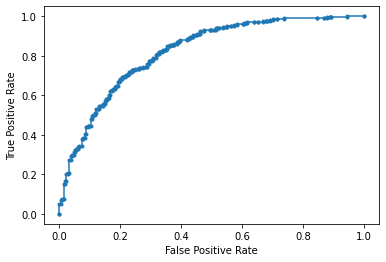

Accuracy: 80.85% Precision: 89.57% Recall: 85.85%
F1: 87.67% AUPRC: 93.59% AUROC: 82.11%
2023-02-07 15:13:40.025400
Fold 4
Bests [array([-2.3774674]), array([-2.32977841])]
RCI mean derived from training set: -0.958191079807589
RCI threshold derived from training set: -2.3536229012045764
FIT
2023-02-07 15:13:46.350374
PREDICT
2023-02-07 15:13:56.408036


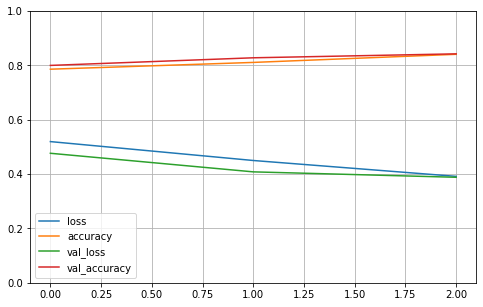

Train set ones/size 7369 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 827 / 1034
Range of scores: 0.027401686 to 0.99847955
Score threshold 0.5
Prediction set ones/size 912 / 1034


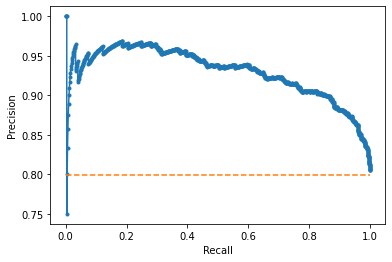

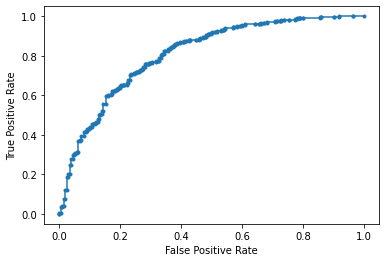

Accuracy: 84.24% Precision: 86.40% Recall: 95.28%
F1: 90.63% AUPRC: 92.96% AUROC: 81.00%
2023-02-07 15:13:57.497542
Fold 5
Bests [array([-2.33269629]), array([-2.28532214])]
RCI mean derived from training set: -0.9628417059926905
RCI threshold derived from training set: -2.309009217853779
FIT
2023-02-07 15:14:02.543631
PREDICT
2023-02-07 15:14:12.791055


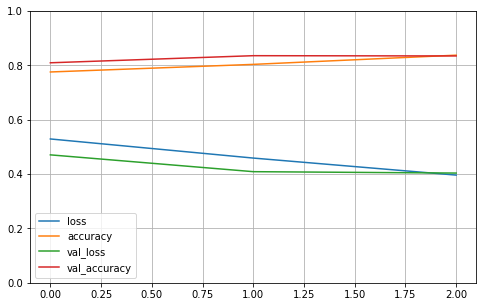

Train set ones/size 7250 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 825 / 1034
Range of scores: 0.06526173 to 0.99897003
Score threshold 0.5
Prediction set ones/size 964 / 1034


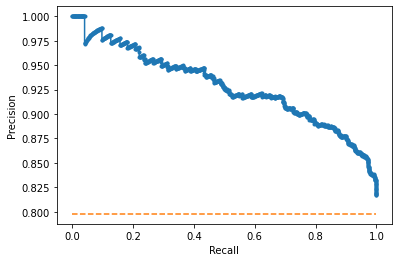

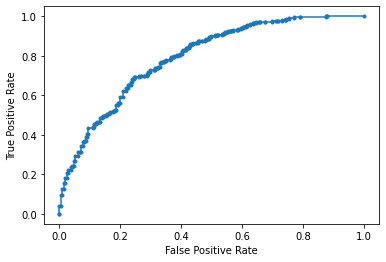

Accuracy: 83.46% Precision: 83.92% Recall: 98.06%
F1: 90.44% AUPRC: 92.86% AUROC: 79.24%
2023-02-07 15:14:13.517176
Fold 6
Bests [array([-2.5091312]), array([-2.46029064])]
RCI mean derived from training set: -0.9595112937514781
RCI threshold derived from training set: -2.4847109190758343
FIT
2023-02-07 15:14:18.371461
PREDICT
2023-02-07 15:14:28.722119


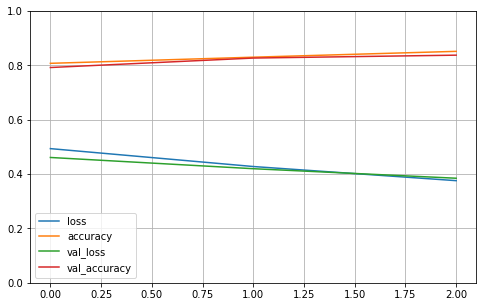

Train set ones/size 7540 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 821 / 1034
Range of scores: 0.0014773582 to 0.99938333
Score threshold 0.5
Prediction set ones/size 935 / 1034


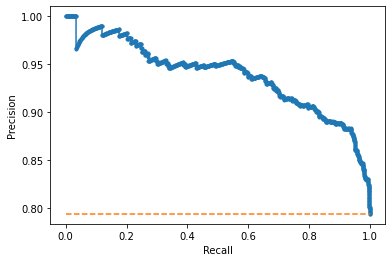

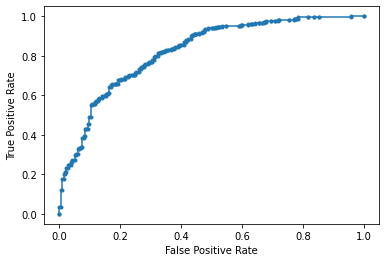

Accuracy: 83.75% Precision: 84.92% Recall: 96.71%
F1: 90.43% AUPRC: 93.84% AUROC: 82.28%
2023-02-07 15:14:29.431522
Fold 7
Bests [array([-2.55136806]), array([-2.50240429])]
RCI mean derived from training set: -0.9601035896538751
RCI threshold derived from training set: -2.526886172314664
FIT
2023-02-07 15:14:36.533002
PREDICT
2023-02-07 15:14:48.375288


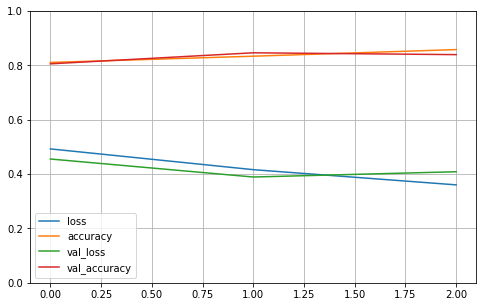

Train set ones/size 7578 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 832 / 1034
Range of scores: 0.033501767 to 0.9990872
Score threshold 0.5
Prediction set ones/size 980 / 1034


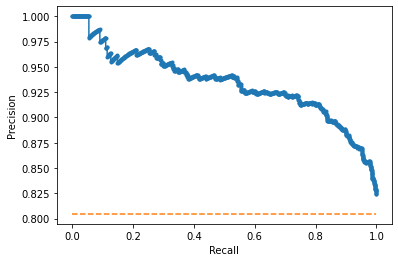

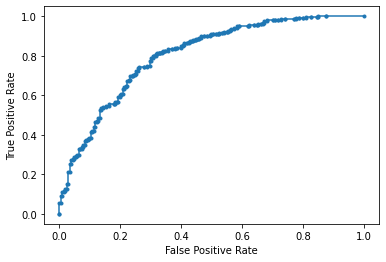

Accuracy: 83.95% Precision: 83.98% Recall: 98.92%
F1: 90.84% AUPRC: 93.39% AUROC: 80.44%
2023-02-07 15:14:49.401438
Fold 8
Bests [array([-2.51848843]), array([-2.46948181])]
RCI mean derived from training set: -0.9442116707889081
RCI threshold derived from training set: -2.493985123310438
FIT
2023-02-07 15:14:54.812306
PREDICT
2023-02-07 15:15:05.028252


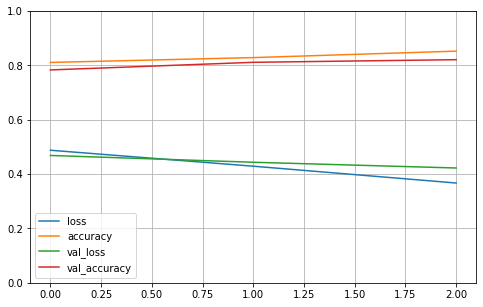

Train set ones/size 7568 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 806 / 1033
Range of scores: 0.021793691 to 0.9965959
Score threshold 0.5
Prediction set ones/size 849 / 1033


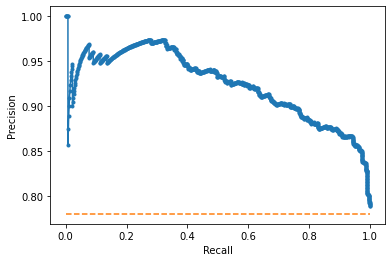

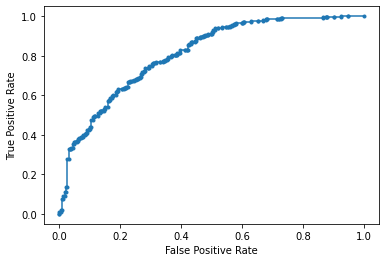

Accuracy: 82.09% Precision: 86.57% Recall: 91.19%
F1: 88.82% AUPRC: 92.40% AUROC: 80.85%
2023-02-07 15:15:05.784813
Fold 9
Bests [array([-2.52496787]), array([-2.47589842])]
RCI mean derived from training set: -0.9603716917605332
RCI threshold derived from training set: -2.500433145058353
FIT
2023-02-07 15:15:10.761216
PREDICT
2023-02-07 15:15:22.214901


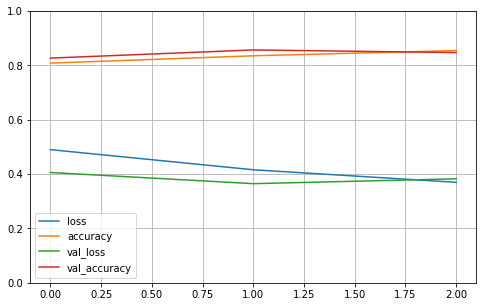

Train set ones/size 7552 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 848 / 1033
Range of scores: 0.025707353 to 0.99250495
Score threshold 0.5
Prediction set ones/size 866 / 1033


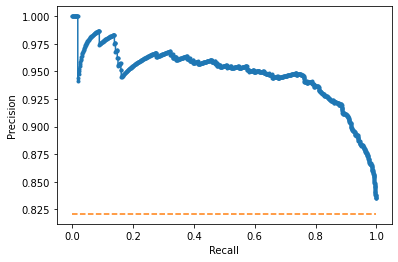

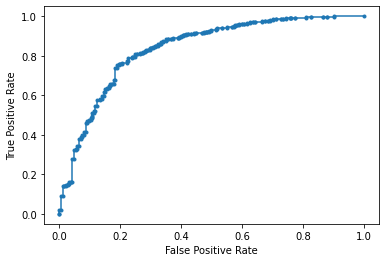

Accuracy: 84.70% Precision: 89.84% Recall: 91.75%
F1: 90.78% AUPRC: 94.79% AUROC: 83.71%
2023-02-07 15:15:22.930854
Fold 10
Bests [array([-2.44636808]), array([-2.39809559])]
RCI mean derived from training set: -0.9432120966089854
RCI threshold derived from training set: -2.4222318321674274
FIT
2023-02-07 15:15:27.640184
PREDICT
2023-02-07 15:15:39.336917


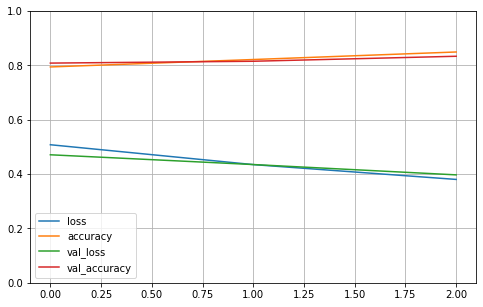

Train set ones/size 7452 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 827 / 1033
Range of scores: 0.051220704 to 0.998852
Score threshold 0.5
Prediction set ones/size 981 / 1033


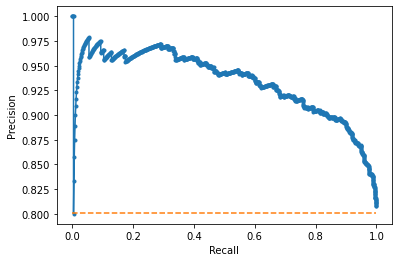

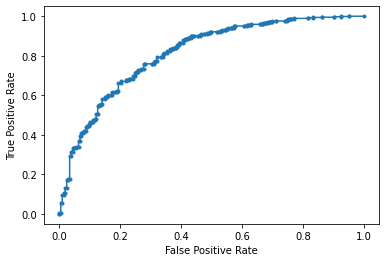

Accuracy: 83.35% Precision: 83.38% Recall: 98.91%
F1: 90.49% AUPRC: 93.37% AUROC: 81.40%
2023-02-07 15:15:40.048232

Completed cross validation 10 folds 3 epochs
 accuracy mean 83.67% +/- 1.42
 precision mean 85.91% +/- 2.32
 recall mean 95.44% +/- 4.48
 F1 mean 90.32% +/- 1.21
 AUPRC mean 93.67% +/- 0.86
 AUROC mean 81.68% +/- 1.39
Finished cell Line 11 SK.N.SH

2023-02-07 15:15:41.522123
Start cell Line 12 GM12878
Number of RCI values loaded 1698
Num RCI: 1698
Load sequence...
Cross validation...
2023-02-07 15:15:58.584496
splitting
Fold 1
Bests [array([-1.34439148]), array([-1.30587578])]
RCI mean derived from training set: -0.7917608026152975
RCI threshold derived from training set: -1.3251336272430858
FIT
2023-02-07 15:16:02.340702
PREDICT
2023-02-07 15:16:13.747717


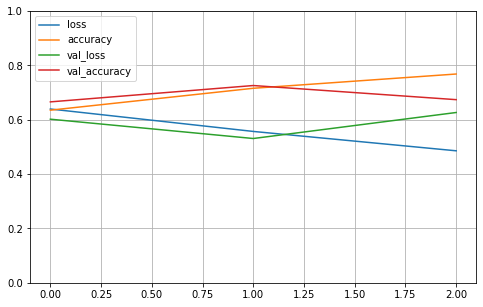

Train set ones/size 5616 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 638 / 981
Range of scores: 0.0009137919 to 0.9895936
Score threshold 0.5
Prediction set ones/size 400 / 981


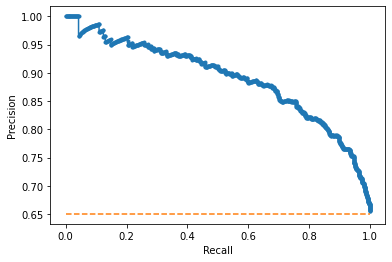

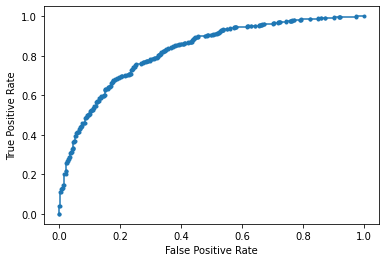

Accuracy: 67.38% Precision: 89.75% Recall: 56.27%
F1: 69.17% AUPRC: 89.04% AUROC: 82.53%
2023-02-07 15:16:14.642204
Fold 2
Bests [array([-1.17424679]), array([-1.13789125])]
RCI mean derived from training set: -0.7848096078186968
RCI threshold derived from training set: -1.1560690228681345
FIT
2023-02-07 15:16:19.495054
PREDICT
2023-02-07 15:16:29.400150


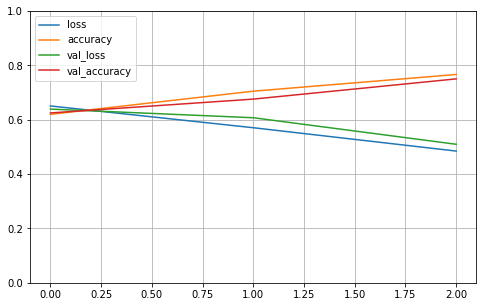

Train set ones/size 5340 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 593 / 981
Range of scores: 0.00795372 to 0.997486
Score threshold 0.5
Prediction set ones/size 720 / 981


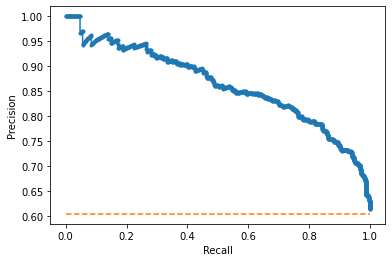

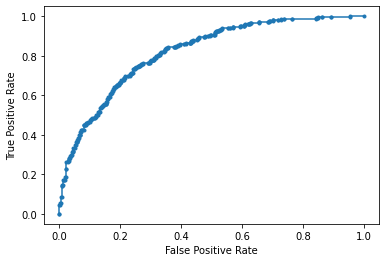

Accuracy: 75.03% Precision: 74.17% Recall: 90.05%
F1: 81.34% AUPRC: 86.32% AUROC: 81.98%
2023-02-07 15:16:30.153886
Fold 3
Bests [array([-1.38222242]), array([-1.34320889])]
RCI mean derived from training set: -0.7932426588759207
RCI threshold derived from training set: -1.3627156524674002
FIT
2023-02-07 15:16:34.832760
PREDICT
2023-02-07 15:16:46.534887


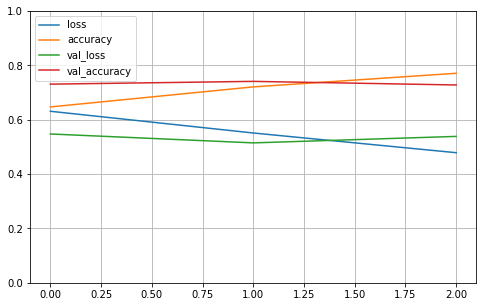

Train set ones/size 5719 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 662 / 981
Range of scores: 0.00798931 to 0.99251044
Score threshold 0.5
Prediction set ones/size 499 / 981


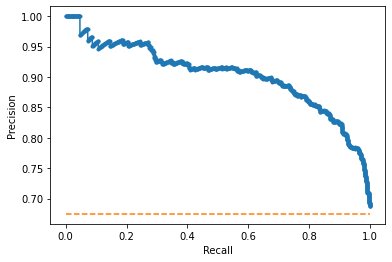

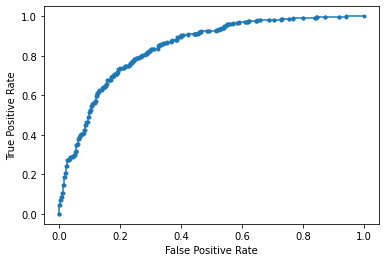

Accuracy: 72.78% Precision: 89.58% Recall: 67.52%
F1: 77.00% AUPRC: 90.35% AUROC: 84.18%
2023-02-07 15:16:47.436676
Fold 4
Bests [array([-1.3652528]), array([-1.32636402])]
RCI mean derived from training set: -0.7787853194719547
RCI threshold derived from training set: -1.3458084097880574
FIT
2023-02-07 15:16:53.461334
PREDICT
2023-02-07 15:17:04.867421


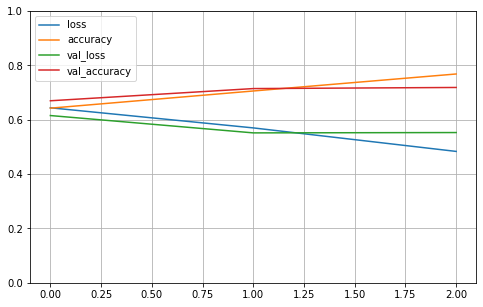

Train set ones/size 5659 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 611 / 981
Range of scores: 0.010810746 to 0.99395627
Score threshold 0.5
Prediction set ones/size 485 / 981


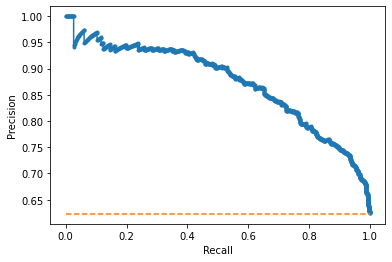

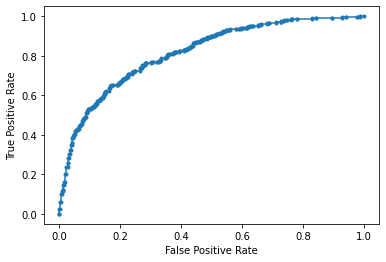

Accuracy: 71.87% Precision: 84.54% Recall: 67.10%
F1: 74.82% AUPRC: 87.36% AUROC: 81.76%
2023-02-07 15:17:05.636886
Fold 5
Bests [array([-1.22075874]), array([-1.18404536])]
RCI mean derived from training set: -0.7845497024022663
RCI threshold derived from training set: -1.2024020501883026
FIT
2023-02-07 15:17:10.744188
PREDICT
2023-02-07 15:17:20.646896


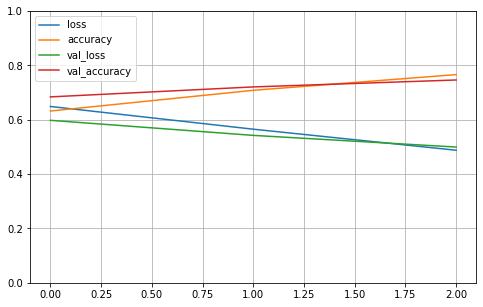

Train set ones/size 5440 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 595 / 981
Range of scores: 0.022561813 to 0.99907565
Score threshold 0.5
Prediction set ones/size 680 / 981


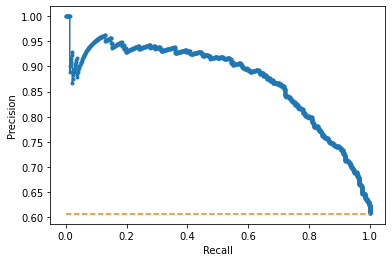

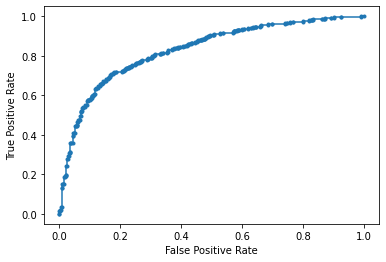

Accuracy: 74.62% Precision: 75.44% Recall: 86.22%
F1: 80.47% AUPRC: 87.40% AUROC: 83.06%
2023-02-07 15:17:21.388613
Fold 6
Bests [array([-1.33454287]), array([-1.29591823])]
RCI mean derived from training set: -0.791977157883286
RCI threshold derived from training set: -1.3152305483102078
FIT
2023-02-07 15:17:26.442517
PREDICT
2023-02-07 15:17:36.198847


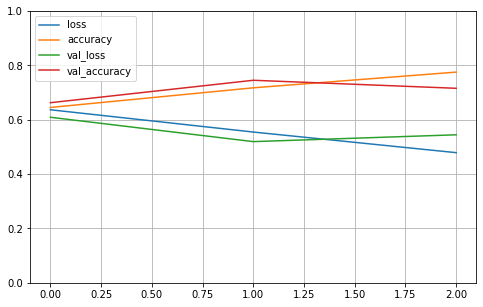

Train set ones/size 5590 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 632 / 981
Range of scores: 0.0067930003 to 0.99433494
Score threshold 0.5
Prediction set ones/size 487 / 981


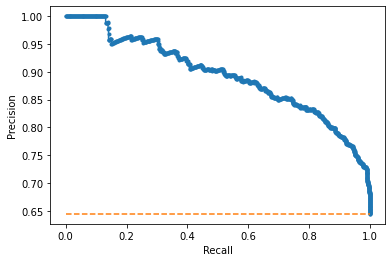

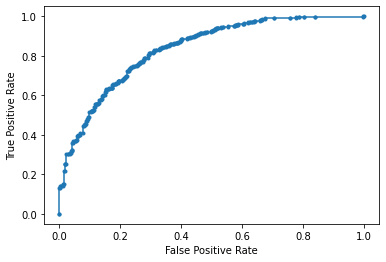

Accuracy: 71.56% Precision: 86.24% Recall: 66.46%
F1: 75.07% AUPRC: 89.39% AUROC: 83.53%
2023-02-07 15:17:36.939236
Fold 7
Bests [array([-1.41432604]), array([-1.37500398])]
RCI mean derived from training set: -0.7820942513777476
RCI threshold derived from training set: -1.394665009126642
FIT
2023-02-07 15:17:42.859336
PREDICT
2023-02-07 15:17:54.582710


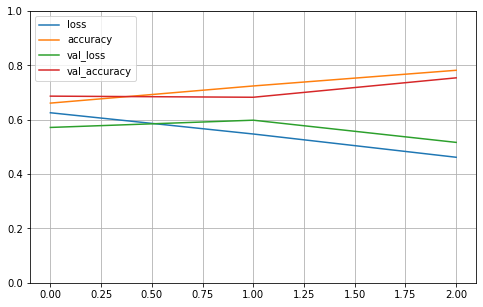

Train set ones/size 5799 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 626 / 980
Range of scores: 0.014113786 to 0.9990638
Score threshold 0.5
Prediction set ones/size 765 / 980


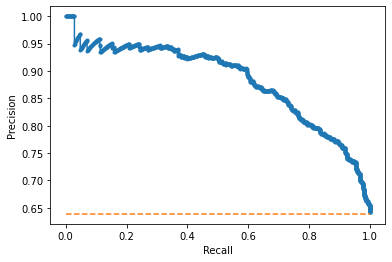

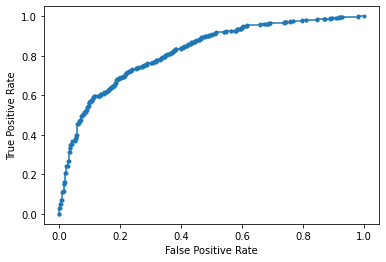

Accuracy: 75.41% Precision: 75.16% Recall: 91.85%
F1: 82.67% AUPRC: 88.26% AUROC: 82.19%
2023-02-07 15:17:55.708070
Fold 8
Bests [array([-1.19747767]), array([-1.1610913])]
RCI mean derived from training set: -0.7733633923476094
RCI threshold derived from training set: -1.179284486604978
FIT
2023-02-07 15:18:00.572872
PREDICT
2023-02-07 15:18:10.436366


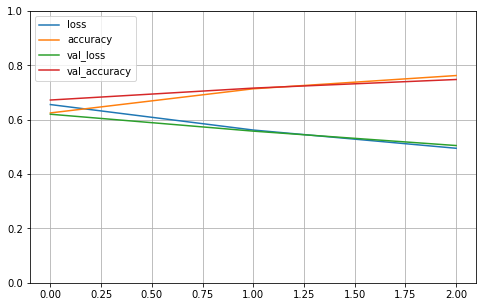

Train set ones/size 5447 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 574 / 980
Range of scores: 0.015167523 to 0.9919652
Score threshold 0.5
Prediction set ones/size 581 / 980


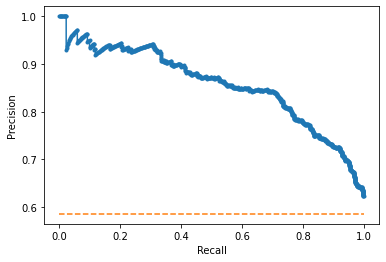

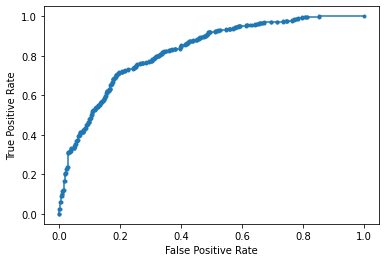

Accuracy: 74.80% Precision: 78.14% Recall: 79.09%
F1: 78.61% AUPRC: 85.71% AUROC: 82.45%
2023-02-07 15:18:11.159846
Fold 9
Bests [array([-1.33350228]), array([-1.29517999])]
RCI mean derived from training set: -0.7889935849399501
RCI threshold derived from training set: -1.3143411330280141
FIT
2023-02-07 15:18:16.011694
PREDICT
2023-02-07 15:18:27.419086


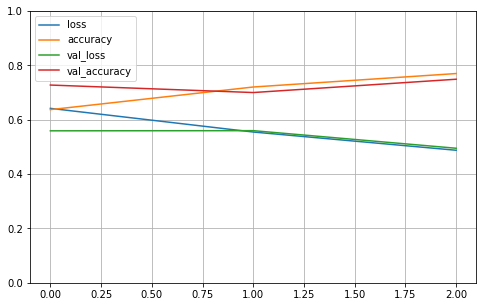

Train set ones/size 5585 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 637 / 980
Range of scores: 0.028229097 to 0.9972549
Score threshold 0.5
Prediction set ones/size 807 / 980


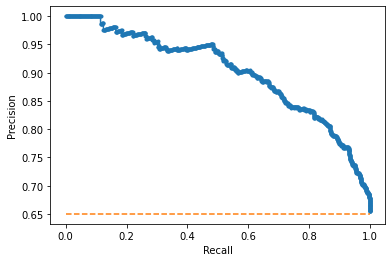

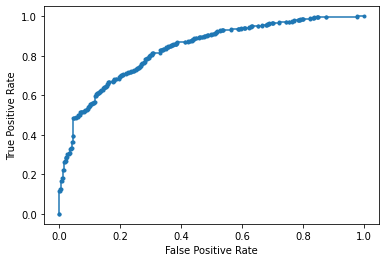

Accuracy: 74.90% Precision: 74.23% Recall: 94.03%
F1: 82.96% AUPRC: 90.14% AUROC: 83.42%
2023-02-07 15:18:28.187845
Fold 10
Bests [array([-1.32255354]), array([-1.28447867])]
RCI mean derived from training set: -0.7912181729707681
RCI threshold derived from training set: -1.3035161043561252
FIT
2023-02-07 15:18:33.116190
PREDICT
2023-02-07 15:18:44.804986


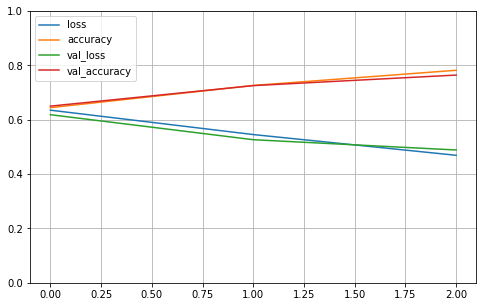

Train set ones/size 5554 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 611 / 980
Range of scores: 0.021051483 to 0.9969728
Score threshold 0.5
Prediction set ones/size 738 / 980


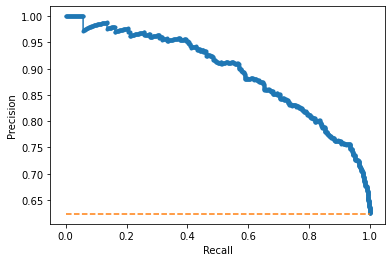

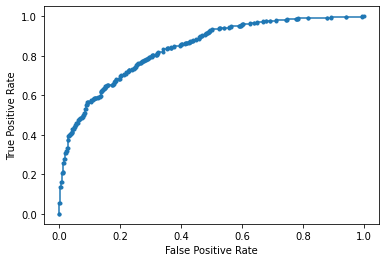

Accuracy: 76.43% Precision: 75.75% Recall: 91.49%
F1: 82.88% AUPRC: 89.36% AUROC: 83.82%
2023-02-07 15:18:45.553481

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.48% +/- 2.66
 precision mean 80.30% +/- 6.49
 recall mean 79.01% +/- 13.62
 F1 mean 78.50% +/- 4.51
 AUPRC mean 88.33% +/- 1.59
 AUROC mean 82.89% +/- 0.83
Finished cell Line 12 GM12878

2023-02-07 15:18:47.008976
Start cell Line 13 K562
Number of RCI values loaded 958
Num RCI: 958
Load sequence...
Cross validation...
2023-02-07 15:18:57.471834
splitting
Fold 1
Bests [array([-1.34627576]), array([-1.3216168])]
RCI mean derived from training set: -0.6713087291342756
RCI threshold derived from training set: -1.333946280736313
FIT
2023-02-07 15:18:59.850383
PREDICT
2023-02-07 15:19:06.908743


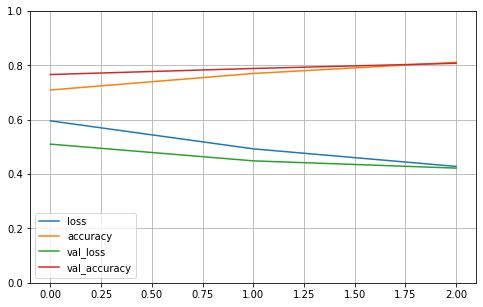

Train set ones/size 4008 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 449 / 629
Range of scores: 0.005848397 to 0.9980958
Score threshold 0.5
Prediction set ones/size 496 / 629


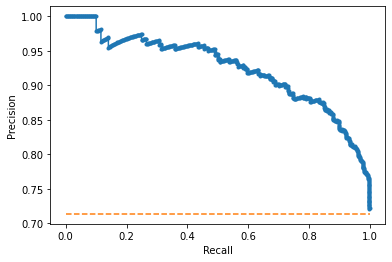

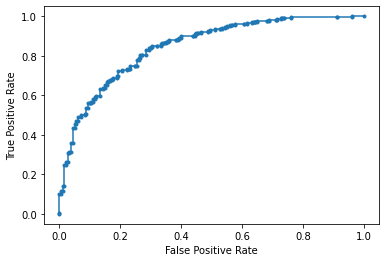

Accuracy: 80.76% Precision: 83.06% Recall: 91.76%
F1: 87.20% AUPRC: 92.48% AUROC: 84.67%
2023-02-07 15:19:07.598833
Fold 2
Bests [array([-1.32549653]), array([-1.30125873])]
RCI mean derived from training set: -0.6737843573215548
RCI threshold derived from training set: -1.3133776324204804
FIT
2023-02-07 15:19:11.236915
PREDICT
2023-02-07 15:19:18.076602


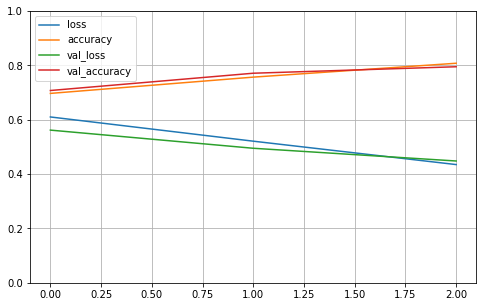

Train set ones/size 3969 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 440 / 629
Range of scores: 0.024600267 to 0.9958754
Score threshold 0.5
Prediction set ones/size 525 / 629


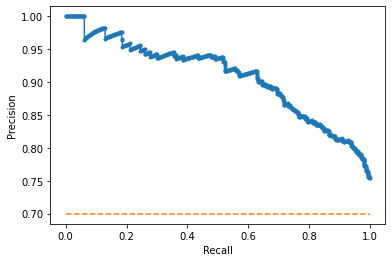

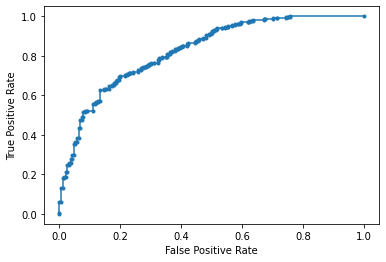

Accuracy: 79.49% Precision: 79.62% Recall: 95.00%
F1: 86.63% AUPRC: 90.87% AUROC: 82.73%
2023-02-07 15:19:18.740836
Fold 3
Bests [array([-1.38128601]), array([-1.35613708])]
RCI mean derived from training set: -0.6784838250318022
RCI threshold derived from training set: -1.368711543676881
FIT
2023-02-07 15:19:22.394209
PREDICT
2023-02-07 15:19:33.637789


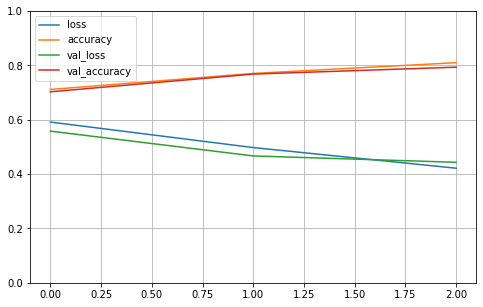

Train set ones/size 4054 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 437 / 629
Range of scores: 0.00572629 to 0.99844366
Score threshold 0.5
Prediction set ones/size 473 / 629


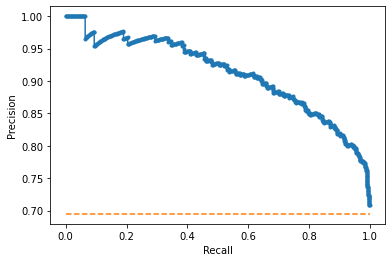

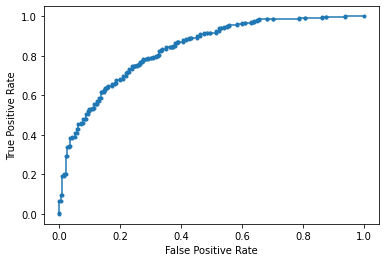

Accuracy: 79.33% Precision: 82.45% Recall: 89.24%
F1: 85.71% AUPRC: 91.26% AUROC: 83.56%
2023-02-07 15:19:34.338733
Fold 4
Bests [array([-1.32457975]), array([-1.30031036])]
RCI mean derived from training set: -0.6876066247208481
RCI threshold derived from training set: -1.3124450505373466
FIT
2023-02-07 15:19:38.093460
PREDICT
2023-02-07 15:19:49.360127


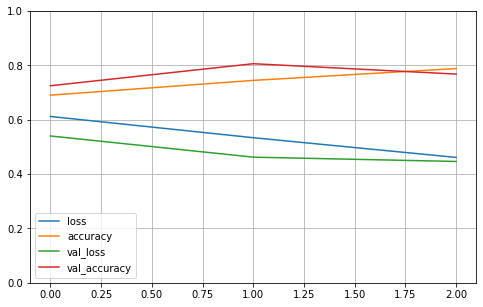

Train set ones/size 3955 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 454 / 629
Range of scores: 0.004123469 to 0.99615115
Score threshold 0.5
Prediction set ones/size 436 / 629


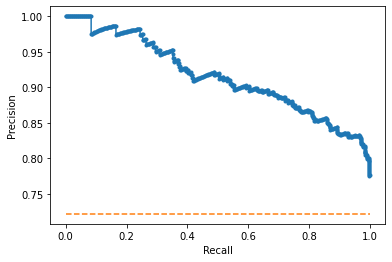

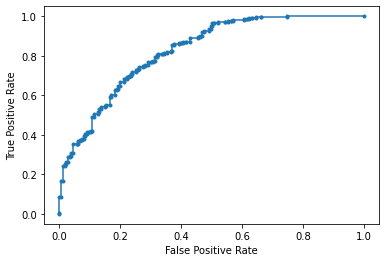

Accuracy: 76.79% Precision: 85.32% Recall: 81.94%
F1: 83.60% AUPRC: 91.55% AUROC: 82.65%
2023-02-07 15:19:50.049994
Fold 5
Bests [array([-1.32239607]), array([-1.29790978])]
RCI mean derived from training set: -0.6696898698833923
RCI threshold derived from training set: -1.3101529267282803
FIT
2023-02-07 15:19:54.042217
PREDICT
2023-02-07 15:20:05.593626


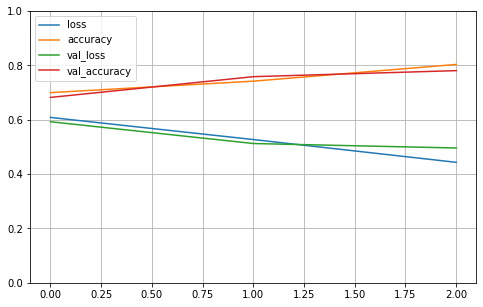

Train set ones/size 3980 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 429 / 629
Range of scores: 0.016975272 to 0.99838865
Score threshold 0.5
Prediction set ones/size 525 / 629


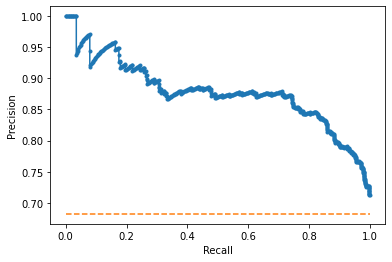

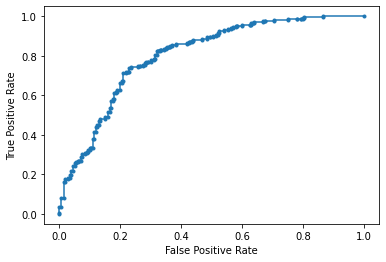

Accuracy: 78.06% Precision: 77.71% Recall: 95.10%
F1: 85.53% AUPRC: 87.77% AUROC: 80.41%
2023-02-07 15:20:06.263945
Fold 6
Bests [array([-1.32723568]), array([-1.30273054])]
RCI mean derived from training set: -0.6754036411201414
RCI threshold derived from training set: -1.314983109770337
FIT
2023-02-07 15:20:10.991525
PREDICT
2023-02-07 15:20:22.247323


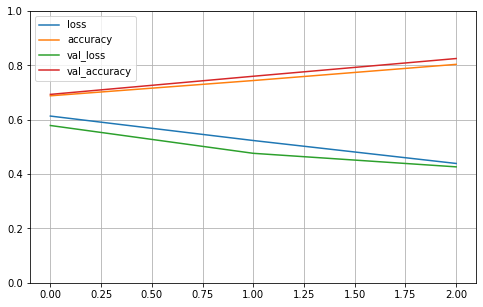

Train set ones/size 3973 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 436 / 629
Range of scores: 0.003253614 to 0.99840814
Score threshold 0.5
Prediction set ones/size 452 / 629


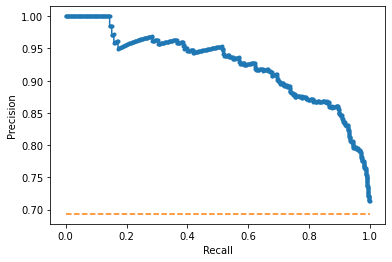

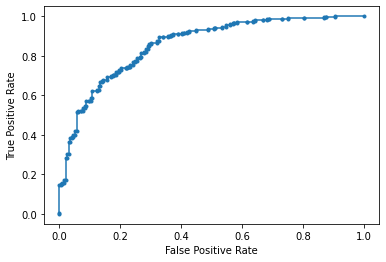

Accuracy: 82.51% Precision: 86.06% Recall: 89.22%
F1: 87.61% AUPRC: 92.44% AUROC: 85.75%
2023-02-07 15:20:22.939525
Fold 7
Bests [array([-1.30043227]), array([-1.27674977])]
RCI mean derived from training set: -0.6775167190000001
RCI threshold derived from training set: -1.2885910215243
FIT
2023-02-07 15:20:26.580965
PREDICT
2023-02-07 15:20:33.074773


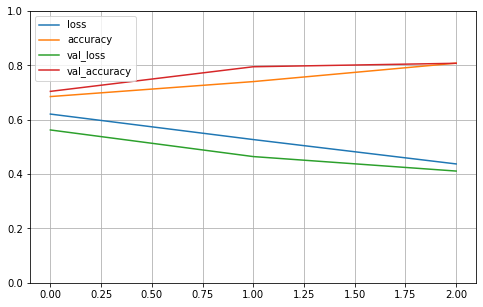

Train set ones/size 3924 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 434 / 629
Range of scores: 0.006024364 to 0.99882966
Score threshold 0.5
Prediction set ones/size 501 / 629


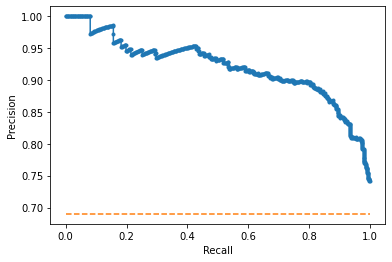

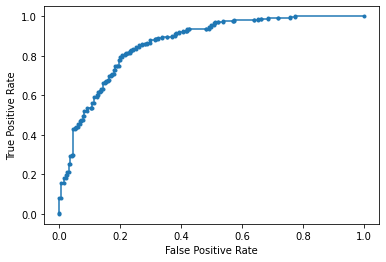

Accuracy: 80.76% Precision: 81.24% Recall: 93.78%
F1: 87.06% AUPRC: 92.08% AUROC: 86.26%
2023-02-07 15:20:33.924727
Fold 8
Bests [array([-1.33076199]), array([-1.30622139])]
RCI mean derived from training set: -0.6808395354416962
RCI threshold derived from training set: -1.3184916917538654
FIT
2023-02-07 15:20:37.627189
PREDICT
2023-02-07 15:20:48.853990


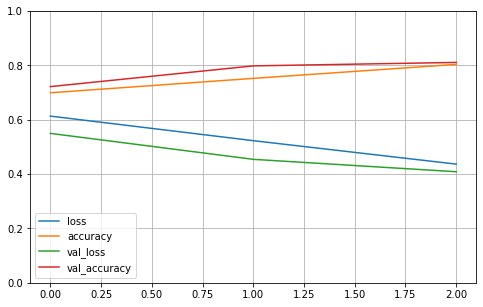

Train set ones/size 3960 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 449 / 629
Range of scores: 0.008416932 to 0.9974764
Score threshold 0.5
Prediction set ones/size 506 / 629


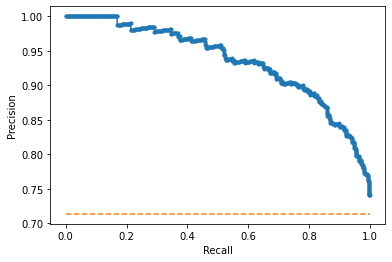

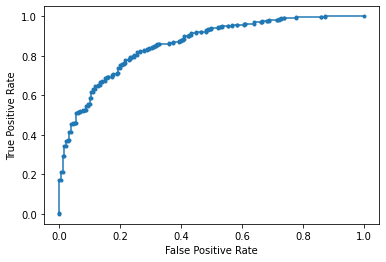

Accuracy: 81.08% Precision: 82.61% Recall: 93.10%
F1: 87.54% AUPRC: 93.54% AUROC: 85.85%
2023-02-07 15:20:49.547832
Fold 9
Bests [array([-1.33369029]), array([-1.30946598])]
RCI mean derived from training set: -0.6768322222844524
RCI threshold derived from training set: -1.321578136321211
FIT
2023-02-07 15:20:53.584290
PREDICT
2023-02-07 15:21:00.258497


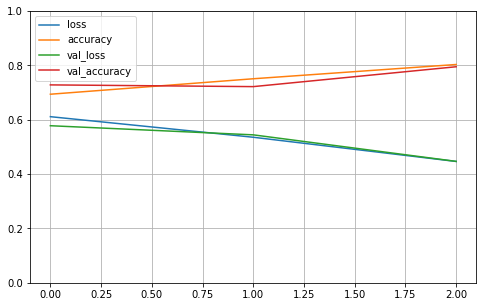

Train set ones/size 3973 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 436 / 629
Range of scores: 0.012893833 to 0.9950622
Score threshold 0.5
Prediction set ones/size 519 / 629


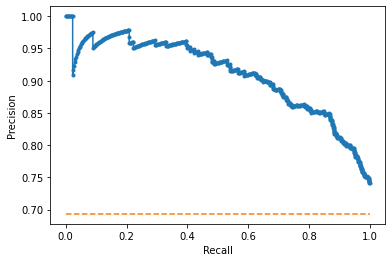

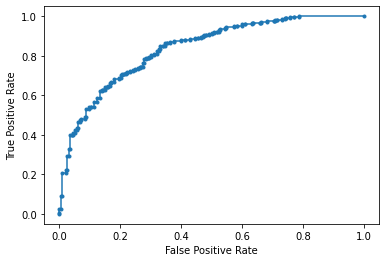

Accuracy: 79.49% Precision: 79.58% Recall: 94.72%
F1: 86.49% AUPRC: 91.02% AUROC: 83.59%
2023-02-07 15:21:00.988988
Fold 10
Bests [array([-1.35876757]), array([-1.3343402])]
RCI mean derived from training set: -0.6857367733633634
RCI threshold derived from training set: -1.346553885005457
FIT
2023-02-07 15:21:04.583048
PREDICT
2023-02-07 15:21:15.788209


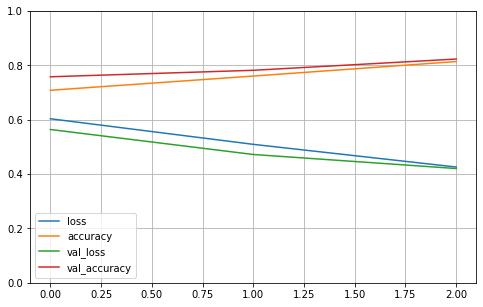

Train set ones/size 4035 / 5661
Compute valiation accuracy
Valid sizes (628, 4997) (628,)
Valid set ones/size 453 / 628
Range of scores: 0.008655802 to 0.9975943
Score threshold 0.5
Prediction set ones/size 460 / 628


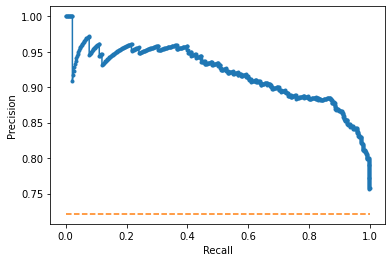

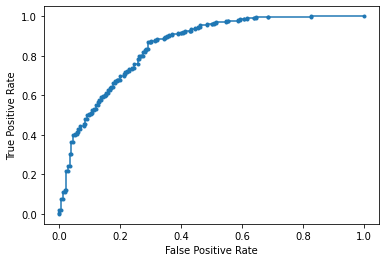

Accuracy: 82.32% Precision: 87.17% Recall: 88.52%
F1: 87.84% AUPRC: 91.91% AUROC: 84.91%
2023-02-07 15:21:16.486875

Completed cross validation 10 folds 3 epochs
 accuracy mean 80.06% +/- 1.80
 precision mean 82.48% +/- 3.06
 recall mean 91.24% +/- 4.13
 F1 mean 86.52% +/- 1.29
 AUPRC mean 91.49% +/- 1.53
 AUROC mean 84.04% +/- 1.81
Finished cell Line 13 K562

2023-02-07 15:21:17.858188
Start cell Line 14 IMR.90
Number of RCI values loaded 390
Num RCI: 390
Load sequence...
Cross validation...
2023-02-07 15:21:21.338402
splitting
Fold 1
RCI mean derived from training set: -0.7940587397297298
RCI threshold derived from training set: -0.7940587397297298
FIT
2023-02-07 15:21:22.412718
PREDICT
2023-02-07 15:21:28.609492


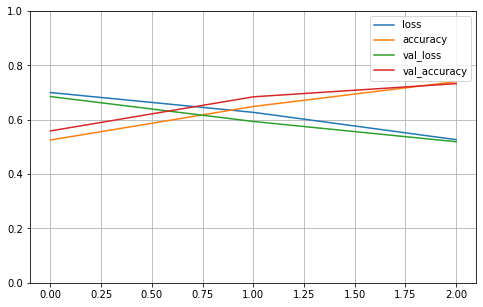

Train set ones/size 1095 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 110 / 247
Range of scores: 0.016691167 to 0.94498605
Score threshold 0.5
Prediction set ones/size 126 / 247


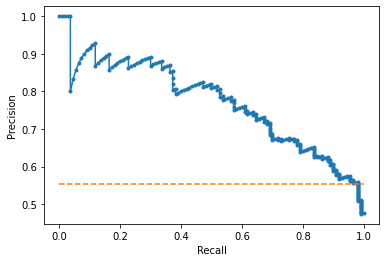

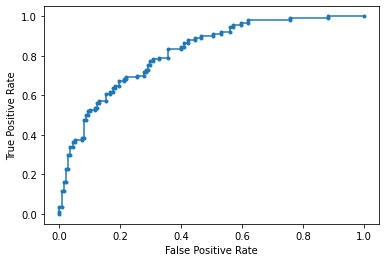

Accuracy: 73.28% Precision: 67.46% Recall: 77.27%
F1: 72.03% AUPRC: 77.17% AUROC: 81.83%
2023-02-07 15:21:29.235921
Fold 2
RCI mean derived from training set: -0.792873576036036
RCI threshold derived from training set: -0.792873576036036
FIT
2023-02-07 15:21:31.462834
PREDICT
2023-02-07 15:21:34.534207


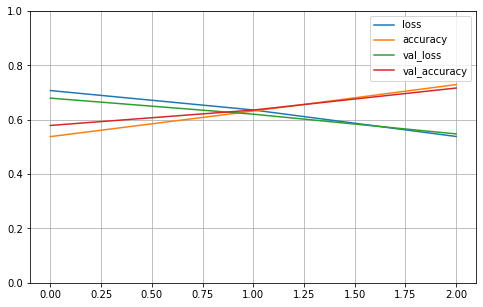

Train set ones/size 1085 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 120 / 247
Range of scores: 0.00636878 to 0.9757312
Score threshold 0.5
Prediction set ones/size 86 / 247


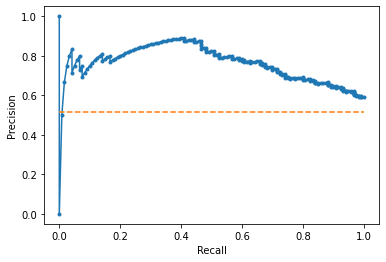

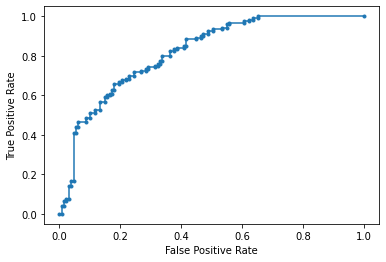

Accuracy: 71.66% Precision: 79.07% Recall: 56.67%
F1: 66.02% AUPRC: 75.88% AUROC: 81.90%
2023-02-07 15:21:35.158770
Fold 3
RCI mean derived from training set: -0.8008805327927928
RCI threshold derived from training set: -0.8008805327927928
FIT
2023-02-07 15:21:38.768491
PREDICT
2023-02-07 15:21:42.124673


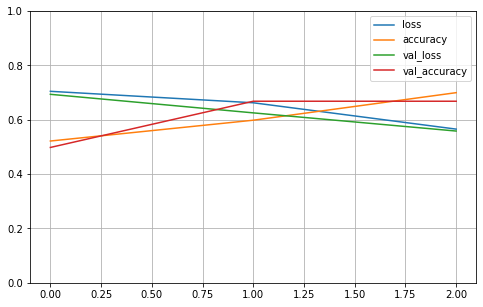

Train set ones/size 1087 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 118 / 247
Range of scores: 0.004717364 to 0.92956364
Score threshold 0.5
Prediction set ones/size 80 / 247


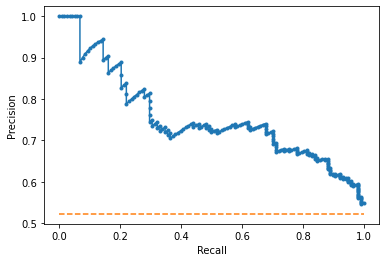

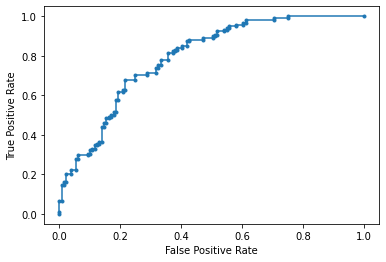

Accuracy: 66.80% Precision: 72.50% Recall: 49.15%
F1: 58.59% AUPRC: 75.37% AUROC: 79.23%
2023-02-07 15:21:42.775026
Fold 4
RCI mean derived from training set: -0.8059054895045044
RCI threshold derived from training set: -0.8059054895045044
FIT
2023-02-07 15:21:44.991545
PREDICT
2023-02-07 15:21:48.336745


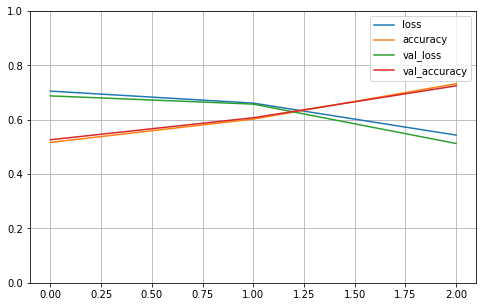

Train set ones/size 1083 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 124 / 247
Range of scores: 0.0009105231 to 0.9618094
Score threshold 0.5
Prediction set ones/size 142 / 247


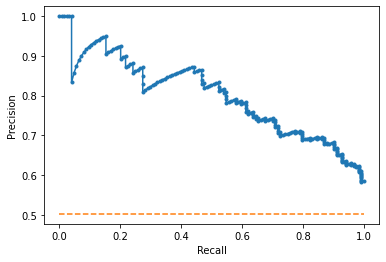

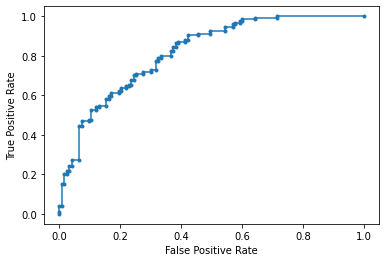

Accuracy: 72.47% Precision: 69.72% Recall: 79.84%
F1: 74.44% AUPRC: 80.04% AUROC: 81.81%
2023-02-07 15:21:49.051929
Fold 5
RCI mean derived from training set: -0.786263587027027
RCI threshold derived from training set: -0.786263587027027
FIT
2023-02-07 15:21:52.063942
PREDICT
2023-02-07 15:21:55.122856


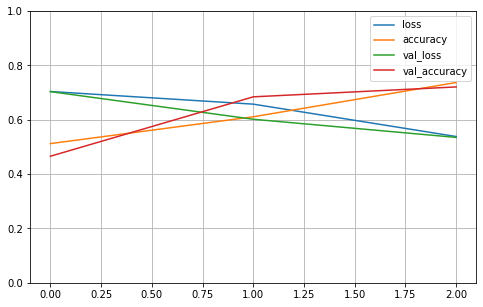

Train set ones/size 1087 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 117 / 247
Range of scores: 0.0021469502 to 0.9433585
Score threshold 0.5
Prediction set ones/size 120 / 247


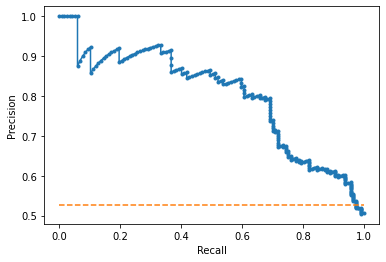

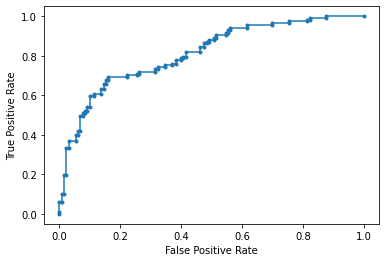

Accuracy: 72.06% Precision: 70.00% Recall: 71.79%
F1: 70.89% AUPRC: 80.03% AUROC: 81.30%
2023-02-07 15:21:55.786925
Fold 6
RCI mean derived from training set: -0.8023878546846847
RCI threshold derived from training set: -0.8023878546846847
FIT
2023-02-07 15:21:57.990739
PREDICT
2023-02-07 15:22:01.321951


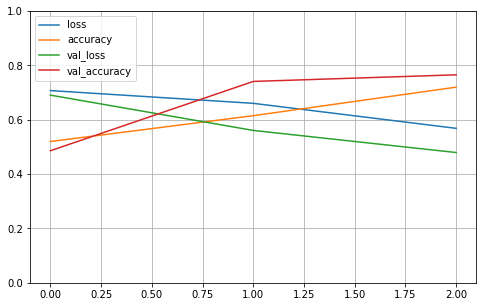

Train set ones/size 1089 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 116 / 247
Range of scores: 0.018670764 to 0.9819505
Score threshold 0.5
Prediction set ones/size 130 / 247


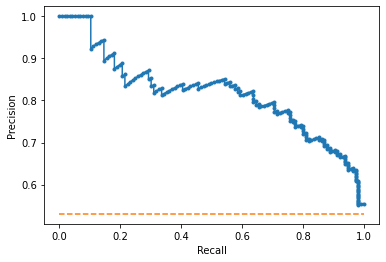

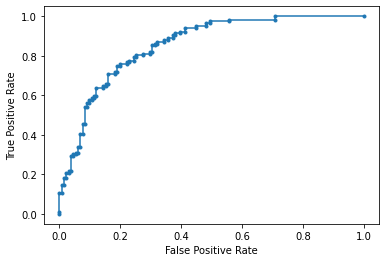

Accuracy: 76.52% Precision: 72.31% Recall: 81.03%
F1: 76.42% AUPRC: 81.73% AUROC: 85.48%
2023-02-07 15:22:02.011749
Fold 7
RCI mean derived from training set: -0.8069793445045045
RCI threshold derived from training set: -0.8069793445045045
FIT
2023-02-07 15:22:05.097512
PREDICT
2023-02-07 15:22:08.187050


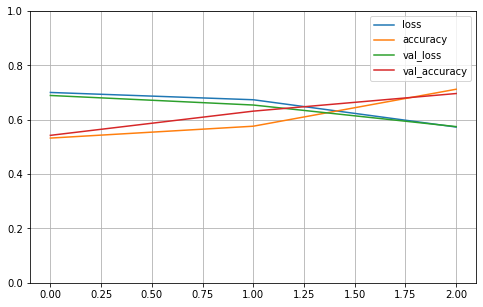

Train set ones/size 1080 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 127 / 247
Range of scores: 0.0017899863 to 0.97628015
Score threshold 0.5
Prediction set ones/size 132 / 247


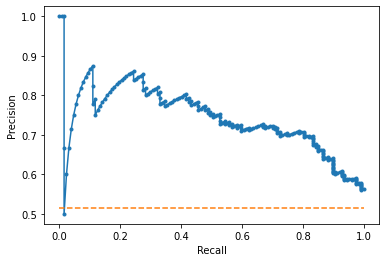

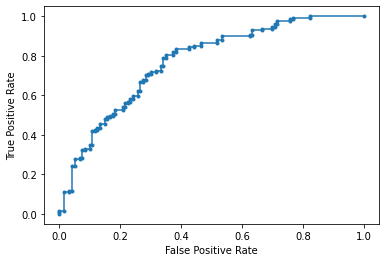

Accuracy: 69.64% Precision: 69.70% Recall: 72.44%
F1: 71.04% AUPRC: 74.21% AUROC: 76.94%
2023-02-07 15:22:08.802285
Fold 8
RCI mean derived from training set: -0.8009138882485366
RCI threshold derived from training set: -0.8009138882485366
FIT
2023-02-07 15:22:11.011300
PREDICT
2023-02-07 15:22:14.338077


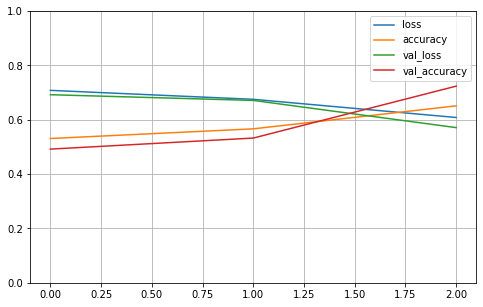

Train set ones/size 1081 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 124 / 246
Range of scores: 0.01173936 to 0.96750313
Score threshold 0.5
Prediction set ones/size 96 / 246


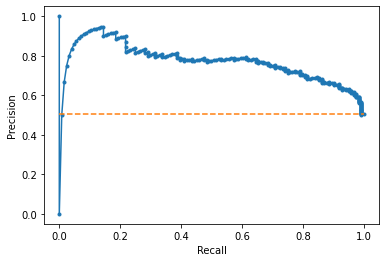

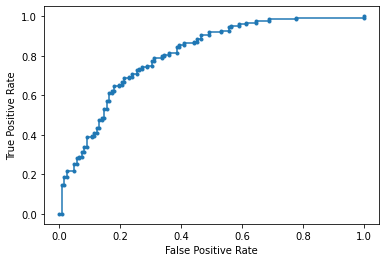

Accuracy: 72.36% Precision: 79.17% Recall: 61.29%
F1: 69.09% AUPRC: 76.94% AUROC: 80.40%
2023-02-07 15:22:14.970193
Fold 9
RCI mean derived from training set: -0.8323262177397568
RCI threshold derived from training set: -0.8323262177397568
FIT
2023-02-07 15:22:18.075132
PREDICT
2023-02-07 15:22:21.124620


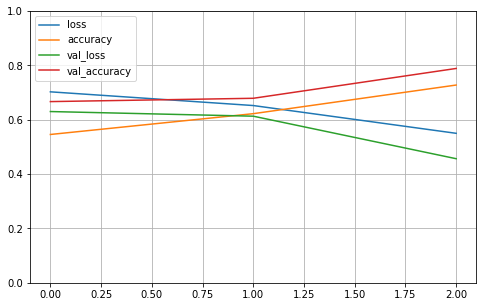

Train set ones/size 1272 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 164 / 246
Range of scores: 0.15311272 to 0.99482936
Score threshold 0.5
Prediction set ones/size 210 / 246


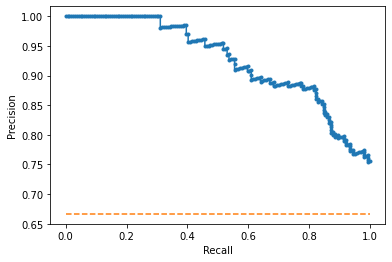

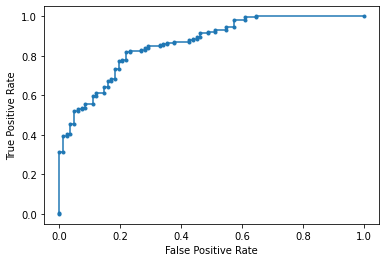

Accuracy: 78.86% Precision: 76.67% Recall: 98.17%
F1: 86.10% AUPRC: 92.61% AUROC: 86.27%
2023-02-07 15:22:21.761395
Fold 10
RCI mean derived from training set: -0.8036815406573616
RCI threshold derived from training set: -0.8036815406573616
FIT
2023-02-07 15:22:24.008307
PREDICT
2023-02-07 15:22:27.339960


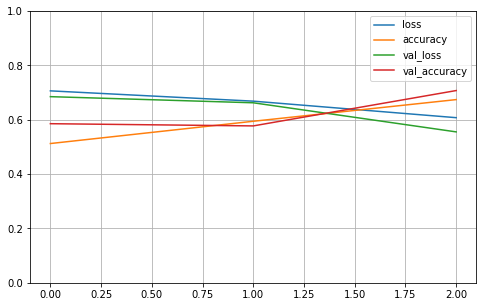

Train set ones/size 1088 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 117 / 246
Range of scores: 0.00503863 to 0.92978936
Score threshold 0.5
Prediction set ones/size 107 / 246


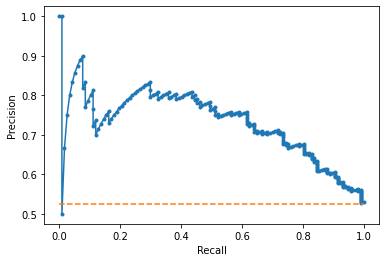

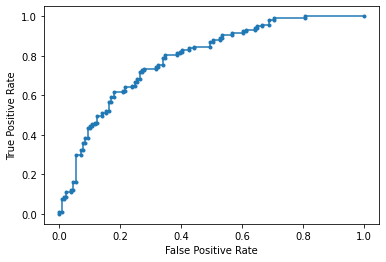

Accuracy: 70.73% Precision: 71.03% Recall: 64.96%
F1: 67.86% AUPRC: 73.07% AUROC: 78.71%
2023-02-07 15:22:28.039652

Completed cross validation 10 folds 3 epochs
 accuracy mean 72.44% +/- 3.36
 precision mean 72.76% +/- 4.13
 recall mean 71.26% +/- 14.03
 F1 mean 71.25% +/- 7.16
 AUPRC mean 78.70% +/- 5.60
 AUROC mean 81.38% +/- 2.86
Finished cell Line 14 IMR.90

2023-02-07 15:22:29.402933


In [10]:
for CELL_LINE in range(15):
    print(datetime.now())
    print('Start cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM

    print("Cross validation...")
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
    cvdo = None
    print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy,ddof=1)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision,ddof=1)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall,ddof=1)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1,ddof=1)))
    print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc,ddof=1)))
    print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc,ddof=1)))
    print('Finished cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print()
print(datetime.now())